In [1]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt



In [2]:
# Get CIFAR10 Dataset
data_set = datasets.CIFAR10(root="./data", download=False, transform=transforms.Compose(
    [transforms.Resize(64),transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]))
data_loader = torch.utils.data.DataLoader(data_set, batch_size = 128, shuffle=True, num_workers=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        
        self.main = nn.Sequential(
            nn.Conv2d(3,64,4,2,1,bias = False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2,True),
            nn.Conv2d(64,128,4,2,1,bias = False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2,True),
            nn.Conv2d(128,256,4,2,1,bias = False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2,True),
            nn.Conv2d(256,512,4,2,1,bias = False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2,True)
        )
        
        self.verify = nn.Sequential(
            nn.Conv2d(512, 1, 4, 1, 0, bias = False), 
            nn.Sigmoid()
        )
        
        self.labels = nn.Sequential(
            nn.Conv2d(512, 11, 4, 1, 0, bias = False), 
            nn.LogSoftmax(dim = 1)
        )
        
    def forward(self, passed_input):
        passed_input = self.main(passed_input)
        validity = self.verify(passed_input)
        output_labels = self.labels(passed_input)
        
        # resize
        validity = validity.view(-1)
        output_labels = output_labels.view(-1,11)
        return validity, output_labels

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        
        self.emb = nn.Embedding(10,100)
        
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100,512,4,1,0,bias = False),
            nn.ReLU(True),
            nn.ConvTranspose2d(512,256,4,2,1,bias = False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256,128,4,2,1,bias = False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128,64,4,2,1,bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64,3,4,2,1,bias = False),
            nn.Tanh()
        )
        
    def forward(self, noise, inputLabels):
        embLabels = self.emb(inputLabels)
        temp = torch.mul(noise, embLabels)
        temp = temp.view(-1, 100, 1, 1)
        return self.main(temp)

In [6]:
# Create Generator and Discriminator and apply initial weights
discriminator = Discriminator().to(device)
generator = Generator().to(device)
discriminator.apply(weights_init)
generator.apply(weights_init)

Generator(
  (emb): Embedding(10, 100)
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): Tanh()
  )
)

In [7]:
# Setup optimizers 
dis_optim = optim.Adam(discriminator.parameters(), 0.0002, betas = (0.5,0.999))
gen_optim = optim.Adam(generator.parameters(), 0.0002, betas = (0.5,0.999))
criterion = nn.BCELoss()

# Parameters for training
num_epochs = 5
real_labels_tensor = 0.7 + 0.5 * torch.rand(10, device = device)
fake_labels_tensor = 0.3 * torch.rand(10, device = device)

# Variables to track training progress
counter_list = []
counter = 0
gen_loss_list = []
dis_loss_list = []


In [8]:
import os
import torch
import torch.nn.functional as F
import torchvision.utils as vutils

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Move models to device
discriminator.to(device)
generator.to(device)

# Create output folder if not exists
if not os.path.exists('ACGANOutput'):
    os.makedirs('ACGANOutput')

# Move models to device
discriminator.to(device)
generator.to(device)

# Setup optimizers 
dis_optim = optim.Adam(discriminator.parameters(), 0.0002, betas = (0.5,0.999))
gen_optim = optim.Adam(generator.parameters(), 0.0002, betas = (0.5,0.999))
criterion = nn.BCELoss()

# Parameters for training
num_epochs = 10
real_labels_tensor = 0.7 + 0.5 * torch.rand(10, device = device)
fake_labels_tensor = 0.3 * torch.rand(10, device = device)

# Variables to track training progress
counter_list = []
counter = 0
gen_loss_list = []
dis_loss_list = []
lr = 0.0002
num_classes = 10 
batch_size = 10

# Create output folder if not exists
if not os.path.exists('ACGANOutput'):
    os.makedirs('ACGANOutput')

# Training algorithm for discriminator and generator
for epoch in range(0, num_epochs):
    
    # Iterate through all batches
    for index, (data, image_labels) in enumerate(data_loader, 0):
        counter += 1
        counter_list.append(counter)
        
        # make data avaialbe for cuda
        data = data.to(device)
        image_labels = image_labels.to(device)
        size_of_batch = data.size(0)
        labels_real = real_labels_tensor[index % 10]
        labels_fake = fake_labels_tensor[index % 10]
        class_labels_fake = 10 * torch.ones((size_of_batch, ), dtype = torch.long, device = device)
        
        # Periodically switch labels
        if index % 25 == 0:
            temp = labels_real
            labels_real = labels_fake
            labels_fake = temp
        
        # Train Discriminator with real data
        labels_for_validate = torch.full((size_of_batch, ), labels_real, device = device)
        dis_optim.zero_grad() 
        validity, output_labels = discriminator(data)       
        dis_real_valid_error = criterion(validity, labels_for_validate)            
        dis_real_label_error = F.nll_loss(output_labels, image_labels)
        dis_real_error = dis_real_valid_error + dis_real_label_error
        dis_real_error.backward()
        valid_mean1 = validity.mean().item()        
        
        # Train Discriminator with fake data
        dis_fake_labels = torch.randint(0, 10, (size_of_batch, ), dtype = torch.long, device = device)
        noise = torch.randn(size_of_batch, 100, device = device)  
        labels_for_validate.fill_(labels_fake)
        fake_output = generator(noise, dis_fake_labels)
        validity, output_labels = discriminator(fake_output.detach())       
        dis_fake_valid_error = criterion(validity, labels_for_validate)
        dis_fake_label_error = F.nll_loss(output_labels, class_labels_fake)
        dis_fake_error = dis_fake_valid_error + dis_fake_label_error
        dis_fake_error.backward()
        final_dis_error = dis_real_error + dis_fake_error
        valid_mean2 = validity.mean().item()
        dis_optim.step()
    
        # Train Generator
        labels_for_validate.fill_(1)
        labels_for_gen = torch.randint(0, 10, (size_of_batch, ), device = device, dtype = torch.long)
        noise = torch.randn(size_of_batch, 100, device = device)  
        gen_optim .zero_grad()
        fake_output = generator(noise, labels_for_gen)
        validity, output_labels = discriminator(fake_output)
        gen_valid_error = criterion(validity, labels_for_validate)        
        gen_label_error = F.nll_loss(output_labels, labels_for_gen)
        final_gen_error = gen_valid_error + gen_label_error
        final_gen_error.backward()
        valid_mean3 = validity.mean().item()
        gen_optim .step()
        
        
        print("[{}/{}] [{}/{}] D(x): [{:.4f}] D(G): [{:.4f}/{:.4f}] GLoss: [{:.4f}] DLoss: [{:.4f}] DLabel: [{:.4f}] "
              .format(epoch, num_epochs, index, len(data_loader), valid_mean1, valid_mean2, valid_mean3, final_gen_error, final_dis_error,
                      dis_real_label_error+ dis_fake_label_error + gen_label_error))
        
        # Save errors for graphing
        dis_loss_list.append(final_dis_error.cpu().detach().numpy())
        gen_loss_list.append(final_gen_error.cpu().detach().numpy())
        
    # Save images to folder
    labels = torch.arange(0,10,dtype = torch.long,device = device)
    noise = torch.randn(10,100,device = device)  
    images = generator(noise, labels)
    vutils.save_image(images.detach(),'ACGANOutput/fake_samples_epoch_%03d.png' % (epoch), normalize = True)
    
    # Save counter list to a variable
counter_list_variable = counter_list
print(counter_list_variable)

# Print generator loss list
print("Generator Loss List:")
print(*gen_loss_list, sep=', ')

# Print discriminator loss list
print("Discriminator Loss List:")
print(*dis_loss_list, sep=', ')

[0/10] [0/391] D(x): [0.4657] D(G): [0.6014/0.9119] GLoss: [7.0809] DLoss: [7.7337] DLabel: [13.2724] 
[0/10] [1/391] D(x): [0.5389] D(G): [0.8988/0.3912] GLoss: [8.0321] DLoss: [7.4674] DLabel: [10.9485] 
[0/10] [2/391] D(x): [0.3626] D(G): [0.6159/0.2526] GLoss: [8.0003] DLoss: [6.4369] DLabel: [10.6129] 
[0/10] [3/391] D(x): [0.5497] D(G): [0.5916/0.3221] GLoss: [7.8206] DLoss: [5.6523] DLabel: [10.5709] 
[0/10] [4/391] D(x): [0.7948] D(G): [0.7416/0.1206] GLoss: [9.6583] DLoss: [5.4285] DLabel: [10.8461] 
[0/10] [5/391] D(x): [0.7260] D(G): [0.5370/0.0726] GLoss: [10.1611] DLoss: [5.0457] DLabel: [10.6854] 
[0/10] [6/391] D(x): [0.6476] D(G): [0.4812/0.0389] GLoss: [11.3162] DLoss: [5.3023] DLabel: [11.3996] 
[0/10] [7/391] D(x): [0.5873] D(G): [0.4575/0.0138] GLoss: [12.9487] DLoss: [4.8581] DLabel: [11.3312] 
[0/10] [8/391] D(x): [0.4438] D(G): [0.2010/0.1041] GLoss: [10.5931] DLoss: [4.7725] DLabel: [11.0140] 
[0/10] [9/391] D(x): [0.6448] D(G): [0.7347/0.0629] GLoss: [11.8218] 

[0/10] [79/391] D(x): [0.7438] D(G): [0.0844/0.2976] GLoss: [8.3970] DLoss: [3.3434] DLabel: [9.1209] 
[0/10] [80/391] D(x): [0.8405] D(G): [0.5359/0.1986] GLoss: [10.2131] DLoss: [3.0177] DLabel: [10.2704] 
[0/10] [81/391] D(x): [0.8509] D(G): [0.3856/0.0159] GLoss: [13.3557] DLoss: [2.9076] DLabel: [10.5960] 
[0/10] [82/391] D(x): [0.7838] D(G): [0.0293/0.0511] GLoss: [10.4299] DLoss: [3.1749] DLabel: [9.0705] 
[0/10] [83/391] D(x): [0.8681] D(G): [0.1819/0.4460] GLoss: [8.2690] DLoss: [2.3062] DLabel: [9.2877] 
[0/10] [84/391] D(x): [0.9236] D(G): [0.6814/0.0236] GLoss: [14.8093] DLoss: [3.2049] DLabel: [12.6939] 
[0/10] [85/391] D(x): [0.8894] D(G): [0.0769/0.0291] GLoss: [14.1298] DLoss: [2.7327] DLabel: [12.0149] 
[0/10] [86/391] D(x): [0.8582] D(G): [0.0880/0.0888] GLoss: [10.7867] DLoss: [2.5973] DLabel: [9.9899] 
[0/10] [87/391] D(x): [0.9027] D(G): [0.3139/0.0129] GLoss: [11.9764] DLoss: [2.9528] DLabel: [9.3800] 
[0/10] [88/391] D(x): [0.8069] D(G): [0.0694/0.0566] GLoss: [1

[0/10] [160/391] D(x): [0.8664] D(G): [0.3082/0.2184] GLoss: [10.8579] DLoss: [2.5703] DLabel: [11.0548] 
[0/10] [161/391] D(x): [0.8024] D(G): [0.3248/0.0471] GLoss: [12.9546] DLoss: [2.3874] DLabel: [11.3193] 
[0/10] [162/391] D(x): [0.7919] D(G): [0.1002/0.2867] GLoss: [7.1103] DLoss: [2.7533] DLabel: [7.4636] 
[0/10] [163/391] D(x): [0.8965] D(G): [0.5138/0.0431] GLoss: [15.2527] DLoss: [2.4356] DLabel: [13.9792] 
[0/10] [164/391] D(x): [0.6672] D(G): [0.0731/0.5512] GLoss: [5.5996] DLoss: [3.6730] DLabel: [7.6087] 
[0/10] [165/391] D(x): [0.9240] D(G): [0.6379/0.1182] GLoss: [11.4752] DLoss: [3.3800] DLabel: [11.2884] 
[0/10] [166/391] D(x): [0.8406] D(G): [0.1905/0.0612] GLoss: [12.5631] DLoss: [2.6343] DLabel: [11.4761] 
[0/10] [167/391] D(x): [0.7841] D(G): [0.1108/0.0507] GLoss: [11.8864] DLoss: [2.5163] DLabel: [10.5945] 
[0/10] [168/391] D(x): [0.7700] D(G): [0.1065/0.1235] GLoss: [9.2616] DLoss: [2.5884] DLabel: [8.7745] 
[0/10] [169/391] D(x): [0.8718] D(G): [0.2787/0.2304

[0/10] [241/391] D(x): [0.8035] D(G): [0.1429/0.0797] GLoss: [13.0453] DLoss: [2.4197] DLabel: [12.2068] 
[0/10] [242/391] D(x): [0.7733] D(G): [0.1109/0.3340] GLoss: [8.1285] DLoss: [2.6985] DLabel: [8.5918] 
[0/10] [243/391] D(x): [0.9339] D(G): [0.4344/0.4698] GLoss: [6.5414] DLoss: [2.1111] DLabel: [7.6080] 
[0/10] [244/391] D(x): [0.9523] D(G): [0.5154/0.1061] GLoss: [11.4626] DLoss: [2.6942] DLabel: [10.9550] 
[0/10] [245/391] D(x): [0.8237] D(G): [0.1298/0.1061] GLoss: [11.3311] DLoss: [2.4824] DLabel: [10.6554] 
[0/10] [246/391] D(x): [0.9102] D(G): [0.1354/0.1154] GLoss: [10.7415] DLoss: [2.2466] DLabel: [9.9196] 
[0/10] [247/391] D(x): [0.8979] D(G): [0.1780/0.0665] GLoss: [11.3120] DLoss: [2.1831] DLabel: [9.7631] 
[0/10] [248/391] D(x): [0.7989] D(G): [0.0674/0.1571] GLoss: [8.5575] DLoss: [2.4711] DLabel: [8.1545] 
[0/10] [249/391] D(x): [0.8931] D(G): [0.1897/0.2309] GLoss: [8.1173] DLoss: [2.6456] DLabel: [8.1369] 
[0/10] [250/391] D(x): [0.8925] D(G): [0.3219/0.6771] GL

[0/10] [322/391] D(x): [0.7246] D(G): [0.0652/0.1585] GLoss: [9.1765] DLoss: [2.9664] DLabel: [8.9126] 
[0/10] [323/391] D(x): [0.8429] D(G): [0.4354/0.1688] GLoss: [13.9156] DLoss: [2.5040] DLabel: [13.9414] 
[0/10] [324/391] D(x): [0.8117] D(G): [0.3559/0.1530] GLoss: [13.8278] DLoss: [2.6062] DLabel: [13.5635] 
[0/10] [325/391] D(x): [0.8534] D(G): [0.3022/0.8648] GLoss: [9.0945] DLoss: [4.5700] DLabel: [10.4977] 
[0/10] [326/391] D(x): [0.8598] D(G): [0.8990/0.1960] GLoss: [10.9217] DLoss: [4.5300] DLabel: [10.8336] 
[0/10] [327/391] D(x): [0.6547] D(G): [0.2542/0.0155] GLoss: [13.4181] DLoss: [2.8792] DLabel: [10.7614] 
[0/10] [328/391] D(x): [0.5292] D(G): [0.0216/0.0320] GLoss: [10.7062] DLoss: [3.1976] DLabel: [8.3834] 
[0/10] [329/391] D(x): [0.7293] D(G): [0.0734/0.1147] GLoss: [10.2789] DLoss: [3.3434] DLabel: [9.9127] 
[0/10] [330/391] D(x): [0.8442] D(G): [0.1652/0.4753] GLoss: [9.4463] DLoss: [2.7420] DLabel: [10.5255] 
[0/10] [331/391] D(x): [0.8800] D(G): [0.5570/0.0650

[1/10] [12/391] D(x): [0.7790] D(G): [0.3630/0.2569] GLoss: [8.4224] DLoss: [2.8192] DLabel: [8.6682] 
[1/10] [13/391] D(x): [0.7778] D(G): [0.3287/0.4233] GLoss: [6.3804] DLoss: [2.4111] DLabel: [7.2220] 
[1/10] [14/391] D(x): [0.8734] D(G): [0.5045/0.3513] GLoss: [7.2782] DLoss: [2.9195] DLabel: [8.1214] 
[1/10] [15/391] D(x): [0.8012] D(G): [0.4444/0.2786] GLoss: [7.5581] DLoss: [2.8637] DLabel: [7.9971] 
[1/10] [16/391] D(x): [0.7942] D(G): [0.3959/0.1840] GLoss: [8.0220] DLoss: [2.6644] DLabel: [7.8254] 
[1/10] [17/391] D(x): [0.6723] D(G): [0.2329/0.1496] GLoss: [7.4933] DLoss: [2.7499] DLabel: [7.2832] 
[1/10] [18/391] D(x): [0.6145] D(G): [0.1980/0.2509] GLoss: [6.1865] DLoss: [2.9160] DLabel: [6.5632] 
[1/10] [19/391] D(x): [0.7571] D(G): [0.3618/0.1968] GLoss: [9.7227] DLoss: [3.2624] DLabel: [10.1403] 
[1/10] [20/391] D(x): [0.6356] D(G): [0.2488/0.4293] GLoss: [6.9857] DLoss: [3.3654] DLabel: [8.3389] 
[1/10] [21/391] D(x): [0.8284] D(G): [0.4921/0.2906] GLoss: [7.3171] DLo

[1/10] [93/391] D(x): [0.7453] D(G): [0.4654/0.2404] GLoss: [10.0845] DLoss: [3.0928] DLabel: [10.8608] 
[1/10] [94/391] D(x): [0.7626] D(G): [0.3524/0.3267] GLoss: [8.8932] DLoss: [2.6720] DLabel: [9.4791] 
[1/10] [95/391] D(x): [0.8407] D(G): [0.4958/0.2040] GLoss: [9.2748] DLoss: [2.7595] DLabel: [9.2482] 
[1/10] [96/391] D(x): [0.7849] D(G): [0.3554/0.1460] GLoss: [8.0416] DLoss: [2.7684] DLabel: [7.7227] 
[1/10] [97/391] D(x): [0.7025] D(G): [0.3220/0.0573] GLoss: [10.5882] DLoss: [2.9293] DLabel: [9.4677] 
[1/10] [98/391] D(x): [0.5890] D(G): [0.1663/0.1614] GLoss: [7.9714] DLoss: [2.8085] DLabel: [7.6778] 
[1/10] [99/391] D(x): [0.7032] D(G): [0.3825/0.2300] GLoss: [8.5585] DLoss: [3.3718] DLabel: [9.1611] 
[1/10] [100/391] D(x): [0.7144] D(G): [0.4259/0.6226] GLoss: [6.5554] DLoss: [3.5940] DLabel: [7.6593] 
[1/10] [101/391] D(x): [0.7360] D(G): [0.7863/0.1820] GLoss: [9.6441] DLoss: [4.3137] DLabel: [10.0657] 
[1/10] [102/391] D(x): [0.4133] D(G): [0.2865/0.5695] GLoss: [3.933

[1/10] [174/391] D(x): [0.8270] D(G): [0.4151/0.3806] GLoss: [7.2527] DLoss: [2.4466] DLabel: [7.8000] 
[1/10] [175/391] D(x): [0.8475] D(G): [0.5100/0.4109] GLoss: [6.3562] DLoss: [3.9720] DLabel: [7.0454] 
[1/10] [176/391] D(x): [0.7595] D(G): [0.5322/0.1652] GLoss: [8.9479] DLoss: [3.1628] DLabel: [9.0016] 
[1/10] [177/391] D(x): [0.4963] D(G): [0.2252/0.2360] GLoss: [5.5666] DLoss: [3.4275] DLabel: [6.4404] 
[1/10] [178/391] D(x): [0.7211] D(G): [0.3281/0.1517] GLoss: [7.9852] DLoss: [3.0377] DLabel: [8.0837] 
[1/10] [179/391] D(x): [0.5853] D(G): [0.2070/0.2994] GLoss: [6.8448] DLoss: [3.0445] DLabel: [7.3827] 
[1/10] [180/391] D(x): [0.6573] D(G): [0.3974/0.5579] GLoss: [4.4284] DLoss: [2.8828] DLabel: [5.6109] 
[1/10] [181/391] D(x): [0.8521] D(G): [0.5835/0.1315] GLoss: [10.0437] DLoss: [2.9958] DLabel: [9.5915] 
[1/10] [182/391] D(x): [0.5767] D(G): [0.1827/0.2972] GLoss: [6.5317] DLoss: [3.2473] DLabel: [7.2704] 
[1/10] [183/391] D(x): [0.8148] D(G): [0.4100/0.3726] GLoss: [6

[1/10] [255/391] D(x): [0.7258] D(G): [0.4932/0.2353] GLoss: [7.6277] DLoss: [3.1358] DLabel: [8.1199] 
[1/10] [256/391] D(x): [0.7752] D(G): [0.3591/0.1902] GLoss: [7.4213] DLoss: [2.6018] DLabel: [7.2971] 
[1/10] [257/391] D(x): [0.5969] D(G): [0.2830/0.1223] GLoss: [7.4724] DLoss: [2.8596] DLabel: [7.1285] 
[1/10] [258/391] D(x): [0.6010] D(G): [0.1876/0.1991] GLoss: [6.4116] DLoss: [2.9283] DLabel: [6.5706] 
[1/10] [259/391] D(x): [0.7856] D(G): [0.2903/0.2548] GLoss: [6.8575] DLoss: [2.7096] DLabel: [7.0198] 
[1/10] [260/391] D(x): [0.7026] D(G): [0.3352/0.4069] GLoss: [6.1681] DLoss: [2.8712] DLabel: [7.0786] 
[1/10] [261/391] D(x): [0.8420] D(G): [0.5317/0.1385] GLoss: [8.8925] DLoss: [2.9483] DLabel: [8.5286] 
[1/10] [262/391] D(x): [0.6860] D(G): [0.1966/0.2111] GLoss: [7.4738] DLoss: [2.8628] DLabel: [7.5708] 
[1/10] [263/391] D(x): [0.6385] D(G): [0.2843/0.6141] GLoss: [3.4599] DLoss: [2.7897] DLabel: [4.7670] 
[1/10] [264/391] D(x): [0.9277] D(G): [0.7366/0.2023] GLoss: [9.

[1/10] [336/391] D(x): [0.7364] D(G): [0.4410/0.1646] GLoss: [7.3825] DLoss: [2.9906] DLabel: [7.3736] 
[1/10] [337/391] D(x): [0.6302] D(G): [0.2698/0.1185] GLoss: [7.5212] DLoss: [2.7319] DLabel: [7.0588] 
[1/10] [338/391] D(x): [0.4966] D(G): [0.2660/0.2867] GLoss: [5.7478] DLoss: [3.1309] DLabel: [6.2878] 
[1/10] [339/391] D(x): [0.6708] D(G): [0.3971/0.2731] GLoss: [6.9830] DLoss: [3.2740] DLabel: [7.6862] 
[1/10] [340/391] D(x): [0.6845] D(G): [0.3808/0.4841] GLoss: [5.0736] DLoss: [2.8034] DLabel: [6.0516] 
[1/10] [341/391] D(x): [0.8518] D(G): [0.5842/0.1395] GLoss: [9.2839] DLoss: [3.1610] DLabel: [8.9477] 
[1/10] [342/391] D(x): [0.6391] D(G): [0.2123/0.2805] GLoss: [6.0589] DLoss: [3.1338] DLabel: [6.6613] 
[1/10] [343/391] D(x): [0.7966] D(G): [0.5236/0.2472] GLoss: [8.4419] DLoss: [2.7676] DLabel: [8.9959] 
[1/10] [344/391] D(x): [0.7299] D(G): [0.4620/0.3527] GLoss: [6.5031] DLoss: [2.9642] DLabel: [7.3505] 
[1/10] [345/391] D(x): [0.7432] D(G): [0.5036/0.2660] GLoss: [6.

[2/10] [27/391] D(x): [0.5530] D(G): [0.2851/0.1466] GLoss: [6.8953] DLoss: [2.7831] DLabel: [6.6080] 
[2/10] [28/391] D(x): [0.4637] D(G): [0.2097/0.3825] GLoss: [4.0979] DLoss: [2.9974] DLabel: [4.7662] 
[2/10] [29/391] D(x): [0.7548] D(G): [0.4645/0.2885] GLoss: [6.3097] DLoss: [3.2329] DLabel: [7.0553] 
[2/10] [30/391] D(x): [0.6621] D(G): [0.3793/0.3966] GLoss: [6.0135] DLoss: [2.7280] DLabel: [6.6706] 
[2/10] [31/391] D(x): [0.7831] D(G): [0.5236/0.1732] GLoss: [8.1026] DLoss: [2.7491] DLabel: [7.7528] 
[2/10] [32/391] D(x): [0.5366] D(G): [0.3147/0.4193] GLoss: [4.1829] DLoss: [3.2627] DLabel: [5.2360] 
[2/10] [33/391] D(x): [0.7552] D(G): [0.4957/0.4274] GLoss: [5.6013] DLoss: [2.9058] DLabel: [6.8039] 
[2/10] [34/391] D(x): [0.7861] D(G): [0.5489/0.2918] GLoss: [7.3417] DLoss: [2.6633] DLabel: [7.6178] 
[2/10] [35/391] D(x): [0.6864] D(G): [0.4111/0.3608] GLoss: [5.1093] DLoss: [2.9898] DLabel: [5.9240] 
[2/10] [36/391] D(x): [0.7412] D(G): [0.4619/0.2278] GLoss: [6.1280] DLos

[2/10] [108/391] D(x): [0.6364] D(G): [0.2125/0.2542] GLoss: [5.3492] DLoss: [2.8665] DLabel: [5.7411] 
[2/10] [109/391] D(x): [0.7531] D(G): [0.3583/0.2160] GLoss: [6.6567] DLoss: [3.0275] DLabel: [6.9523] 
[2/10] [110/391] D(x): [0.6535] D(G): [0.2994/0.4704] GLoss: [4.6238] DLoss: [2.8439] DLabel: [5.5921] 
[2/10] [111/391] D(x): [0.8289] D(G): [0.5927/0.1907] GLoss: [7.0731] DLoss: [3.2630] DLabel: [7.1940] 
[2/10] [112/391] D(x): [0.6485] D(G): [0.2608/0.4579] GLoss: [3.4949] DLoss: [2.7519] DLabel: [4.2745] 
[2/10] [113/391] D(x): [0.7768] D(G): [0.5199/0.1919] GLoss: [8.8178] DLoss: [3.0455] DLabel: [9.3056] 
[2/10] [114/391] D(x): [0.7110] D(G): [0.2578/0.4592] GLoss: [4.9380] DLoss: [2.7739] DLabel: [5.9866] 
[2/10] [115/391] D(x): [0.8670] D(G): [0.5960/0.3283] GLoss: [5.6875] DLoss: [2.8990] DLabel: [6.1739] 
[2/10] [116/391] D(x): [0.7617] D(G): [0.5109/0.1591] GLoss: [7.1001] DLoss: [2.9693] DLabel: [6.9141] 
[2/10] [117/391] D(x): [0.5263] D(G): [0.3034/0.2057] GLoss: [4.

[2/10] [189/391] D(x): [0.5699] D(G): [0.3733/0.4080] GLoss: [4.5175] DLoss: [3.2730] DLabel: [5.5756] 
[2/10] [190/391] D(x): [0.7345] D(G): [0.4982/0.3589] GLoss: [5.9116] DLoss: [2.8950] DLabel: [6.6600] 
[2/10] [191/391] D(x): [0.7123] D(G): [0.4326/0.2595] GLoss: [5.5920] DLoss: [3.1064] DLabel: [6.1871] 
[2/10] [192/391] D(x): [0.6755] D(G): [0.3879/0.2312] GLoss: [5.6111] DLoss: [3.1083] DLabel: [6.0519] 
[2/10] [193/391] D(x): [0.6881] D(G): [0.3527/0.4314] GLoss: [4.5154] DLoss: [2.5651] DLabel: [5.3358] 
[2/10] [194/391] D(x): [0.8067] D(G): [0.5197/0.3875] GLoss: [5.0976] DLoss: [2.8558] DLabel: [5.9431] 
[2/10] [195/391] D(x): [0.7589] D(G): [0.4512/0.3910] GLoss: [4.2026] DLoss: [2.7055] DLabel: [4.8660] 
[2/10] [196/391] D(x): [0.7044] D(G): [0.4324/0.2637] GLoss: [4.9053] DLoss: [3.0090] DLabel: [5.4002] 
[2/10] [197/391] D(x): [0.6633] D(G): [0.2953/0.1362] GLoss: [6.1968] DLoss: [2.7512] DLabel: [5.8769] 
[2/10] [198/391] D(x): [0.5276] D(G): [0.2123/0.2894] GLoss: [4.

[2/10] [270/391] D(x): [0.5694] D(G): [0.2290/0.5596] GLoss: [3.8509] DLoss: [3.1988] DLabel: [5.2157] 
[2/10] [271/391] D(x): [0.8766] D(G): [0.6390/0.1632] GLoss: [8.1341] DLoss: [3.4519] DLabel: [8.1266] 
[2/10] [272/391] D(x): [0.6409] D(G): [0.2583/0.3568] GLoss: [4.6511] DLoss: [2.8152] DLabel: [5.2347] 
[2/10] [273/391] D(x): [0.7856] D(G): [0.4788/0.4528] GLoss: [4.4369] DLoss: [2.5731] DLabel: [5.4666] 
[2/10] [274/391] D(x): [0.7925] D(G): [0.5148/0.3240] GLoss: [5.7220] DLoss: [2.5490] DLabel: [6.0469] 
[2/10] [275/391] D(x): [0.7438] D(G): [0.4598/0.3814] GLoss: [4.7720] DLoss: [3.5743] DLabel: [5.3029] 
[2/10] [276/391] D(x): [0.6659] D(G): [0.5066/0.2769] GLoss: [5.4568] DLoss: [3.3806] DLabel: [6.2075] 
[2/10] [277/391] D(x): [0.5298] D(G): [0.3480/0.2072] GLoss: [4.9324] DLoss: [3.1856] DLabel: [5.3206] 
[2/10] [278/391] D(x): [0.5267] D(G): [0.2665/0.2854] GLoss: [4.6737] DLoss: [3.0783] DLabel: [5.2326] 
[2/10] [279/391] D(x): [0.6495] D(G): [0.3600/0.2922] GLoss: [6.

[2/10] [351/391] D(x): [0.7649] D(G): [0.6839/0.2631] GLoss: [6.6054] DLoss: [3.7362] DLabel: [7.2784] 
[2/10] [352/391] D(x): [0.5426] D(G): [0.3471/0.3635] GLoss: [4.7576] DLoss: [3.3426] DLabel: [5.7473] 
[2/10] [353/391] D(x): [0.7051] D(G): [0.5003/0.3619] GLoss: [5.6755] DLoss: [2.7737] DLabel: [6.4532] 
[2/10] [354/391] D(x): [0.8020] D(G): [0.5294/0.2590] GLoss: [6.8951] DLoss: [2.6770] DLabel: [7.1173] 
[2/10] [355/391] D(x): [0.7197] D(G): [0.4098/0.2725] GLoss: [5.7925] DLoss: [2.8824] DLabel: [6.2527] 
[2/10] [356/391] D(x): [0.7289] D(G): [0.4836/0.1705] GLoss: [7.0094] DLoss: [3.0713] DLabel: [7.0267] 
[2/10] [357/391] D(x): [0.5877] D(G): [0.3121/0.1673] GLoss: [5.8051] DLoss: [2.8580] DLabel: [5.7307] 
[2/10] [358/391] D(x): [0.5295] D(G): [0.2563/0.2679] GLoss: [4.8690] DLoss: [3.0491] DLabel: [5.3078] 
[2/10] [359/391] D(x): [0.6206] D(G): [0.4200/0.3039] GLoss: [5.6179] DLoss: [3.4875] DLabel: [6.5899] 
[2/10] [360/391] D(x): [0.6772] D(G): [0.4365/0.3765] GLoss: [5.

[3/10] [42/391] D(x): [0.6194] D(G): [0.2975/0.2722] GLoss: [4.9631] DLoss: [3.0828] DLabel: [5.4462] 
[3/10] [43/391] D(x): [0.6661] D(G): [0.3563/0.5717] GLoss: [2.9511] DLoss: [2.7294] DLabel: [4.1584] 
[3/10] [44/391] D(x): [0.8674] D(G): [0.6653/0.2835] GLoss: [6.9156] DLoss: [3.1648] DLabel: [7.4963] 
[3/10] [45/391] D(x): [0.6831] D(G): [0.4051/0.4527] GLoss: [3.8085] DLoss: [3.1226] DLabel: [4.9991] 
[3/10] [46/391] D(x): [0.8050] D(G): [0.5882/0.1366] GLoss: [7.2894] DLoss: [3.4691] DLabel: [7.3025] 
[3/10] [47/391] D(x): [0.4848] D(G): [0.2222/0.2751] GLoss: [4.0030] DLoss: [3.2882] DLabel: [4.8044] 
[3/10] [48/391] D(x): [0.6036] D(G): [0.3907/0.1724] GLoss: [6.3396] DLoss: [3.8151] DLabel: [7.0830] 
[3/10] [49/391] D(x): [0.4897] D(G): [0.2403/0.4312] GLoss: [4.0145] DLoss: [3.4863] DLabel: [5.2286] 
[3/10] [50/391] D(x): [0.7374] D(G): [0.5081/0.5753] GLoss: [3.8677] DLoss: [3.7395] DLabel: [5.1544] 
[3/10] [51/391] D(x): [0.8105] D(G): [0.6622/0.1808] GLoss: [7.2753] DLos

[3/10] [123/391] D(x): [0.9429] D(G): [0.8867/0.3360] GLoss: [5.9379] DLoss: [6.8968] DLabel: [10.3067] 
[3/10] [124/391] D(x): [0.5899] D(G): [0.4076/0.4011] GLoss: [4.5974] DLoss: [3.6976] DLabel: [6.1125] 
[3/10] [125/391] D(x): [0.6873] D(G): [0.5165/0.5294] GLoss: [2.8800] DLoss: [4.0524] DLabel: [4.4542] 
[3/10] [126/391] D(x): [0.6850] D(G): [0.6026/0.1803] GLoss: [6.8299] DLoss: [3.7962] DLabel: [7.3647] 
[3/10] [127/391] D(x): [0.3338] D(G): [0.2695/0.4690] GLoss: [2.4787] DLoss: [4.1287] DLabel: [4.4567] 
[3/10] [128/391] D(x): [0.6414] D(G): [0.5316/0.2071] GLoss: [5.6785] DLoss: [4.0950] DLabel: [6.8365] 
[3/10] [129/391] D(x): [0.4130] D(G): [0.2671/0.5152] GLoss: [3.1509] DLoss: [4.0822] DLabel: [5.0503] 
[3/10] [130/391] D(x): [0.7399] D(G): [0.5411/0.4590] GLoss: [4.2168] DLoss: [3.2386] DLabel: [5.5170] 
[3/10] [131/391] D(x): [0.7424] D(G): [0.5237/0.2188] GLoss: [5.9154] DLoss: [3.1607] DLabel: [6.2432] 
[3/10] [132/391] D(x): [0.5178] D(G): [0.3194/0.4352] GLoss: [3

[3/10] [204/391] D(x): [0.7189] D(G): [0.5277/0.4711] GLoss: [3.9138] DLoss: [3.3145] DLabel: [5.3016] 
[3/10] [205/391] D(x): [0.7653] D(G): [0.5472/0.3216] GLoss: [4.5652] DLoss: [2.8356] DLabel: [5.0093] 
[3/10] [206/391] D(x): [0.6903] D(G): [0.3493/0.2789] GLoss: [4.2991] DLoss: [2.7451] DLabel: [4.6572] 
[3/10] [207/391] D(x): [0.6582] D(G): [0.3833/0.1252] GLoss: [6.2503] DLoss: [2.7119] DLabel: [5.6264] 
[3/10] [208/391] D(x): [0.4705] D(G): [0.2043/0.3807] GLoss: [3.4135] DLoss: [3.1842] DLabel: [4.2182] 
[3/10] [209/391] D(x): [0.7524] D(G): [0.4666/0.2655] GLoss: [5.8533] DLoss: [3.1184] DLabel: [6.3679] 
[3/10] [210/391] D(x): [0.5693] D(G): [0.3453/0.5677] GLoss: [2.9201] DLoss: [3.1353] DLabel: [4.2354] 
[3/10] [211/391] D(x): [0.8070] D(G): [0.6420/0.2263] GLoss: [5.9551] DLoss: [3.5163] DLabel: [6.3602] 
[3/10] [212/391] D(x): [0.4974] D(G): [0.3105/0.4809] GLoss: [2.8777] DLoss: [3.4280] DLabel: [4.1727] 
[3/10] [213/391] D(x): [0.7310] D(G): [0.5293/0.4557] GLoss: [3.

[3/10] [285/391] D(x): [0.6825] D(G): [0.4234/0.4432] GLoss: [3.3766] DLoss: [3.0123] DLabel: [4.4278] 
[3/10] [286/391] D(x): [0.7429] D(G): [0.5188/0.2199] GLoss: [5.4693] DLoss: [3.2570] DLabel: [5.8952] 
[3/10] [287/391] D(x): [0.5751] D(G): [0.2619/0.2078] GLoss: [4.5019] DLoss: [2.4703] DLabel: [4.3131] 
[3/10] [288/391] D(x): [0.5701] D(G): [0.2996/0.2561] GLoss: [4.5418] DLoss: [3.0884] DLabel: [5.0298] 
[3/10] [289/391] D(x): [0.6100] D(G): [0.3586/0.3870] GLoss: [4.1860] DLoss: [2.9250] DLabel: [4.8893] 
[3/10] [290/391] D(x): [0.7150] D(G): [0.4679/0.4639] GLoss: [4.0434] DLoss: [2.6066] DLabel: [4.7752] 
[3/10] [291/391] D(x): [0.7528] D(G): [0.5180/0.2166] GLoss: [5.7663] DLoss: [2.9787] DLabel: [5.8497] 
[3/10] [292/391] D(x): [0.5813] D(G): [0.2758/0.3738] GLoss: [3.7434] DLoss: [2.7607] DLabel: [4.2429] 
[3/10] [293/391] D(x): [0.7288] D(G): [0.4714/0.4873] GLoss: [3.6433] DLoss: [2.5067] DLabel: [4.5496] 
[3/10] [294/391] D(x): [0.7923] D(G): [0.5495/0.3363] GLoss: [5.

[3/10] [366/391] D(x): [0.7583] D(G): [0.5031/0.2248] GLoss: [5.0762] DLoss: [3.0022] DLabel: [5.3075] 
[3/10] [367/391] D(x): [0.5672] D(G): [0.2890/0.1636] GLoss: [5.1261] DLoss: [2.7327] DLabel: [4.9151] 
[3/10] [368/391] D(x): [0.4705] D(G): [0.2381/0.3820] GLoss: [3.1484] DLoss: [3.2303] DLabel: [4.0552] 
[3/10] [369/391] D(x): [0.6277] D(G): [0.4741/0.3656] GLoss: [4.4589] DLoss: [3.4786] DLabel: [5.6093] 
[3/10] [370/391] D(x): [0.6561] D(G): [0.4044/0.5621] GLoss: [3.0154] DLoss: [2.9403] DLabel: [4.2382] 
[3/10] [371/391] D(x): [0.8273] D(G): [0.6085/0.1835] GLoss: [6.3611] DLoss: [3.1514] DLabel: [6.3307] 
[3/10] [372/391] D(x): [0.5751] D(G): [0.2497/0.4357] GLoss: [2.9909] DLoss: [3.1086] DLabel: [3.9962] 
[3/10] [373/391] D(x): [0.7822] D(G): [0.5061/0.4034] GLoss: [4.3500] DLoss: [2.7162] DLabel: [5.3415] 
[3/10] [374/391] D(x): [0.7676] D(G): [0.4654/0.3222] GLoss: [5.3179] DLoss: [2.6728] DLabel: [5.8000] 
[3/10] [375/391] D(x): [0.7114] D(G): [0.4305/0.4829] GLoss: [3.

[4/10] [57/391] D(x): [0.5238] D(G): [0.3032/0.2004] GLoss: [4.5505] DLoss: [2.9269] DLabel: [4.6850] 
[4/10] [58/391] D(x): [0.5082] D(G): [0.2699/0.3404] GLoss: [3.6045] DLoss: [2.9301] DLabel: [4.1608] 
[4/10] [59/391] D(x): [0.6814] D(G): [0.4382/0.2758] GLoss: [5.6425] DLoss: [3.1212] DLabel: [6.1996] 
[4/10] [60/391] D(x): [0.5701] D(G): [0.3830/0.5745] GLoss: [2.8545] DLoss: [3.4198] DLabel: [4.4594] 
[4/10] [61/391] D(x): [0.8390] D(G): [0.6423/0.1987] GLoss: [6.3607] DLoss: [3.2585] DLabel: [6.4304] 
[4/10] [62/391] D(x): [0.5120] D(G): [0.2780/0.3800] GLoss: [3.5492] DLoss: [3.4273] DLabel: [4.6153] 
[4/10] [63/391] D(x): [0.7734] D(G): [0.4882/0.4637] GLoss: [3.6518] DLoss: [2.4906] DLabel: [4.5776] 
[4/10] [64/391] D(x): [0.7658] D(G): [0.5597/0.3637] GLoss: [5.0178] DLoss: [2.7973] DLabel: [5.6181] 
[4/10] [65/391] D(x): [0.7198] D(G): [0.4557/0.3794] GLoss: [3.8145] DLoss: [2.8655] DLabel: [4.5248] 
[4/10] [66/391] D(x): [0.7391] D(G): [0.4875/0.2185] GLoss: [5.3696] DLos

[4/10] [138/391] D(x): [0.5058] D(G): [0.2388/0.3677] GLoss: [2.9904] DLoss: [2.9920] DLabel: [3.6693] 
[4/10] [139/391] D(x): [0.6563] D(G): [0.4416/0.3441] GLoss: [4.2041] DLoss: [3.3070] DLabel: [5.1653] 
[4/10] [140/391] D(x): [0.6820] D(G): [0.4482/0.3898] GLoss: [4.4635] DLoss: [2.8387] DLabel: [5.2201] 
[4/10] [141/391] D(x): [0.7398] D(G): [0.5427/0.2901] GLoss: [4.7978] DLoss: [3.1350] DLabel: [5.3373] 
[4/10] [142/391] D(x): [0.5690] D(G): [0.3825/0.4452] GLoss: [2.9790] DLoss: [3.2276] DLabel: [4.1015] 
[4/10] [143/391] D(x): [0.7423] D(G): [0.5589/0.3725] GLoss: [4.7659] DLoss: [2.9621] DLabel: [5.7791] 
[4/10] [144/391] D(x): [0.7297] D(G): [0.4791/0.3671] GLoss: [4.6723] DLoss: [2.7727] DLabel: [5.3408] 
[4/10] [145/391] D(x): [0.7514] D(G): [0.4704/0.3864] GLoss: [3.7750] DLoss: [2.6264] DLabel: [4.3200] 
[4/10] [146/391] D(x): [0.7356] D(G): [0.4702/0.2302] GLoss: [5.0527] DLoss: [2.8712] DLabel: [5.2355] 
[4/10] [147/391] D(x): [0.6160] D(G): [0.2833/0.1764] GLoss: [5.

[4/10] [219/391] D(x): [0.6919] D(G): [0.4624/0.2651] GLoss: [5.1206] DLoss: [3.3109] DLabel: [5.8033] 
[4/10] [220/391] D(x): [0.6394] D(G): [0.3576/0.5423] GLoss: [2.9401] DLoss: [2.8965] DLabel: [4.0892] 
[4/10] [221/391] D(x): [0.8210] D(G): [0.5738/0.2663] GLoss: [4.7958] DLoss: [2.9100] DLabel: [4.9887] 
[4/10] [222/391] D(x): [0.6046] D(G): [0.3443/0.3340] GLoss: [3.9256] DLoss: [2.9888] DLabel: [4.5827] 
[4/10] [223/391] D(x): [0.6943] D(G): [0.3924/0.5512] GLoss: [2.7936] DLoss: [2.2262] DLabel: [3.5210] 
[4/10] [224/391] D(x): [0.8272] D(G): [0.6335/0.3520] GLoss: [5.0320] DLoss: [2.9917] DLabel: [5.7219] 
[4/10] [225/391] D(x): [0.6678] D(G): [0.3942/0.4720] GLoss: [3.2736] DLoss: [3.8330] DLabel: [4.3650] 
[4/10] [226/391] D(x): [0.7572] D(G): [0.5431/0.2982] GLoss: [4.1320] DLoss: [3.0021] DLabel: [4.6399] 
[4/10] [227/391] D(x): [0.5836] D(G): [0.3488/0.2095] GLoss: [4.6203] DLoss: [2.9298] DLabel: [4.8295] 
[4/10] [228/391] D(x): [0.5096] D(G): [0.2274/0.3683] GLoss: [3.

[4/10] [300/391] D(x): [0.5462] D(G): [0.3545/0.6250] GLoss: [2.5774] DLoss: [4.0481] DLabel: [4.2831] 
[4/10] [301/391] D(x): [0.7552] D(G): [0.6696/0.3557] GLoss: [4.2217] DLoss: [3.8042] DLabel: [5.3204] 
[4/10] [302/391] D(x): [0.5709] D(G): [0.4404/0.4314] GLoss: [3.2765] DLoss: [3.9067] DLabel: [4.9756] 
[4/10] [303/391] D(x): [0.6302] D(G): [0.4923/0.5578] GLoss: [2.8189] DLoss: [3.2544] DLabel: [4.3593] 
[4/10] [304/391] D(x): [0.7434] D(G): [0.6184/0.4051] GLoss: [4.5898] DLoss: [3.3890] DLabel: [5.7766] 
[4/10] [305/391] D(x): [0.6912] D(G): [0.4820/0.4239] GLoss: [3.4252] DLoss: [3.0048] DLabel: [4.3802] 
[4/10] [306/391] D(x): [0.7072] D(G): [0.4934/0.2987] GLoss: [4.0973] DLoss: [3.1942] DLabel: [4.8095] 
[4/10] [307/391] D(x): [0.5620] D(G): [0.3684/0.2031] GLoss: [4.5014] DLoss: [2.8567] DLabel: [4.5270] 
[4/10] [308/391] D(x): [0.4470] D(G): [0.2616/0.3730] GLoss: [3.0797] DLoss: [3.1620] DLabel: [3.8502] 
[4/10] [309/391] D(x): [0.6554] D(G): [0.4424/0.3310] GLoss: [4.

[4/10] [381/391] D(x): [0.8312] D(G): [0.5983/0.1826] GLoss: [6.7237] DLoss: [3.0273] DLabel: [6.5855] 
[4/10] [382/391] D(x): [0.4689] D(G): [0.2276/0.5513] GLoss: [2.3478] DLoss: [3.7942] DLabel: [4.0988] 
[4/10] [383/391] D(x): [0.7910] D(G): [0.6431/0.2861] GLoss: [5.3190] DLoss: [3.2203] DLabel: [6.3052] 
[4/10] [384/391] D(x): [0.6322] D(G): [0.3616/0.6429] GLoss: [2.0082] DLoss: [2.9360] DLabel: [3.4169] 
[4/10] [385/391] D(x): [0.8524] D(G): [0.7322/0.2061] GLoss: [6.7363] DLoss: [4.0658] DLabel: [7.6052] 
[4/10] [386/391] D(x): [0.5093] D(G): [0.2698/0.5308] GLoss: [2.6141] DLoss: [3.9982] DLabel: [4.7380] 
[4/10] [387/391] D(x): [0.7945] D(G): [0.5806/0.1397] GLoss: [6.1825] DLoss: [3.6935] DLabel: [6.3344] 
[4/10] [388/391] D(x): [0.3870] D(G): [0.1939/0.4126] GLoss: [2.8238] DLoss: [3.7001] DLabel: [4.0893] 
[4/10] [389/391] D(x): [0.7118] D(G): [0.5595/0.2479] GLoss: [5.1378] DLoss: [3.5800] DLabel: [5.9387] 
[4/10] [390/391] D(x): [0.5423] D(G): [0.3143/0.5724] GLoss: [2.

[5/10] [72/391] D(x): [0.3908] D(G): [0.1989/0.5860] GLoss: [1.8378] DLoss: [4.4703] DLabel: [4.1710] 
[5/10] [73/391] D(x): [0.8683] D(G): [0.6004/0.2590] GLoss: [5.9754] DLoss: [2.7617] DLabel: [6.6071] 
[5/10] [74/391] D(x): [0.5056] D(G): [0.3816/0.7692] GLoss: [1.3145] DLoss: [4.0894] DLabel: [3.8141] 
[5/10] [75/391] D(x): [0.9133] D(G): [0.8295/0.2081] GLoss: [6.6492] DLoss: [5.8460] DLabel: [8.2733] 
[5/10] [76/391] D(x): [0.4227] D(G): [0.3192/0.6844] GLoss: [1.5085] DLoss: [4.4578] DLabel: [4.1611] 
[5/10] [77/391] D(x): [0.8083] D(G): [0.7137/0.0942] GLoss: [7.7564] DLoss: [5.1399] DLabel: [8.4874] 
[5/10] [78/391] D(x): [0.1809] D(G): [0.1281/0.5292] GLoss: [1.9254] DLoss: [5.7955] DLabel: [4.7624] 
[5/10] [79/391] D(x): [0.6771] D(G): [0.5993/0.3983] GLoss: [3.7623] DLoss: [4.2936] DLabel: [5.7045] 
[5/10] [80/391] D(x): [0.5636] D(G): [0.4884/0.5566] GLoss: [2.8921] DLoss: [3.6852] DLabel: [4.6465] 
[5/10] [81/391] D(x): [0.7038] D(G): [0.6338/0.2535] GLoss: [5.5014] DLos

[5/10] [153/391] D(x): [0.7170] D(G): [0.5574/0.4480] GLoss: [3.6710] DLoss: [2.9651] DLabel: [4.8218] 
[5/10] [154/391] D(x): [0.7407] D(G): [0.5283/0.3997] GLoss: [4.0404] DLoss: [2.6846] DLabel: [4.6529] 
[5/10] [155/391] D(x): [0.7133] D(G): [0.4071/0.4541] GLoss: [3.0904] DLoss: [2.5359] DLabel: [3.7492] 
[5/10] [156/391] D(x): [0.8148] D(G): [0.5360/0.1935] GLoss: [5.6642] DLoss: [2.8720] DLabel: [5.6083] 
[5/10] [157/391] D(x): [0.5276] D(G): [0.2204/0.2469] GLoss: [3.8345] DLoss: [2.6888] DLabel: [4.0669] 
[5/10] [158/391] D(x): [0.5688] D(G): [0.2936/0.3887] GLoss: [2.7395] DLoss: [2.7524] DLabel: [3.3558] 
[5/10] [159/391] D(x): [0.7097] D(G): [0.4579/0.2414] GLoss: [5.5191] DLoss: [3.1010] DLabel: [5.9397] 
[5/10] [160/391] D(x): [0.6332] D(G): [0.2656/0.4591] GLoss: [3.4675] DLoss: [2.8039] DLabel: [4.3537] 
[5/10] [161/391] D(x): [0.8326] D(G): [0.5850/0.2248] GLoss: [5.5210] DLoss: [3.0011] DLabel: [5.5654] 
[5/10] [162/391] D(x): [0.5613] D(G): [0.2542/0.4392] GLoss: [2.

[5/10] [234/391] D(x): [0.6556] D(G): [0.4903/0.4607] GLoss: [3.6586] DLoss: [3.4714] DLabel: [5.1487] 
[5/10] [235/391] D(x): [0.6280] D(G): [0.5709/0.4914] GLoss: [2.9441] DLoss: [4.0214] DLabel: [4.8617] 
[5/10] [236/391] D(x): [0.6937] D(G): [0.6019/0.2140] GLoss: [5.1893] DLoss: [3.8834] DLabel: [6.0151] 
[5/10] [237/391] D(x): [0.4376] D(G): [0.2893/0.2854] GLoss: [3.5611] DLoss: [3.4919] DLabel: [4.5127] 
[5/10] [238/391] D(x): [0.5215] D(G): [0.3529/0.4279] GLoss: [2.7499] DLoss: [3.4515] DLabel: [4.0290] 
[5/10] [239/391] D(x): [0.6798] D(G): [0.4529/0.2308] GLoss: [5.5139] DLoss: [3.1668] DLabel: [5.9124] 
[5/10] [240/391] D(x): [0.5168] D(G): [0.3163/0.6800] GLoss: [2.0831] DLoss: [3.4583] DLabel: [3.8339] 
[5/10] [241/391] D(x): [0.8715] D(G): [0.6870/0.1683] GLoss: [6.6502] DLoss: [3.8568] DLabel: [7.0101] 
[5/10] [242/391] D(x): [0.4206] D(G): [0.2312/0.6422] GLoss: [1.6315] DLoss: [4.2175] DLabel: [3.8765] 
[5/10] [243/391] D(x): [0.8636] D(G): [0.6596/0.2871] GLoss: [5.

[5/10] [315/391] D(x): [0.7717] D(G): [0.4156/0.2853] GLoss: [5.0152] DLoss: [2.3775] DLabel: [5.0651] 
[5/10] [316/391] D(x): [0.7385] D(G): [0.3860/0.2691] GLoss: [4.5102] DLoss: [2.5586] DLabel: [4.6382] 
[5/10] [317/391] D(x): [0.7347] D(G): [0.4021/0.1019] GLoss: [6.6274] DLoss: [2.4339] DLabel: [5.5422] 
[5/10] [318/391] D(x): [0.4315] D(G): [0.1282/0.2250] GLoss: [4.1079] DLoss: [3.0679] DLabel: [4.1816] 
[5/10] [319/391] D(x): [0.6576] D(G): [0.3575/0.2621] GLoss: [4.8552] DLoss: [2.6957] DLabel: [4.9718] 
[5/10] [320/391] D(x): [0.4975] D(G): [0.3554/0.7441] GLoss: [1.3852] DLoss: [3.4209] DLabel: [3.1319] 
[5/10] [321/391] D(x): [0.9315] D(G): [0.7938/0.0742] GLoss: [10.0855] DLoss: [4.8402] DLabel: [10.0739] 
[5/10] [322/391] D(x): [0.2732] D(G): [0.1580/0.7593] GLoss: [1.4394] DLoss: [5.8479] DLabel: [5.0211] 
[5/10] [323/391] D(x): [0.9028] D(G): [0.8028/0.2621] GLoss: [6.3899] DLoss: [4.5269] DLabel: [8.4547] 
[5/10] [324/391] D(x): [0.5205] D(G): [0.3339/0.6476] GLoss: [

[6/10] [3/391] D(x): [0.8070] D(G): [0.5609/0.3819] GLoss: [4.3573] DLoss: [2.4436] DLabel: [5.0270] 
[6/10] [4/391] D(x): [0.7259] D(G): [0.4284/0.3536] GLoss: [4.9882] DLoss: [2.4728] DLabel: [5.3766] 
[6/10] [5/391] D(x): [0.7933] D(G): [0.4093/0.3687] GLoss: [3.7382] DLoss: [2.2944] DLabel: [3.9999] 
[6/10] [6/391] D(x): [0.8100] D(G): [0.3890/0.2312] GLoss: [4.9622] DLoss: [2.3462] DLabel: [4.7802] 
[6/10] [7/391] D(x): [0.6899] D(G): [0.3025/0.1351] GLoss: [5.6025] DLoss: [2.1245] DLabel: [4.6876] 
[6/10] [8/391] D(x): [0.6251] D(G): [0.2009/0.2266] GLoss: [4.4883] DLoss: [2.2120] DLabel: [4.1134] 
[6/10] [9/391] D(x): [0.6633] D(G): [0.2930/0.3263] GLoss: [3.9992] DLoss: [2.4687] DLabel: [4.1402] 
[6/10] [10/391] D(x): [0.7260] D(G): [0.3688/0.3759] GLoss: [4.2047] DLoss: [2.2633] DLabel: [4.4474] 
[6/10] [11/391] D(x): [0.8137] D(G): [0.4676/0.1754] GLoss: [6.4034] DLoss: [2.2789] DLabel: [5.7336] 
[6/10] [12/391] D(x): [0.6507] D(G): [0.2102/0.3554] GLoss: [3.9053] DLoss: [2.3

[6/10] [84/391] D(x): [0.7408] D(G): [0.4829/0.4073] GLoss: [4.1901] DLoss: [2.5592] DLabel: [4.7608] 
[6/10] [85/391] D(x): [0.7258] D(G): [0.4918/0.4489] GLoss: [3.0295] DLoss: [2.8401] DLabel: [3.9096] 
[6/10] [86/391] D(x): [0.7530] D(G): [0.4460/0.2747] GLoss: [4.1850] DLoss: [2.6534] DLabel: [4.3807] 
[6/10] [87/391] D(x): [0.5718] D(G): [0.3207/0.2572] GLoss: [3.8861] DLoss: [2.6738] DLabel: [4.0615] 
[6/10] [88/391] D(x): [0.6279] D(G): [0.3134/0.2569] GLoss: [4.1189] DLoss: [2.7354] DLabel: [4.3458] 
[6/10] [89/391] D(x): [0.6286] D(G): [0.2855/0.3515] GLoss: [3.9815] DLoss: [2.4251] DLabel: [4.1109] 
[6/10] [90/391] D(x): [0.7802] D(G): [0.4168/0.3559] GLoss: [4.6096] DLoss: [2.3491] DLabel: [4.9061] 
[6/10] [91/391] D(x): [0.7851] D(G): [0.3589/0.2421] GLoss: [5.3911] DLoss: [2.0886] DLabel: [5.0471] 
[6/10] [92/391] D(x): [0.7176] D(G): [0.3365/0.3535] GLoss: [3.6811] DLoss: [2.4161] DLabel: [3.9459] 
[6/10] [93/391] D(x): [0.8193] D(G): [0.4743/0.2943] GLoss: [5.2675] DLos

[6/10] [165/391] D(x): [0.8993] D(G): [0.5832/0.2200] GLoss: [5.8322] DLoss: [2.4638] DLabel: [5.5660] 
[6/10] [166/391] D(x): [0.6482] D(G): [0.2556/0.2834] GLoss: [4.1983] DLoss: [2.5214] DLabel: [4.4133] 
[6/10] [167/391] D(x): [0.8525] D(G): [0.4421/0.1063] GLoss: [6.7130] DLoss: [2.7198] DLabel: [5.9024] 
[6/10] [168/391] D(x): [0.4679] D(G): [0.1321/0.2643] GLoss: [3.9054] DLoss: [2.8252] DLabel: [3.9996] 
[6/10] [169/391] D(x): [0.7721] D(G): [0.4530/0.1381] GLoss: [6.9925] DLoss: [2.9323] DLabel: [6.6683] 
[6/10] [170/391] D(x): [0.4941] D(G): [0.2456/0.5592] GLoss: [2.3830] DLoss: [3.0758] DLabel: [3.5085] 
[6/10] [171/391] D(x): [0.8818] D(G): [0.6252/0.1210] GLoss: [7.6010] DLoss: [3.0576] DLabel: [6.9729] 
[6/10] [172/391] D(x): [0.3397] D(G): [0.1845/0.6517] GLoss: [1.6113] DLoss: [4.5142] DLabel: [3.9470] 
[6/10] [173/391] D(x): [0.9146] D(G): [0.6827/0.3324] GLoss: [5.0117] DLoss: [3.0710] DLabel: [6.2343] 
[6/10] [174/391] D(x): [0.7126] D(G): [0.4633/0.3948] GLoss: [4.

[6/10] [246/391] D(x): [0.7411] D(G): [0.5129/0.2652] GLoss: [4.5902] DLoss: [2.8630] DLabel: [4.8517] 
[6/10] [247/391] D(x): [0.6608] D(G): [0.2687/0.1791] GLoss: [5.1579] DLoss: [2.4145] DLabel: [4.8229] 
[6/10] [248/391] D(x): [0.6075] D(G): [0.1910/0.2681] GLoss: [3.7697] DLoss: [2.3251] DLabel: [3.6441] 
[6/10] [249/391] D(x): [0.7822] D(G): [0.4579/0.1523] GLoss: [6.6545] DLoss: [2.9830] DLabel: [6.5212] 
[6/10] [250/391] D(x): [0.5429] D(G): [0.1943/0.5640] GLoss: [2.5765] DLoss: [4.1902] DLabel: [3.7222] 
[6/10] [251/391] D(x): [0.8375] D(G): [0.6268/0.2380] GLoss: [5.8507] DLoss: [3.0958] DLabel: [5.9894] 
[6/10] [252/391] D(x): [0.5685] D(G): [0.2806/0.4386] GLoss: [3.1014] DLoss: [3.0475] DLabel: [4.0532] 
[6/10] [253/391] D(x): [0.8381] D(G): [0.5356/0.3923] GLoss: [4.1595] DLoss: [2.1436] DLabel: [4.6641] 
[6/10] [254/391] D(x): [0.7481] D(G): [0.4178/0.3873] GLoss: [4.1106] DLoss: [2.2717] DLabel: [4.4289] 
[6/10] [255/391] D(x): [0.8269] D(G): [0.3660/0.2924] GLoss: [4.

[6/10] [327/391] D(x): [0.6164] D(G): [0.3536/0.1666] GLoss: [5.3205] DLoss: [2.7740] DLabel: [5.1248] 
[6/10] [328/391] D(x): [0.5342] D(G): [0.2125/0.2498] GLoss: [4.2174] DLoss: [2.7586] DLabel: [4.3363] 
[6/10] [329/391] D(x): [0.7161] D(G): [0.3027/0.2956] GLoss: [4.0350] DLoss: [2.4796] DLabel: [4.1105] 
[6/10] [330/391] D(x): [0.7809] D(G): [0.3542/0.2770] GLoss: [5.2343] DLoss: [2.2035] DLabel: [5.1825] 
[6/10] [331/391] D(x): [0.7793] D(G): [0.3285/0.1948] GLoss: [6.1728] DLoss: [2.1515] DLabel: [5.7275] 
[6/10] [332/391] D(x): [0.7319] D(G): [0.3279/0.3354] GLoss: [3.9859] DLoss: [2.3213] DLabel: [4.1311] 
[6/10] [333/391] D(x): [0.8286] D(G): [0.4784/0.2878] GLoss: [5.5233] DLoss: [2.0269] DLabel: [5.6318] 
[6/10] [334/391] D(x): [0.8000] D(G): [0.3879/0.3226] GLoss: [4.8439] DLoss: [2.1219] DLabel: [4.9155] 
[6/10] [335/391] D(x): [0.8478] D(G): [0.4366/0.2953] GLoss: [4.8438] DLoss: [2.2188] DLabel: [4.8212] 
[6/10] [336/391] D(x): [0.8088] D(G): [0.2755/0.2049] GLoss: [5.

[7/10] [18/391] D(x): [0.5448] D(G): [0.3074/0.2602] GLoss: [4.3961] DLoss: [2.8834] DLabel: [4.6600] 
[7/10] [19/391] D(x): [0.6403] D(G): [0.3908/0.3141] GLoss: [4.2055] DLoss: [2.8305] DLabel: [4.6043] 
[7/10] [20/391] D(x): [0.6328] D(G): [0.3908/0.4595] GLoss: [3.4957] DLoss: [2.6721] DLabel: [4.2234] 
[7/10] [21/391] D(x): [0.7856] D(G): [0.5624/0.2515] GLoss: [5.4628] DLoss: [2.8425] DLabel: [5.5408] 
[7/10] [22/391] D(x): [0.5808] D(G): [0.2920/0.3991] GLoss: [3.3637] DLoss: [2.8646] DLabel: [4.0561] 
[7/10] [23/391] D(x): [0.8115] D(G): [0.4588/0.4154] GLoss: [3.8661] DLoss: [1.9604] DLabel: [4.2593] 
[7/10] [24/391] D(x): [0.8204] D(G): [0.5190/0.3254] GLoss: [4.9899] DLoss: [2.4355] DLabel: [5.2466] 
[7/10] [25/391] D(x): [0.7000] D(G): [0.4109/0.4475] GLoss: [3.1405] DLoss: [3.7077] DLabel: [4.0308] 
[7/10] [26/391] D(x): [0.8003] D(G): [0.5059/0.2841] GLoss: [4.7301] DLoss: [2.4528] DLabel: [4.7022] 
[7/10] [27/391] D(x): [0.6482] D(G): [0.2964/0.1866] GLoss: [4.7876] DLos

[7/10] [99/391] D(x): [0.8401] D(G): [0.3917/0.1235] GLoss: [7.0503] DLoss: [2.4189] DLabel: [6.1709] 
[7/10] [100/391] D(x): [0.4945] D(G): [0.2466/0.7315] GLoss: [1.2835] DLoss: [3.8918] DLabel: [2.6797] 
[7/10] [101/391] D(x): [0.9368] D(G): [0.7749/0.1216] GLoss: [8.1681] DLoss: [4.7523] DLabel: [8.6471] 
[7/10] [102/391] D(x): [0.3296] D(G): [0.1948/0.6580] GLoss: [1.8234] DLoss: [4.8558] DLabel: [4.4969] 
[7/10] [103/391] D(x): [0.8411] D(G): [0.7195/0.3095] GLoss: [5.6518] DLoss: [3.7185] DLabel: [7.1526] 
[7/10] [104/391] D(x): [0.5132] D(G): [0.4869/0.6216] GLoss: [2.4370] DLoss: [4.5963] DLabel: [5.0841] 
[7/10] [105/391] D(x): [0.7706] D(G): [0.6758/0.3929] GLoss: [4.0890] DLoss: [3.6866] DLabel: [5.3705] 
[7/10] [106/391] D(x): [0.5502] D(G): [0.4770/0.4610] GLoss: [2.6179] DLoss: [3.7854] DLabel: [4.2497] 
[7/10] [107/391] D(x): [0.6497] D(G): [0.5259/0.1638] GLoss: [5.6139] DLoss: [3.5092] DLabel: [5.8407] 
[7/10] [108/391] D(x): [0.3718] D(G): [0.2271/0.4727] GLoss: [2.2

[7/10] [180/391] D(x): [0.6420] D(G): [0.3759/0.4266] GLoss: [3.3133] DLoss: [2.5531] DLabel: [3.8662] 
[7/10] [181/391] D(x): [0.7555] D(G): [0.4573/0.2312] GLoss: [5.3234] DLoss: [2.4001] DLabel: [5.0779] 
[7/10] [182/391] D(x): [0.7015] D(G): [0.2548/0.3000] GLoss: [4.4647] DLoss: [2.1613] DLabel: [4.2921] 
[7/10] [183/391] D(x): [0.7840] D(G): [0.2945/0.5098] GLoss: [2.9242] DLoss: [1.7582] DLabel: [3.3576] 
[7/10] [184/391] D(x): [0.9281] D(G): [0.6694/0.2614] GLoss: [6.1213] DLoss: [2.8881] DLabel: [6.4030] 
[7/10] [185/391] D(x): [0.6409] D(G): [0.2463/0.3718] GLoss: [4.2016] DLoss: [2.8177] DLabel: [4.9424] 
[7/10] [186/391] D(x): [0.8263] D(G): [0.5209/0.1855] GLoss: [5.8927] DLoss: [2.5099] DLabel: [5.4395] 
[7/10] [187/391] D(x): [0.5602] D(G): [0.2229/0.2114] GLoss: [4.4699] DLoss: [2.4699] DLabel: [4.3419] 
[7/10] [188/391] D(x): [0.7768] D(G): [0.4477/0.1063] GLoss: [7.2275] DLoss: [2.7584] DLabel: [6.6209] 
[7/10] [189/391] D(x): [0.4165] D(G): [0.1790/0.3798] GLoss: [3.

[7/10] [261/391] D(x): [0.8244] D(G): [0.5502/0.1803] GLoss: [6.4717] DLoss: [2.8237] DLabel: [6.2322] 
[7/10] [262/391] D(x): [0.6024] D(G): [0.2374/0.3648] GLoss: [3.6964] DLoss: [2.6538] DLabel: [4.1052] 
[7/10] [263/391] D(x): [0.8126] D(G): [0.4980/0.3570] GLoss: [4.5933] DLoss: [2.3739] DLabel: [5.2210] 
[7/10] [264/391] D(x): [0.7509] D(G): [0.4327/0.3513] GLoss: [4.5311] DLoss: [2.2173] DLabel: [4.6867] 
[7/10] [265/391] D(x): [0.8180] D(G): [0.4368/0.3448] GLoss: [4.5187] DLoss: [2.2055] DLabel: [4.6058] 
[7/10] [266/391] D(x): [0.8036] D(G): [0.3751/0.1877] GLoss: [5.7699] DLoss: [2.3047] DLabel: [5.3451] 
[7/10] [267/391] D(x): [0.7191] D(G): [0.2647/0.1357] GLoss: [5.8953] DLoss: [1.8084] DLabel: [4.7122] 
[7/10] [268/391] D(x): [0.6356] D(G): [0.1881/0.2735] GLoss: [3.6035] DLoss: [1.9950] DLabel: [3.2134] 
[7/10] [269/391] D(x): [0.8236] D(G): [0.5170/0.1209] GLoss: [7.3472] DLoss: [3.1188] DLabel: [7.0589] 
[7/10] [270/391] D(x): [0.4415] D(G): [0.1233/0.4427] GLoss: [3.

[7/10] [342/391] D(x): [0.1316] D(G): [0.0960/0.7302] GLoss: [1.3882] DLoss: [8.0994] DLabel: [6.4593] 
[7/10] [343/391] D(x): [0.8981] D(G): [0.7878/0.3819] GLoss: [5.2183] DLoss: [3.9355] DLabel: [7.1320] 
[7/10] [344/391] D(x): [0.6644] D(G): [0.4695/0.5492] GLoss: [3.1032] DLoss: [3.4418] DLabel: [4.7734] 
[7/10] [345/391] D(x): [0.7940] D(G): [0.6566/0.3634] GLoss: [4.0510] DLoss: [3.2179] DLabel: [4.8692] 
[7/10] [346/391] D(x): [0.6151] D(G): [0.4788/0.3617] GLoss: [3.3746] DLoss: [3.1943] DLabel: [4.2199] 
[7/10] [347/391] D(x): [0.5994] D(G): [0.4222/0.2058] GLoss: [4.7062] DLoss: [3.0675] DLabel: [4.8926] 
[7/10] [348/391] D(x): [0.5048] D(G): [0.3167/0.2903] GLoss: [3.9086] DLoss: [3.0397] DLabel: [4.3733] 
[7/10] [349/391] D(x): [0.5508] D(G): [0.3877/0.4062] GLoss: [3.3194] DLoss: [3.1609] DLabel: [4.2538] 
[7/10] [350/391] D(x): [0.7462] D(G): [0.4915/0.3835] GLoss: [4.3908] DLoss: [3.5362] DLabel: [5.0768] 
[7/10] [351/391] D(x): [0.6742] D(G): [0.4536/0.3696] GLoss: [3.

[8/10] [33/391] D(x): [0.8719] D(G): [0.7677/0.4521] GLoss: [4.4861] DLoss: [4.2971] DLabel: [6.9206] 
[8/10] [34/391] D(x): [0.6703] D(G): [0.4785/0.5206] GLoss: [3.0825] DLoss: [3.2090] DLabel: [4.4590] 
[8/10] [35/391] D(x): [0.7682] D(G): [0.6242/0.3747] GLoss: [4.1051] DLoss: [3.1099] DLabel: [4.8679] 
[8/10] [36/391] D(x): [0.6545] D(G): [0.5107/0.2834] GLoss: [4.1893] DLoss: [3.1594] DLabel: [4.7264] 
[8/10] [37/391] D(x): [0.5900] D(G): [0.3930/0.2108] GLoss: [4.4908] DLoss: [2.7671] DLabel: [4.4687] 
[8/10] [38/391] D(x): [0.4599] D(G): [0.3080/0.3859] GLoss: [2.7994] DLoss: [3.0887] DLabel: [3.5251] 
[8/10] [39/391] D(x): [0.6766] D(G): [0.4247/0.2431] GLoss: [5.3277] DLoss: [2.7380] DLabel: [5.3768] 
[8/10] [40/391] D(x): [0.6031] D(G): [0.2895/0.4074] GLoss: [4.0365] DLoss: [2.5622] DLabel: [4.4890] 
[8/10] [41/391] D(x): [0.8634] D(G): [0.5931/0.1963] GLoss: [6.6279] DLoss: [2.7386] DLabel: [6.2350] 
[8/10] [42/391] D(x): [0.5471] D(G): [0.2533/0.4038] GLoss: [3.3295] DLos

[8/10] [114/391] D(x): [0.8311] D(G): [0.4681/0.3072] GLoss: [5.4079] DLoss: [2.0712] DLabel: [5.3200] 
[8/10] [115/391] D(x): [0.7663] D(G): [0.3154/0.3430] GLoss: [4.7093] DLoss: [2.0194] DLabel: [4.6869] 
[8/10] [116/391] D(x): [0.8340] D(G): [0.3732/0.2621] GLoss: [5.0660] DLoss: [1.9250] DLabel: [4.6194] 
[8/10] [117/391] D(x): [0.7778] D(G): [0.3788/0.1123] GLoss: [6.5979] DLoss: [2.2912] DLabel: [5.5427] 
[8/10] [118/391] D(x): [0.5087] D(G): [0.1955/0.2211] GLoss: [4.6327] DLoss: [2.5381] DLabel: [4.3474] 
[8/10] [119/391] D(x): [0.7454] D(G): [0.3301/0.2360] GLoss: [4.7488] DLoss: [2.2834] DLabel: [4.4114] 
[8/10] [120/391] D(x): [0.7292] D(G): [0.3583/0.3142] GLoss: [4.7649] DLoss: [2.0838] DLabel: [4.6511] 
[8/10] [121/391] D(x): [0.7644] D(G): [0.2921/0.1830] GLoss: [6.3192] DLoss: [1.9032] DLabel: [5.5942] 
[8/10] [122/391] D(x): [0.7728] D(G): [0.2286/0.3304] GLoss: [4.2662] DLoss: [1.9699] DLabel: [4.0799] 
[8/10] [123/391] D(x): [0.8874] D(G): [0.4896/0.3103] GLoss: [5.

[8/10] [195/391] D(x): [0.7220] D(G): [0.4734/0.4363] GLoss: [3.6173] DLoss: [2.6798] DLabel: [4.3068] 
[8/10] [196/391] D(x): [0.7880] D(G): [0.5169/0.2216] GLoss: [5.2109] DLoss: [2.6235] DLabel: [5.0642] 
[8/10] [197/391] D(x): [0.5217] D(G): [0.2709/0.2604] GLoss: [3.9719] DLoss: [2.7464] DLabel: [4.2544] 
[8/10] [198/391] D(x): [0.6926] D(G): [0.3519/0.2499] GLoss: [3.9933] DLoss: [2.3390] DLabel: [3.8842] 
[8/10] [199/391] D(x): [0.6498] D(G): [0.3483/0.2463] GLoss: [5.0114] DLoss: [2.7286] DLabel: [5.1008] 
[8/10] [200/391] D(x): [0.6294] D(G): [0.3026/0.5424] GLoss: [2.7171] DLoss: [3.5706] DLabel: [3.5359] 
[8/10] [201/391] D(x): [0.8046] D(G): [0.5905/0.2627] GLoss: [5.4232] DLoss: [2.9339] DLabel: [5.5893] 
[8/10] [202/391] D(x): [0.5781] D(G): [0.3097/0.4513] GLoss: [2.9631] DLoss: [2.8978] DLabel: [3.8069] 
[8/10] [203/391] D(x): [0.7884] D(G): [0.4643/0.4318] GLoss: [3.6692] DLoss: [2.0545] DLabel: [4.1458] 
[8/10] [204/391] D(x): [0.8173] D(G): [0.4185/0.2872] GLoss: [5.

[8/10] [276/391] D(x): [0.7588] D(G): [0.5442/0.3005] GLoss: [4.0012] DLoss: [2.7805] DLabel: [4.2871] 
[8/10] [277/391] D(x): [0.7270] D(G): [0.4075/0.1352] GLoss: [6.2457] DLoss: [2.5144] DLabel: [5.5489] 
[8/10] [278/391] D(x): [0.4113] D(G): [0.1817/0.3221] GLoss: [3.1238] DLoss: [3.0999] DLabel: [3.5863] 
[8/10] [279/391] D(x): [0.7565] D(G): [0.4116/0.2302] GLoss: [4.9079] DLoss: [2.5990] DLabel: [4.8153] 
[8/10] [280/391] D(x): [0.6519] D(G): [0.3343/0.3980] GLoss: [3.7168] DLoss: [2.3571] DLabel: [4.0301] 
[8/10] [281/391] D(x): [0.7879] D(G): [0.3756/0.2683] GLoss: [5.0151] DLoss: [2.0633] DLabel: [4.7551] 
[8/10] [282/391] D(x): [0.6999] D(G): [0.2798/0.4042] GLoss: [3.4686] DLoss: [2.0126] DLabel: [3.4736] 
[8/10] [283/391] D(x): [0.8925] D(G): [0.5247/0.3396] GLoss: [4.9907] DLoss: [1.8437] DLabel: [5.2062] 
[8/10] [284/391] D(x): [0.8187] D(G): [0.4901/0.3073] GLoss: [5.2082] DLoss: [2.1627] DLabel: [5.1800] 
[8/10] [285/391] D(x): [0.7021] D(G): [0.3836/0.3553] GLoss: [3.

[8/10] [357/391] D(x): [0.7666] D(G): [0.3396/0.1014] GLoss: [7.1240] DLoss: [1.9977] DLabel: [5.7414] 
[8/10] [358/391] D(x): [0.5600] D(G): [0.0908/0.2195] GLoss: [4.5138] DLoss: [2.4451] DLabel: [4.1592] 
[8/10] [359/391] D(x): [0.8915] D(G): [0.4776/0.0974] GLoss: [7.7748] DLoss: [2.8154] DLabel: [6.9674] 
[8/10] [360/391] D(x): [0.3814] D(G): [0.1694/0.6442] GLoss: [1.4781] DLoss: [3.7335] DLabel: [3.1433] 
[8/10] [361/391] D(x): [0.9306] D(G): [0.7192/0.0602] GLoss: [10.3199] DLoss: [4.2486] DLabel: [9.8152] 
[8/10] [362/391] D(x): [0.1632] D(G): [0.0937/0.6692] GLoss: [1.7701] DLoss: [7.3715] DLabel: [6.1492] 
[8/10] [363/391] D(x): [0.8493] D(G): [0.7167/0.4488] GLoss: [3.9981] DLoss: [3.6740] DLabel: [5.8751] 
[8/10] [364/391] D(x): [0.7210] D(G): [0.5991/0.4741] GLoss: [3.7099] DLoss: [3.1544] DLabel: [4.8332] 
[8/10] [365/391] D(x): [0.6940] D(G): [0.5437/0.4687] GLoss: [2.9390] DLoss: [3.1207] DLabel: [4.0122] 
[8/10] [366/391] D(x): [0.7099] D(G): [0.5715/0.3114] GLoss: [4

[9/10] [48/391] D(x): [0.7897] D(G): [0.5108/0.1881] GLoss: [5.1391] DLoss: [3.2902] DLabel: [5.6369] 
[9/10] [49/391] D(x): [0.5318] D(G): [0.3287/0.2995] GLoss: [4.3647] DLoss: [2.8255] DLabel: [4.6387] 
[9/10] [50/391] D(x): [0.6890] D(G): [0.4249/0.4769] GLoss: [3.3195] DLoss: [3.1482] DLabel: [3.8176] 
[9/10] [51/391] D(x): [0.7195] D(G): [0.6098/0.1737] GLoss: [6.5368] DLoss: [3.2579] DLabel: [6.5042] 
[9/10] [52/391] D(x): [0.4246] D(G): [0.2435/0.5150] GLoss: [2.4325] DLoss: [3.5970] DLabel: [3.8485] 
[9/10] [53/391] D(x): [0.8727] D(G): [0.6960/0.2408] GLoss: [6.1982] DLoss: [2.9772] DLabel: [6.8396] 
[9/10] [54/391] D(x): [0.6640] D(G): [0.3427/0.4596] GLoss: [3.4819] DLoss: [2.6460] DLabel: [4.2995] 
[9/10] [55/391] D(x): [0.8641] D(G): [0.5642/0.2549] GLoss: [5.6066] DLoss: [2.4382] DLabel: [5.4769] 
[9/10] [56/391] D(x): [0.6690] D(G): [0.4022/0.3303] GLoss: [3.9312] DLoss: [2.6792] DLabel: [4.3355] 
[9/10] [57/391] D(x): [0.7344] D(G): [0.3675/0.1421] GLoss: [6.4724] DLos

[9/10] [129/391] D(x): [0.8572] D(G): [0.5004/0.0545] GLoss: [9.9271] DLoss: [3.1532] DLabel: [8.8683] 
[9/10] [130/391] D(x): [0.1508] D(G): [0.0843/0.7834] GLoss: [1.0671] DLoss: [7.0155] DLabel: [5.1604] 
[9/10] [131/391] D(x): [0.8979] D(G): [0.8111/0.2317] GLoss: [5.9961] DLoss: [5.6970] DLabel: [7.9367] 
[9/10] [132/391] D(x): [0.4353] D(G): [0.3066/0.7377] GLoss: [1.4371] DLoss: [4.0873] DLabel: [3.7380] 
[9/10] [133/391] D(x): [0.8428] D(G): [0.7768/0.2732] GLoss: [6.0308] DLoss: [4.6924] DLabel: [8.2205] 
[9/10] [134/391] D(x): [0.4447] D(G): [0.3068/0.7391] GLoss: [1.6386] DLoss: [4.6092] DLabel: [4.5501] 
[9/10] [135/391] D(x): [0.8499] D(G): [0.8012/0.3136] GLoss: [5.1860] DLoss: [4.8370] DLabel: [7.0565] 
[9/10] [136/391] D(x): [0.5349] D(G): [0.4065/0.4388] GLoss: [2.9696] DLoss: [3.8163] DLabel: [4.6351] 
[9/10] [137/391] D(x): [0.6069] D(G): [0.5411/0.2991] GLoss: [3.7145] DLoss: [3.5017] DLabel: [4.5089] 
[9/10] [138/391] D(x): [0.4537] D(G): [0.3525/0.3657] GLoss: [3.

[9/10] [210/391] D(x): [0.7359] D(G): [0.2756/0.3354] GLoss: [4.3274] DLoss: [1.9912] DLabel: [4.2305] 
[9/10] [211/391] D(x): [0.8448] D(G): [0.3485/0.1905] GLoss: [5.9789] DLoss: [1.8304] DLabel: [5.1785] 
[9/10] [212/391] D(x): [0.7652] D(G): [0.3999/0.2440] GLoss: [5.4221] DLoss: [2.3535] DLabel: [5.2730] 
[9/10] [213/391] D(x): [0.7480] D(G): [0.2346/0.4323] GLoss: [3.5844] DLoss: [1.7302] DLabel: [3.7421] 
[9/10] [214/391] D(x): [0.9100] D(G): [0.5806/0.1384] GLoss: [8.5252] DLoss: [2.2682] DLabel: [7.7181] 
[9/10] [215/391] D(x): [0.6137] D(G): [0.2193/0.2996] GLoss: [5.2264] DLoss: [2.8722] DLabel: [5.7936] 
[9/10] [216/391] D(x): [0.8434] D(G): [0.5358/0.2386] GLoss: [5.0234] DLoss: [2.4945] DLabel: [4.8293] 
[9/10] [217/391] D(x): [0.6566] D(G): [0.3806/0.1627] GLoss: [5.5749] DLoss: [2.3337] DLabel: [4.9349] 
[9/10] [218/391] D(x): [0.4810] D(G): [0.2167/0.3617] GLoss: [2.8246] DLoss: [2.6621] DLabel: [3.1300] 
[9/10] [219/391] D(x): [0.8392] D(G): [0.5901/0.0760] GLoss: [9.

[9/10] [291/391] D(x): [0.7804] D(G): [0.2294/0.1421] GLoss: [7.2348] DLoss: [1.7328] DLabel: [6.1882] 
[9/10] [292/391] D(x): [0.7733] D(G): [0.4008/0.3068] GLoss: [4.4029] DLoss: [2.0432] DLabel: [4.1994] 
[9/10] [293/391] D(x): [0.8115] D(G): [0.1425/0.3729] GLoss: [4.1897] DLoss: [1.5005] DLabel: [4.0627] 
[9/10] [294/391] D(x): [0.9441] D(G): [0.7013/0.2129] GLoss: [6.7640] DLoss: [2.8391] DLabel: [6.7595] 
[9/10] [295/391] D(x): [0.6994] D(G): [0.3040/0.3589] GLoss: [4.2226] DLoss: [2.6166] DLabel: [4.7907] 
[9/10] [296/391] D(x): [0.8683] D(G): [0.4034/0.2135] GLoss: [5.4240] DLoss: [2.0223] DLabel: [4.8394] 
[9/10] [297/391] D(x): [0.7659] D(G): [0.2159/0.1220] GLoss: [6.4221] DLoss: [1.7268] DLabel: [5.1255] 
[9/10] [298/391] D(x): [0.6520] D(G): [0.2378/0.2984] GLoss: [3.4771] DLoss: [2.2928] DLabel: [3.4847] 
[9/10] [299/391] D(x): [0.8172] D(G): [0.3567/0.1561] GLoss: [6.4312] DLoss: [2.1943] DLabel: [5.6014] 
[9/10] [300/391] D(x): [0.6369] D(G): [0.1305/0.4546] GLoss: [3.

[9/10] [372/391] D(x): [0.5636] D(G): [0.2529/0.5177] GLoss: [2.2467] DLoss: [2.6720] DLabel: [2.9930] 
[9/10] [373/391] D(x): [0.8685] D(G): [0.6379/0.2036] GLoss: [6.8164] DLoss: [2.7801] DLabel: [7.2004] 
[9/10] [374/391] D(x): [0.5030] D(G): [0.2853/0.5526] GLoss: [2.5965] DLoss: [3.5957] DLabel: [4.3376] 
[9/10] [375/391] D(x): [0.8776] D(G): [0.6217/0.2517] GLoss: [5.5966] DLoss: [3.9627] DLabel: [5.7373] 
[9/10] [376/391] D(x): [0.5283] D(G): [0.3269/0.5284] GLoss: [2.1121] DLoss: [3.4402] DLabel: [3.7010] 
[9/10] [377/391] D(x): [0.7824] D(G): [0.5879/0.1411] GLoss: [6.3179] DLoss: [3.3415] DLabel: [6.1443] 
[9/10] [378/391] D(x): [0.3434] D(G): [0.2022/0.4699] GLoss: [2.2846] DLoss: [3.7600] DLabel: [3.6495] 
[9/10] [379/391] D(x): [0.7535] D(G): [0.5149/0.2750] GLoss: [4.5805] DLoss: [3.1813] DLabel: [5.1894] 
[9/10] [380/391] D(x): [0.5893] D(G): [0.3093/0.4261] GLoss: [3.5309] DLoss: [2.6879] DLabel: [4.1530] 
[9/10] [381/391] D(x): [0.7742] D(G): [0.5093/0.2726] GLoss: [5.

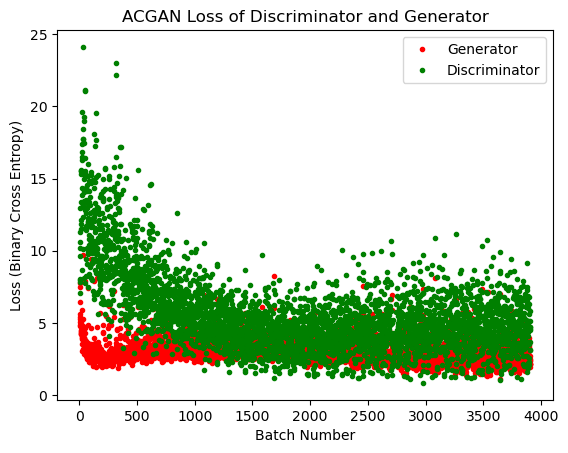

In [1]:
import matplotlib.pyplot as plt
import numpy as np

counter_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 1240, 1241, 1242, 1243, 1244, 1245, 1246, 1247, 1248, 1249, 1250, 1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258, 1259, 1260, 1261, 1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309, 1310, 1311, 1312, 1313, 1314, 1315, 1316, 1317, 1318, 1319, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1327, 1328, 1329, 1330, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349, 1350, 1351, 1352, 1353, 1354, 1355, 1356, 1357, 1358, 1359, 1360, 1361, 1362, 1363, 1364, 1365, 1366, 1367, 1368, 1369, 1370, 1371, 1372, 1373, 1374, 1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429, 1430, 1431, 1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543, 1544, 1545, 1546, 1547, 1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1652, 1653, 1654, 1655, 1656, 1657, 1658, 1659, 1660, 1661, 1662, 1663, 1664, 1665, 1666, 1667, 1668, 1669, 1670, 1671, 1672, 1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681, 1682, 1683, 1684, 1685, 1686, 1687, 1688, 1689, 1690, 1691, 1692, 1693, 1694, 1695, 1696, 1697, 1698, 1699, 1700, 1701, 1702, 1703, 1704, 1705, 1706, 1707, 1708, 1709, 1710, 1711, 1712, 1713, 1714, 1715, 1716, 1717, 1718, 1719, 1720, 1721, 1722, 1723, 1724, 1725, 1726, 1727, 1728, 1729, 1730, 1731, 1732, 1733, 1734, 1735, 1736, 1737, 1738, 1739, 1740, 1741, 1742, 1743, 1744, 1745, 1746, 1747, 1748, 1749, 1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1779, 1780, 1781, 1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791, 1792, 1793, 1794, 1795, 1796, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819, 1820, 1821, 1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860, 1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871, 1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100, 2101, 2102, 2103, 2104, 2105, 2106, 2107, 2108, 2109, 2110, 2111, 2112, 2113, 2114, 2115, 2116, 2117, 2118, 2119, 2120, 2121, 2122, 2123, 2124, 2125, 2126, 2127, 2128, 2129, 2130, 2131, 2132, 2133, 2134, 2135, 2136, 2137, 2138, 2139, 2140, 2141, 2142, 2143, 2144, 2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154, 2155, 2156, 2157, 2158, 2159, 2160, 2161, 2162, 2163, 2164, 2165, 2166, 2167, 2168, 2169, 2170, 2171, 2172, 2173, 2174, 2175, 2176, 2177, 2178, 2179, 2180, 2181, 2182, 2183, 2184, 2185, 2186, 2187, 2188, 2189, 2190, 2191, 2192, 2193, 2194, 2195, 2196, 2197, 2198, 2199, 2200, 2201, 2202, 2203, 2204, 2205, 2206, 2207, 2208, 2209, 2210, 2211, 2212, 2213, 2214, 2215, 2216, 2217, 2218, 2219, 2220, 2221, 2222, 2223, 2224, 2225, 2226, 2227, 2228, 2229, 2230, 2231, 2232, 2233, 2234, 2235, 2236, 2237, 2238, 2239, 2240, 2241, 2242, 2243, 2244, 2245, 2246, 2247, 2248, 2249, 2250, 2251, 2252, 2253, 2254, 2255, 2256, 2257, 2258, 2259, 2260, 2261, 2262, 2263, 2264, 2265, 2266, 2267, 2268, 2269, 2270, 2271, 2272, 2273, 2274, 2275, 2276, 2277, 2278, 2279, 2280, 2281, 2282, 2283, 2284, 2285, 2286, 2287, 2288, 2289, 2290, 2291, 2292, 2293, 2294, 2295, 2296, 2297, 2298, 2299, 2300, 2301, 2302, 2303, 2304, 2305, 2306, 2307, 2308, 2309, 2310, 2311, 2312, 2313, 2314, 2315, 2316, 2317, 2318, 2319, 2320, 2321, 2322, 2323, 2324, 2325, 2326, 2327, 2328, 2329, 2330, 2331, 2332, 2333, 2334, 2335, 2336, 2337, 2338, 2339, 2340, 2341, 2342, 2343, 2344, 2345, 2346, 2347, 2348, 2349, 2350, 2351, 2352, 2353, 2354, 2355, 2356, 2357, 2358, 2359, 2360, 2361, 2362, 2363, 2364, 2365, 2366, 2367, 2368, 2369, 2370, 2371, 2372, 2373, 2374, 2375, 2376, 2377, 2378, 2379, 2380, 2381, 2382, 2383, 2384, 2385, 2386, 2387, 2388, 2389, 2390, 2391, 2392, 2393, 2394, 2395, 2396, 2397, 2398, 2399, 2400, 2401, 2402, 2403, 2404, 2405, 2406, 2407, 2408, 2409, 2410, 2411, 2412, 2413, 2414, 2415, 2416, 2417, 2418, 2419, 2420, 2421, 2422, 2423, 2424, 2425, 2426, 2427, 2428, 2429, 2430, 2431, 2432, 2433, 2434, 2435, 2436, 2437, 2438, 2439, 2440, 2441, 2442, 2443, 2444, 2445, 2446, 2447, 2448, 2449, 2450, 2451, 2452, 2453, 2454, 2455, 2456, 2457, 2458, 2459, 2460, 2461, 2462, 2463, 2464, 2465, 2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510, 2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521, 2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532, 2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543, 2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2553, 2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620, 2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629, 2630, 2631, 2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641, 2642, 2643, 2644, 2645, 2646, 2647, 2648, 2649, 2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 2658, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 2666, 2667, 2668, 2669, 2670, 2671, 2672, 2673, 2674, 2675, 2676, 2677, 2678, 2679, 2680, 2681, 2682, 2683, 2684, 2685, 2686, 2687, 2688, 2689, 2690, 2691, 2692, 2693, 2694, 2695, 2696, 2697, 2698, 2699, 2700, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833, 2834, 2835, 2836, 2837, 2838, 2839, 2840, 2841, 2842, 2843, 2844, 2845, 2846, 2847, 2848, 2849, 2850, 2851, 2852, 2853, 2854, 2855, 2856, 2857, 2858, 2859, 2860, 2861, 2862, 2863, 2864, 2865, 2866, 2867, 2868, 2869, 2870, 2871, 2872, 2873, 2874, 2875, 2876, 2877, 2878, 2879, 2880, 2881, 2882, 2883, 2884, 2885, 2886, 2887, 2888, 2889, 2890, 2891, 2892, 2893, 2894, 2895, 2896, 2897, 2898, 2899, 2900, 2901, 2902, 2903, 2904, 2905, 2906, 2907, 2908, 2909, 2910, 2911, 2912, 2913, 2914, 2915, 2916, 2917, 2918, 2919, 2920, 2921, 2922, 2923, 2924, 2925, 2926, 2927, 2928, 2929, 2930, 2931, 2932, 2933, 2934, 2935, 2936, 2937, 2938, 2939, 2940, 2941, 2942, 2943, 2944, 2945, 2946, 2947, 2948, 2949, 2950, 2951, 2952, 2953, 2954, 2955, 2956, 2957, 2958, 2959, 2960, 2961, 2962, 2963, 2964, 2965, 2966, 2967, 2968, 2969, 2970, 2971, 2972, 2973, 2974, 2975, 2976, 2977, 2978, 2979, 2980, 2981, 2982, 2983, 2984, 2985, 2986, 2987, 2988, 2989, 2990, 2991, 2992, 2993, 2994, 2995, 2996, 2997, 2998, 2999, 3000, 3001, 3002, 3003, 3004, 3005, 3006, 3007, 3008, 3009, 3010, 3011, 3012, 3013, 3014, 3015, 3016, 3017, 3018, 3019, 3020, 3021, 3022, 3023, 3024, 3025, 3026, 3027, 3028, 3029, 3030, 3031, 3032, 3033, 3034, 3035, 3036, 3037, 3038, 3039, 3040, 3041, 3042, 3043, 3044, 3045, 3046, 3047, 3048, 3049, 3050, 3051, 3052, 3053, 3054, 3055, 3056, 3057, 3058, 3059, 3060, 3061, 3062, 3063, 3064, 3065, 3066, 3067, 3068, 3069, 3070, 3071, 3072, 3073, 3074, 3075, 3076, 3077, 3078, 3079, 3080, 3081, 3082, 3083, 3084, 3085, 3086, 3087, 3088, 3089, 3090, 3091, 3092, 3093, 3094, 3095, 3096, 3097, 3098, 3099, 3100, 3101, 3102, 3103, 3104, 3105, 3106, 3107, 3108, 3109, 3110, 3111, 3112, 3113, 3114, 3115, 3116, 3117, 3118, 3119, 3120, 3121, 3122, 3123, 3124, 3125, 3126, 3127, 3128, 3129, 3130, 3131, 3132, 3133, 3134, 3135, 3136, 3137, 3138, 3139, 3140, 3141, 3142, 3143, 3144, 3145, 3146, 3147, 3148, 3149, 3150, 3151, 3152, 3153, 3154, 3155, 3156, 3157, 3158, 3159, 3160, 3161, 3162, 3163, 3164, 3165, 3166, 3167, 3168, 3169, 3170, 3171, 3172, 3173, 3174, 3175, 3176, 3177, 3178, 3179, 3180, 3181, 3182, 3183, 3184, 3185, 3186, 3187, 3188, 3189, 3190, 3191, 3192, 3193, 3194, 3195, 3196, 3197, 3198, 3199, 3200, 3201, 3202, 3203, 3204, 3205, 3206, 3207, 3208, 3209, 3210, 3211, 3212, 3213, 3214, 3215, 3216, 3217, 3218, 3219, 3220, 3221, 3222, 3223, 3224, 3225, 3226, 3227, 3228, 3229, 3230, 3231, 3232, 3233, 3234, 3235, 3236, 3237, 3238, 3239, 3240, 3241, 3242, 3243, 3244, 3245, 3246, 3247, 3248, 3249, 3250, 3251, 3252, 3253, 3254, 3255, 3256, 3257, 3258, 3259, 3260, 3261, 3262, 3263, 3264, 3265, 3266, 3267, 3268, 3269, 3270, 3271, 3272, 3273, 3274, 3275, 3276, 3277, 3278, 3279, 3280, 3281, 3282, 3283, 3284, 3285, 3286, 3287, 3288, 3289, 3290, 3291, 3292, 3293, 3294, 3295, 3296, 3297, 3298, 3299, 3300, 3301, 3302, 3303, 3304, 3305, 3306, 3307, 3308, 3309, 3310, 3311, 3312, 3313, 3314, 3315, 3316, 3317, 3318, 3319, 3320, 3321, 3322, 3323, 3324, 3325, 3326, 3327, 3328, 3329, 3330, 3331, 3332, 3333, 3334, 3335, 3336, 3337, 3338, 3339, 3340, 3341, 3342, 3343, 3344, 3345, 3346, 3347, 3348, 3349, 3350, 3351, 3352, 3353, 3354, 3355, 3356, 3357, 3358, 3359, 3360, 3361, 3362, 3363, 3364, 3365, 3366, 3367, 3368, 3369, 3370, 3371, 3372, 3373, 3374, 3375, 3376, 3377, 3378, 3379, 3380, 3381, 3382, 3383, 3384, 3385, 3386, 3387, 3388, 3389, 3390, 3391, 3392, 3393, 3394, 3395, 3396, 3397, 3398, 3399, 3400, 3401, 3402, 3403, 3404, 3405, 3406, 3407, 3408, 3409, 3410, 3411, 3412, 3413, 3414, 3415, 3416, 3417, 3418, 3419, 3420, 3421, 3422, 3423, 3424, 3425, 3426, 3427, 3428, 3429, 3430, 3431, 3432, 3433, 3434, 3435, 3436, 3437, 3438, 3439, 3440, 3441, 3442, 3443, 3444, 3445, 3446, 3447, 3448, 3449, 3450, 3451, 3452, 3453, 3454, 3455, 3456, 3457, 3458, 3459, 3460, 3461, 3462, 3463, 3464, 3465, 3466, 3467, 3468, 3469, 3470, 3471, 3472, 3473, 3474, 3475, 3476, 3477, 3478, 3479, 3480, 3481, 3482, 3483, 3484, 3485, 3486, 3487, 3488, 3489, 3490, 3491, 3492, 3493, 3494, 3495, 3496, 3497, 3498, 3499, 3500, 3501, 3502, 3503, 3504, 3505, 3506, 3507, 3508, 3509, 3510, 3511, 3512, 3513, 3514, 3515, 3516, 3517, 3518, 3519, 3520, 3521, 3522, 3523, 3524, 3525, 3526, 3527, 3528, 3529, 3530, 3531, 3532, 3533, 3534, 3535, 3536, 3537, 3538, 3539, 3540, 3541, 3542, 3543, 3544, 3545, 3546, 3547, 3548, 3549, 3550, 3551, 3552, 3553, 3554, 3555, 3556, 3557, 3558, 3559, 3560, 3561, 3562, 3563, 3564, 3565, 3566, 3567, 3568, 3569, 3570, 3571, 3572, 3573, 3574, 3575, 3576, 3577, 3578, 3579, 3580, 3581, 3582, 3583, 3584, 3585, 3586, 3587, 3588, 3589, 3590, 3591, 3592, 3593, 3594, 3595, 3596, 3597, 3598, 3599, 3600, 3601, 3602, 3603, 3604, 3605, 3606, 3607, 3608, 3609, 3610, 3611, 3612, 3613, 3614, 3615, 3616, 3617, 3618, 3619, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627, 3628, 3629, 3630, 3631, 3632, 3633, 3634, 3635, 3636, 3637, 3638, 3639, 3640, 3641, 3642, 3643, 3644, 3645, 3646, 3647, 3648, 3649, 3650, 3651, 3652, 3653, 3654, 3655, 3656, 3657, 3658, 3659, 3660, 3661, 3662, 3663, 3664, 3665, 3666, 3667, 3668, 3669, 3670, 3671, 3672, 3673, 3674, 3675, 3676, 3677, 3678, 3679, 3680, 3681, 3682, 3683, 3684, 3685, 3686, 3687, 3688, 3689, 3690, 3691, 3692, 3693, 3694, 3695, 3696, 3697, 3698, 3699, 3700, 3701, 3702, 3703, 3704, 3705, 3706, 3707, 3708, 3709, 3710, 3711, 3712, 3713, 3714, 3715, 3716, 3717, 3718, 3719, 3720, 3721, 3722, 3723, 3724, 3725, 3726, 3727, 3728, 3729, 3730, 3731, 3732, 3733, 3734, 3735, 3736, 3737, 3738, 3739, 3740, 3741, 3742, 3743, 3744, 3745, 3746, 3747, 3748, 3749, 3750, 3751, 3752, 3753, 3754, 3755, 3756, 3757, 3758, 3759, 3760, 3761, 3762, 3763, 3764, 3765, 3766, 3767, 3768, 3769, 3770, 3771, 3772, 3773, 3774, 3775, 3776, 3777, 3778, 3779, 3780, 3781, 3782, 3783, 3784, 3785, 3786, 3787, 3788, 3789, 3790, 3791, 3792, 3793, 3794, 3795, 3796, 3797, 3798, 3799, 3800, 3801, 3802, 3803, 3804, 3805, 3806, 3807, 3808, 3809, 3810, 3811, 3812, 3813, 3814, 3815, 3816, 3817, 3818, 3819, 3820, 3821, 3822, 3823, 3824, 3825, 3826, 3827, 3828, 3829, 3830, 3831, 3832, 3833, 3834, 3835, 3836, 3837, 3838, 3839, 3840, 3841, 3842, 3843, 3844, 3845, 3846, 3847, 3848, 3849, 3850, 3851, 3852, 3853, 3854, 3855, 3856, 3857, 3858, 3859, 3860, 3861, 3862, 3863, 3864, 3865, 3866, 3867, 3868, 3869, 3870, 3871, 3872, 3873, 3874, 3875, 3876, 3877, 3878, 3879, 3880, 3881, 3882, 3883, 3884, 3885, 3886, 3887, 3888, 3889, 3890, 3891, 3892, 3893, 3894, 3895, 3896, 3897, 3898, 3899, 3900, 3901, 3902, 3903, 3904, 3905, 3906, 3907, 3908, 3909, 3910]
dis_loss_list = [7.080898, 8.032092, 8.000271, 7.8206015, 9.658305, 10.1610775, 11.316208, 12.9486885, 10.593121, 11.821781, 12.144609, 15.528467, 11.511974, 13.403284, 15.303799, 15.495697, 15.621254, 17.365116, 13.828805, 16.487131, 13.060513, 19.621172, 14.3780575, 16.313831, 16.841093, 8.665791, 16.437302, 24.119324, 18.437033, 10.144043, 15.333101, 17.739822, 12.361376, 13.10041, 17.766512, 14.234454, 13.425192, 18.991959, 14.08363, 14.988493, 19.25819, 17.492958, 8.097751, 21.118069, 21.06715, 15.553828, 14.259665, 16.439642, 11.566462, 12.834711, 7.779766, 15.21827, 14.348154, 8.284696, 13.498831, 12.603297, 11.4603615, 15.279405, 11.733103, 9.419829, 14.369847, 15.162861, 9.080692, 12.954836, 14.137547, 11.620017, 13.273982, 14.520697, 10.204329, 12.055262, 11.987117, 15.994526, 11.917164, 9.743152, 15.170666, 7.505338, 9.896599, 12.23349, 11.121113, 8.396985, 10.213112, 13.355656, 10.429897, 8.269023, 14.809311, 14.129834, 10.786707, 11.976433, 10.446151, 8.941356, 12.106121, 13.732464, 8.868337, 12.625614, 13.146399, 11.655567, 15.212721, 15.486481, 10.59063, 14.698338, 9.051514, 10.95097, 11.927038, 8.087319, 9.147948, 10.134279, 10.620613, 11.737358, 9.836472, 7.9469175, 10.019241, 12.660019, 9.139586, 7.2159786, 14.879929, 14.903144, 12.240442, 12.055464, 9.435959, 9.19465, 10.427109, 14.377769, 10.687122, 6.674272, 18.08807, 12.082943, 12.312038, 12.812319, 9.34115, 6.966683, 14.774948, 17.282532, 13.334282, 8.6327505, 11.486686, 11.58996, 10.375275, 11.296827, 9.439764, 9.307409, 9.771123, 15.139009, 10.045813, 8.474614, 19.528028, 17.658884, 12.621707, 10.098749, 10.221925, 12.756653, 7.010176, 12.865411, 13.009903, 9.392112, 8.481094, 9.828329, 12.043353, 12.72451, 8.935058, 10.579248, 10.857885, 12.954638, 7.1102514, 15.252745, 5.599616, 11.475172, 12.563078, 11.886442, 9.261633, 8.413875, 8.912686, 12.150371, 8.118903, 7.664653, 13.755514, 7.934237, 7.3490934, 10.743058, 7.648042, 9.604125, 9.45125, 11.060825, 8.972644, 6.37741, 13.938911, 10.828701, 9.183957, 9.60347, 8.958477, 8.63496, 8.46333, 11.758423, 9.413176, 6.815306, 12.635956, 10.68108, 9.610345, 11.481026, 9.543943, 8.277275, 6.583447, 13.461676, 6.338824, 13.546838, 14.95873, 14.142215, 13.687971, 13.577851, 12.299004, 10.128162, 8.430338, 11.195846, 10.735425, 8.056793, 10.986859, 11.158208, 10.61571, 10.439348, 8.032175, 9.579917, 8.05778, 15.650912, 5.6191998, 15.740244, 14.270907, 9.655664, 9.046239, 11.092306, 8.971497, 7.9718504, 8.782821, 10.298181, 10.016581, 6.278488, 10.041851, 10.338022, 10.311361, 11.767052, 8.0224285, 6.3370094, 12.862614, 13.045283, 8.128473, 6.5414405, 11.462591, 11.331109, 10.741531, 11.311988, 8.557491, 8.117283, 5.285343, 14.975805, 4.064694, 15.1786175, 13.600476, 12.41437, 10.44773, 10.620394, 8.808279, 8.2327175, 9.313001, 10.606375, 8.855015, 6.3138785, 14.274538, 10.124552, 8.15159, 13.127153, 10.2807, 7.270775, 8.730862, 12.346112, 8.962028, 5.117539, 10.374654, 8.786722, 9.405628, 10.334213, 7.0319986, 8.830716, 10.418671, 11.135109, 8.247152, 5.917015, 10.361156, 10.362871, 10.389698, 12.010731, 8.375559, 7.257721, 11.553516, 11.463723, 8.410161, 6.5768285, 12.098645, 8.400127, 10.116632, 11.1158, 7.7734632, 14.165169, 5.732186, 14.41059, 15.808552, 11.751952, 8.642777, 11.435233, 12.526784, 11.942475, 9.525889, 10.829672, 8.973219, 13.283709, 8.920036, 9.392585, 16.49054, 7.9295273, 23.030113, 22.180246, 13.830081, 8.438056, 13.734857, 14.717941, 9.176478, 13.915567, 13.827786, 9.0945015, 10.921683, 13.418088, 10.706192, 10.278873, 9.446345, 12.966492, 11.382675, 7.99537, 13.725681, 13.650227, 11.143995, 11.16305, 9.411021, 9.040027, 8.91867, 12.715294, 9.613746, 6.216833, 15.19926, 12.909575, 8.522547, 11.866975, 10.832312, 8.40474, 8.943915, 15.88242, 9.674515, 5.1716228, 17.193956, 17.16823, 13.9022455, 11.830681, 9.047197, 10.005423, 9.783688, 10.645784, 8.357099, 5.6637497, 9.676341, 9.635664, 9.900483, 8.202213, 9.179362, 8.1398945, 9.903672, 7.4450073, 8.7665, 6.3382554, 14.203656, 3.2570207, 10.79567, 10.790401, 7.322165, 6.9965267, 8.300922, 9.318091, 7.066806, 7.1053743, 8.498064, 7.6166205, 8.755355, 10.157853, 7.5017734, 8.066198, 8.68938, 5.4325266, 11.463708, 5.648669, 6.593134, 9.268767, 8.355125, 9.0362, 9.964441, 4.848959, 15.004698, 5.1921306, 8.071421, 8.422413, 6.3803864, 7.2782145, 7.5580597, 8.022032, 7.4933424, 6.186473, 9.7227125, 6.9856524, 7.3170557, 7.86575, 6.055191, 9.653538, 5.302233, 9.391887, 8.24381, 7.38958, 10.73587, 4.3262815, 9.194348, 8.31325, 5.5475826, 7.468946, 9.266239, 8.204265, 8.490564, 6.1517153, 8.02396, 6.0352454, 9.358507, 5.753519, 6.7158837, 8.215173, 6.291632, 9.341977, 10.232744, 4.73518, 11.835037, 6.7250195, 5.488857, 8.625415, 7.1145, 7.54479, 7.6597786, 8.3192005, 8.244328, 5.6913066, 11.693416, 5.9963565, 11.5253525, 7.09762, 6.7507057, 11.302713, 8.547884, 7.366639, 11.577838, 7.7314134, 8.120221, 9.360822, 8.780478, 6.4336805, 10.968656, 7.9851727, 7.296884, 10.834906, 6.6194067, 9.5757675, 8.334099, 7.8557367, 11.721539, 2.935405, 12.1397, 8.052845, 7.0766954, 13.668215, 8.33114, 6.64612, 10.384513, 7.2855043, 11.275757, 5.6059422, 10.084517, 8.893163, 9.274762, 8.041596, 10.588172, 7.971356, 8.558523, 6.555386, 9.644092, 3.933415, 12.150516, 10.856325, 7.215936, 9.16849, 8.863703, 7.124309, 8.098114, 6.434385, 11.719146, 7.772007, 8.174734, 7.9198227, 8.444257, 6.154027, 15.600218, 4.49093, 8.352578, 6.7558327, 6.6060734, 7.5009203, 5.4556146, 8.419165, 5.3489604, 7.357583, 7.4169736, 6.509169, 6.812408, 6.1234207, 8.183225, 5.679261, 8.749887, 7.5136065, 7.644308, 9.472813, 8.147519, 6.6706753, 9.602192, 4.3119183, 10.423609, 6.8218555, 6.2468586, 8.532079, 7.915596, 7.7285447, 8.64503, 5.669522, 11.500519, 6.2292013, 6.601859, 8.316161, 6.0794797, 7.429383, 9.47065, 7.1480837, 8.74037, 5.070818, 8.527177, 5.657485, 10.159317, 3.353614, 12.870147, 5.968861, 5.4996643, 10.598223, 7.3857718, 8.074982, 7.128299, 6.2881947, 12.822265, 3.6110065, 8.652082, 7.2527127, 6.3561664, 8.947855, 5.5665913, 7.985157, 6.844754, 4.428374, 10.043742, 6.5317116, 6.779059, 8.243611, 7.093541, 7.2944508, 7.618454, 5.9277816, 8.950074, 4.4417486, 9.533297, 4.5452185, 6.5372057, 6.9025154, 7.959629, 8.229288, 8.750267, 6.138833, 8.175827, 5.7478456, 7.0632415, 6.738175, 7.401876, 9.220471, 5.1011624, 13.15803, 8.372358, 7.375352, 10.308881, 9.085457, 11.350857, 6.7011614, 10.365987, 11.257817, 8.526884, 10.859972, 6.4253225, 14.541496, 8.473097, 8.698098, 11.842822, 6.877308, 7.94166, 9.28423, 4.6043477, 14.609766, 4.313007, 9.370254, 6.714331, 8.370582, 7.3453107, 7.8131075, 6.2446837, 11.355444, 4.9876957, 11.727148, 11.389632, 4.3604555, 9.025308, 7.0586414, 5.934417, 7.997489, 2.8632178, 10.807405, 7.5469475, 4.8040667, 8.453009, 7.7979946, 6.8684106, 5.1987104, 7.2522945, 4.999286, 6.0660605, 7.0648627, 7.6277475, 7.42128, 7.472411, 6.411574, 6.8575106, 6.1681185, 8.892519, 7.4738016, 3.4599285, 9.579859, 9.014372, 6.1185803, 6.97411, 8.597202, 2.950598, 7.871235, 8.677729, 5.4009256, 5.5141454, 7.3535476, 6.139882, 6.606944, 7.0318766, 5.1697826, 8.07953, 5.371914, 11.238046, 4.9623938, 4.4206915, 8.723527, 7.2821608, 5.66438, 9.326847, 5.4636784, 7.911468, 4.587164, 9.593815, 5.1209097, 5.8036795, 8.040497, 5.39167, 6.6510954, 8.949949, 3.8138747, 7.313311, 5.2646375, 5.462162, 5.146303, 6.4977665, 5.312014, 5.026182, 7.0418177, 5.7394266, 6.3120728, 5.2142634, 6.1090994, 6.60851, 5.2242336, 7.1212435, 6.6718616, 6.539382, 7.3761063, 7.7528934, 3.7757587, 9.745874, 5.0683684, 8.998378, 6.5287466, 4.874971, 8.770385, 4.4612007, 6.9308543, 6.676387, 4.5071626, 9.921047, 5.8907256, 6.4138174, 6.8409305, 5.5010066, 6.671272, 5.823867, 7.382513, 7.521247, 5.7478213, 6.982966, 5.0735626, 9.283924, 6.0588613, 8.441927, 6.503119, 6.473673, 7.441745, 6.445139, 5.0440187, 8.228545, 4.1132402, 7.562219, 6.0284657, 5.28151, 7.547184, 7.166213, 6.04056, 8.909679, 3.382093, 10.770016, 5.4751787, 7.1729355, 6.2569947, 4.845913, 7.483782, 4.649646, 7.338212, 8.762619, 5.584302, 7.6045218, 6.235373, 7.252796, 4.637403, 6.951091, 6.0892706, 6.8352747, 5.664747, 9.924944, 3.7402446, 10.031521, 5.306175, 9.77614, 4.900856, 6.9370546, 5.830339, 6.023904, 7.783242, 6.5347505, 6.975711, 6.326797, 5.8317747, 4.8105, 8.283505, 4.5653677, 7.3513865, 6.1111603, 4.945107, 8.127193, 5.126905, 5.220849, 6.129771, 5.464524, 7.2587905, 5.0703583, 5.80737, 6.995038, 5.2864156, 7.162025, 6.166341, 4.4580026, 8.117176, 2.8562038, 10.546272, 5.578477, 5.23524, 7.0569463, 4.3322864, 7.121994, 6.8952847, 4.097917, 6.30974, 6.013506, 8.10265, 4.182872, 5.6013207, 7.341688, 5.109322, 6.128044, 7.923773, 3.7571664, 7.3774843, 5.721439, 8.484732, 3.7342095, 6.702914, 5.8983464, 6.2230477, 5.83587, 7.3103266, 5.5748777, 6.4270854, 3.8601098, 8.72485, 3.7861013, 5.6006236, 7.928485, 4.350834, 8.441854, 5.9193773, 3.9367385, 7.645505, 3.1797369, 12.583936, 3.9905658, 5.934615, 6.386656, 6.149132, 5.4048233, 6.986018, 4.3966084, 7.186631, 5.1988306, 5.7914605, 6.2253513, 4.9122996, 5.5737944, 6.4495144, 4.209407, 8.574997, 4.092262, 5.0335336, 5.8536587, 6.6376863, 4.4864964, 4.435707, 8.08243, 4.2468314, 7.49634, 6.9833374, 3.630799, 8.00001, 4.3654184, 6.608314, 4.5904655, 5.2631207, 7.0475254, 5.6106176, 6.9948907, 6.156322, 4.27892, 7.311554, 4.528142, 7.94976, 3.8957534, 6.33977, 6.2508636, 5.6330714, 6.6493387, 5.7651043, 5.3492026, 6.656659, 4.6238356, 7.073149, 3.4949214, 8.817771, 4.937976, 5.687523, 7.100076, 4.961424, 6.7707143, 2.85325, 9.604057, 4.067168, 6.640203, 4.1004915, 6.3967175, 4.9093304, 5.9663744, 5.6073713, 3.9722967, 8.234532, 4.201168, 7.030059, 5.339936, 3.1812918, 5.983324, 6.3651433, 5.6405497, 6.3825445, 5.0368085, 7.3714523, 2.989466, 10.57118, 5.758217, 4.418854, 8.070283, 5.961966, 4.201523, 9.493272, 5.070053, 3.92306, 5.6248727, 5.3432055, 2.8905199, 6.8851047, 4.3856525, 7.102298, 5.734102, 7.1960135, 4.234049, 8.548507, 2.9940915, 8.617496, 4.4836826, 8.6342325, 4.874197, 5.784752, 6.9632454, 6.077847, 5.5298615, 4.5358295, 6.9241796, 5.1064415, 6.3566475, 5.2964134, 4.5601764, 7.6041374, 4.2745733, 7.7697425, 5.9776325, 4.534873, 5.471015, 6.737052, 2.9418173, 6.286703, 3.6076262, 9.898394, 3.8147306, 5.3432045, 5.716299, 4.5174923, 5.9115725, 5.592008, 5.6111364, 4.515402, 5.0975947, 4.2026396, 4.905325, 6.196777, 4.5119123, 5.687761, 3.4871166, 7.958544, 2.7502894, 5.0477486, 4.238094, 6.1885934, 4.8986835, 6.0780125, 5.3599706, 4.8044286, 5.622986, 6.9292827, 4.5673676, 4.409342, 5.8971615, 6.0524035, 5.8689265, 7.1160736, 5.0271673, 8.389719, 3.5291693, 9.9216795, 3.3924108, 10.091071, 5.914596, 6.035846, 5.8859425, 5.472645, 5.868105, 5.841591, 5.7174187, 7.8780527, 3.8269582, 5.393539, 6.355984, 4.1820507, 6.78558, 7.096124, 3.8201573, 6.7154503, 5.3870707, 6.0808983, 4.682656, 5.6428313, 7.7023115, 6.3075924, 7.032426, 7.3238573, 4.250888, 7.6851177, 4.004092, 8.930876, 3.350249, 6.6859856, 6.617415, 4.8010945, 8.142875, 3.9546359, 7.1845694, 4.3956375, 7.191792, 5.8957663, 4.128391, 7.386031, 5.088633, 4.8205976, 7.0415745, 7.1680813, 4.405564, 8.080338, 3.8509307, 8.134131, 4.651122, 4.436906, 5.7219915, 4.7720323, 5.4567556, 4.9323664, 4.6736674, 6.085118, 4.16342, 7.066788, 4.3973575, 5.2328305, 5.187497, 6.553952, 5.103196, 6.3603063, 3.7144423, 8.133291, 3.5586343, 8.206237, 3.2721028, 6.6660714, 4.7806745, 6.784395, 4.024267, 8.661196, 3.31696, 7.338599, 1.7724849, 10.507244, 2.5091324, 5.472434, 6.652973, 4.922249, 6.56925, 6.0049357, 3.769934, 7.639698, 2.9316459, 8.325787, 4.365309, 4.4431734, 6.2837443, 5.7713776, 6.247831, 7.4030695, 4.2416134, 5.647492, 4.420963, 7.581797, 3.6799173, 5.5291967, 5.5600467, 4.3424964, 6.20607, 4.9616127, 4.3113666, 6.9167776, 5.004176, 7.190791, 3.8596807, 5.3129797, 6.299425, 4.66709, 5.0893, 7.6175146, 4.103075, 4.4633875, 4.542425, 6.66767, 2.422624, 6.5065413, 3.379918, 8.215333, 3.8893669, 7.100791, 4.746439, 6.556072, 4.4201593, 6.605376, 4.7576423, 5.6754956, 6.8951187, 5.792451, 7.009426, 5.8050594, 4.8689623, 5.6179457, 5.5497656, 6.0880375, 4.8848963, 5.6551046, 6.8722315, 3.8336606, 8.374111, 4.3133593, 5.4638586, 4.500978, 4.3299513, 6.788606, 3.2286808, 5.5659857, 4.6738014, 4.7672405, 5.256969, 4.1414685, 6.3086348, 3.7994914, 4.9602857, 6.3323383, 3.6495862, 4.673276, 5.6874638, 3.6739652, 6.860773, 4.3948803, 5.4355984, 4.4830317, 4.7162952, 4.845244, 5.365679, 3.79774, 5.400344, 4.92669, 3.8762653, 7.1500783, 4.6055803, 4.7014236, 4.3119154, 4.936116, 5.849443, 3.592778, 6.3042116, 3.0931306, 9.048325, 2.2621973, 8.959603, 2.1486044, 5.727139, 3.2202792, 4.727314, 3.256822, 4.0763116, 4.5017285, 4.2285776, 5.375826, 4.0487666, 3.7811227, 5.0105343, 4.362178, 6.0402184, 3.9618516, 4.542699, 4.715768, 5.0110064, 5.46269, 5.224893, 3.9166956, 6.602355, 3.3974466, 6.6534986, 4.9630766, 2.9510732, 6.915642, 3.8084688, 7.289445, 4.003026, 6.3395567, 4.0145097, 3.867681, 7.275305, 3.7884083, 4.367667, 6.0507317, 4.0786304, 6.084451, 5.677126, 4.6727896, 4.988339, 3.708835, 7.2405868, 3.7760217, 4.5838714, 6.682064, 4.369565, 6.367156, 4.7085686, 5.838968, 5.5235014, 4.80766, 7.594147, 4.358637, 5.0224943, 4.4584713, 6.11849, 5.1561365, 6.1490006, 2.8340936, 5.4705143, 4.1737328, 5.9839354, 3.1950417, 4.0554647, 5.665079, 3.3971572, 6.0144634, 5.2045565, 3.8208094, 4.720696, 4.1385803, 6.391357, 3.402689, 5.811404, 3.9163828, 6.358821, 4.3093777, 6.3066354, 3.011227, 6.770602, 2.3316493, 6.572571, 3.1070812, 5.979556, 3.5496902, 4.467534, 5.6480207, 4.370271, 4.0651865, 5.856245, 2.149869, 6.9042006, 3.0950565, 5.8111706, 3.434301, 4.8535886, 5.477071, 5.124985, 3.3021748, 5.8914547, 2.5072935, 8.058694, 1.6131334, 5.937948, 4.597366, 2.8799767, 6.829886, 2.4786878, 5.6784754, 3.15087, 4.2167797, 5.915399, 3.279456, 4.3242264, 4.7663693, 3.963198, 6.594648, 4.444066, 4.6184053, 5.4740267, 3.377649, 7.209616, 3.3441706, 4.952448, 5.348221, 4.283333, 4.732428, 6.342032, 3.6934752, 5.7450304, 2.2881463, 6.9112415, 2.6268601, 5.55079, 3.6297786, 6.0501246, 3.8336294, 5.330842, 4.166329, 5.1777306, 3.6686954, 5.709923, 3.7072964, 4.1000395, 5.3246145, 3.9537363, 4.9909315, 5.0934744, 2.9195056, 5.848917, 3.3249917, 5.657812, 3.2525148, 4.4136724, 5.758788, 3.3462195, 5.163764, 4.2964516, 5.319066, 4.1144576, 4.880153, 4.962938, 4.0442214, 4.5079665, 5.241143, 4.409036, 7.2683992, 3.9182556, 5.581361, 3.59796, 4.6266756, 5.2506294, 2.5902746, 5.7043734, 2.9240263, 5.9073625, 3.5041692, 7.312353, 2.766358, 5.55038, 3.8151288, 5.4595246, 3.5681622, 3.772863, 3.9138312, 4.5651703, 4.29908, 6.250343, 3.4134605, 5.853291, 2.9200816, 5.9550953, 2.8777223, 3.9613817, 5.7439475, 2.8696752, 6.313567, 3.4861505, 4.9797573, 4.141285, 3.8043203, 6.2623167, 2.23312, 6.38456, 2.1140938, 6.2297416, 3.4987373, 4.565303, 3.5065854, 4.2247744, 3.2284787, 5.580161, 3.0523567, 3.9025419, 5.198391, 3.2424135, 6.2438188, 3.3639576, 5.291544, 4.141688, 3.6197412, 6.900541, 2.6162877, 5.5962133, 2.8836975, 5.5206614, 3.825571, 6.177255, 2.4070954, 6.5401726, 2.4039087, 6.4763966, 2.5789704, 3.7424817, 4.6725445, 4.7271886, 4.4863243, 5.115237, 2.8085465, 6.4567194, 2.3127828, 7.122194, 1.5975684, 8.644804, 1.7109802, 6.7998977, 3.8457606, 4.375104, 4.0075636, 4.0101156, 4.184451, 5.6615334, 2.4752326, 4.7967806, 3.8768687, 3.7833593, 4.6598005, 4.675788, 3.09088, 5.02456, 3.3294284, 5.6290045, 3.4819057, 3.5360436, 5.3455, 3.376573, 5.4693346, 4.501875, 4.5417805, 4.1860113, 4.0433993, 5.766315, 3.743447, 3.643272, 5.1956825, 4.24936, 4.3578835, 5.2616043, 2.9042838, 5.2604218, 2.497159, 6.1276264, 2.7646348, 6.233681, 1.9890276, 7.619134, 3.0295887, 5.260948, 3.8421378, 3.913992, 4.1690936, 5.6897755, 2.8214445, 4.213082, 4.339251, 4.198286, 4.813178, 5.3194394, 3.3517015, 5.737243, 3.9351587, 5.66871, 3.0821087, 4.143242, 4.952457, 2.4322858, 6.5157676, 3.4891346, 6.3700585, 2.021978, 5.6975574, 4.2174582, 3.4883156, 4.0171747, 5.2022924, 3.3941426, 5.796654, 4.618888, 3.4968588, 5.3413982, 2.5981183, 5.613886, 2.9262433, 5.20292, 4.0488377, 4.512145, 4.122903, 6.067788, 3.4215353, 5.9213886, 1.9223568, 6.9268174, 1.4972475, 6.2154284, 3.5349033, 5.189755, 4.105317, 5.4645967, 3.3730342, 5.656128, 2.9024682, 5.5844336, 3.1559415, 3.4159317, 4.9293633, 3.6334682, 5.076222, 5.1261115, 3.148417, 4.4589148, 3.0153537, 6.3610897, 2.9909382, 4.3499575, 5.3178787, 3.2883549, 5.846476, 4.607007, 3.5210557, 4.61043, 2.9700894, 6.520089, 2.3889751, 4.2858553, 2.990044, 4.803964, 4.60724, 4.7898397, 3.3342655, 4.5649977, 3.339379, 3.8506575, 5.403051, 2.4738407, 4.1878366, 3.9118822, 4.713497, 4.55981, 5.6891336, 2.4413486, 5.321811, 3.4975708, 5.5208764, 1.740536, 5.0063066, 3.2069333, 5.6149635, 2.223895, 9.729179, 2.2750807, 4.7326727, 3.792901, 4.921674, 2.8953316, 4.4462967, 3.5335288, 5.3036337, 3.9365542, 4.1554594, 4.4981804, 3.7966695, 3.8389401, 5.2421837, 3.1172752, 4.255983, 4.535775, 3.5154612, 4.9720764, 5.420853, 3.0750551, 5.6417537, 2.881186, 7.311646, 1.7475822, 7.384582, 2.7009463, 5.843974, 4.1340647, 6.5272784, 2.5327816, 5.452338, 2.0137365, 6.938254, 3.9809968, 3.0377162, 5.0119085, 3.5871155, 5.133476, 4.550507, 3.6045308, 5.6425343, 2.8545413, 6.360725, 3.549192, 3.651783, 5.01783, 3.8145318, 5.3695803, 4.4909067, 3.8512774, 4.8116255, 2.5727413, 7.4984226, 2.4560986, 6.7904778, 3.3625948, 4.651477, 4.7954583, 4.552437, 3.7728667, 4.901505, 2.598834, 6.180151, 3.1674137, 4.2153726, 4.959047, 3.11211, 4.9241724, 4.829357, 3.2430854, 5.9124637, 3.3525598, 5.439081, 2.5989356, 5.021476, 4.209054, 4.248999, 3.956174, 4.841903, 2.738484, 5.8819065, 2.7634256, 4.837412, 4.557495, 3.0760925, 5.109663, 3.3307865, 4.955086, 4.1864963, 3.7771702, 3.7105715, 4.236551, 5.706196, 2.5407968, 4.7709093, 3.9575787, 4.833329, 2.802671, 7.7704315, 1.9394019, 6.206763, 1.1671273, 7.2662144, 2.5779908, 2.716735, 4.649724, 2.6130576, 4.560281, 3.171223, 3.6925979, 3.3161795, 4.137407, 3.1553838, 4.285768, 1.6793029, 7.014116, 2.9828656, 4.874298, 4.729431, 2.99039, 4.2040668, 4.4635344, 4.797752, 2.978966, 4.7658577, 4.672279, 3.775031, 5.0526514, 5.0109453, 3.6115696, 4.081703, 3.5594883, 5.29506, 3.1138933, 4.1936903, 4.3755393, 4.98826, 4.2477417, 5.3609366, 2.6193557, 5.4089518, 2.3660595, 7.9406595, 1.8953007, 6.5353355, 1.5650382, 5.9023056, 3.2881892, 4.2087164, 3.7419417, 4.0728655, 3.071599, 4.7401137, 2.4916072, 3.9575956, 4.6335096, 3.616036, 4.0890093, 4.234764, 3.9562833, 3.5713677, 3.6474857, 5.455133, 3.1191082, 3.0815704, 5.21467, 3.3560405, 4.4016867, 5.472941, 4.044878, 4.728567, 2.695972, 6.452598, 1.9935043, 6.1978188, 2.5151994, 5.412751, 3.2024152, 5.7813807, 2.7139072, 4.8569536, 3.2366564, 4.3621826, 2.9943922, 3.4047353, 4.5258436, 3.302729, 4.728334, 5.47064, 2.3844342, 5.0549903, 2.8263555, 5.8899164, 1.9848127, 5.1257496, 2.2910945, 5.845384, 3.095744, 5.047535, 2.7355905, 5.120623, 2.9401205, 4.7957506, 3.925633, 2.7935655, 5.0319786, 3.2735784, 4.1319685, 4.6203127, 3.1272147, 5.1673126, 2.4098458, 6.8088727, 2.0369864, 6.06633, 2.129142, 6.3762283, 2.6490483, 5.100581, 2.6419299, 5.00856, 3.5645657, 4.802323, 3.0084922, 3.8712788, 3.8692179, 4.7024956, 3.5785232, 4.416252, 4.4239693, 3.6690836, 4.400976, 3.304886, 3.4376051, 3.7724042, 4.6238475, 5.0721006, 3.2689223, 6.25474, 2.3520353, 7.200943, 1.636146, 7.2406425, 1.5652175, 4.7464304, 3.2738078, 3.9343176, 4.2160854, 4.516736, 2.8145947, 5.0357294, 3.0406194, 4.5409455, 3.7491899, 3.4220173, 4.8750796, 3.48553, 4.333785, 4.4016066, 2.8229573, 4.6368637, 3.2785027, 5.9898186, 2.6086154, 4.6067953, 3.0597167, 5.2176404, 3.3784447, 5.7456083, 2.7181728, 5.9178305, 2.0718508, 6.6908913, 1.7185249, 6.6703444, 1.8502738, 4.2309546, 3.095533, 5.3473406, 2.3053288, 4.551516, 2.577354, 4.221699, 3.2764611, 2.8188987, 4.589837, 3.425245, 4.0972867, 4.501436, 3.0797453, 4.5602107, 2.319044, 7.347237, 2.8348994, 4.310503, 4.9400415, 3.351117, 4.608298, 5.1812, 2.83097, 4.948827, 2.5845213, 5.7992177, 2.5983713, 7.693151, 3.566765, 3.7903404, 3.8006997, 3.8053284, 3.3317304, 4.5426884, 3.1556878, 5.788892, 2.465025, 4.751575, 5.2097697, 3.438294, 4.6537056, 4.1964154, 4.3553257, 4.0087776, 3.984484, 5.7219563, 2.4798565, 5.349368, 2.6527941, 6.2043943, 3.4590995, 6.744708, 2.456255, 5.723611, 2.213502, 5.8276825, 2.3756576, 3.8188515, 3.647286, 3.4727128, 4.4857826, 4.2679076, 2.791542, 5.143363, 3.026846, 5.5450025, 2.8784282, 3.9745526, 3.9765124, 4.3388724, 4.1809626, 5.1150274, 3.3207636, 4.0923634, 3.858764, 5.5729165, 3.7287698, 3.8172915, 5.3017454, 2.628068, 5.8149967, 4.7643642, 4.0066576, 4.445609, 3.6570835, 6.723746, 2.3478444, 5.3190455, 2.00816, 6.7363033, 2.6141458, 6.182509, 2.8237708, 5.1378446, 2.629422, 3.8827648, 4.640939, 2.741397, 4.275972, 3.5130496, 4.3831787, 4.6302834, 4.31058, 4.0723224, 4.0029216, 4.456249, 4.250249, 3.612471, 3.6384573, 4.2666845, 3.9164512, 5.9465275, 2.819262, 6.175152, 1.4421175, 7.412901, 1.4186258, 6.592556, 1.47457, 5.482029, 2.710464, 3.8998547, 5.104474, 2.2809248, 5.1976423, 3.4168215, 5.4452353, 3.059855, 3.6041243, 4.8755293, 3.1725461, 5.264023, 4.3688593, 3.5436087, 4.43355, 3.5755904, 5.6441946, 3.278199, 3.4644067, 5.0987587, 3.2161446, 5.429577, 4.1592216, 4.369656, 4.5490274, 2.9336805, 6.56828, 3.4561856, 3.8092115, 4.816409, 2.669342, 6.426209, 3.3625731, 5.514337, 2.6407423, 5.1090584, 4.1400056, 4.2605085, 3.1498485, 5.6594586, 4.57342, 6.162402, 4.9992604, 4.2998924, 5.923422, 3.5122921, 7.526243, 1.8378475, 5.9754014, 1.3144904, 6.649185, 1.5085257, 7.7563696, 1.925432, 3.7623258, 2.892139, 5.501435, 2.0831127, 3.7022262, 4.6786146, 2.581089, 5.3168764, 4.5419846, 2.8583958, 4.4247293, 3.7287977, 4.467624, 2.5797381, 3.679958, 4.5960383, 4.351974, 4.871253, 5.0238905, 2.7186985, 5.83648, 1.4717467, 8.91316, 2.6518865, 3.882965, 4.060633, 3.3643289, 4.7388144, 3.627752, 4.2991247, 3.5540886, 4.1793427, 5.100135, 2.932447, 3.8925133, 5.043215, 3.2928548, 5.222832, 4.531847, 3.8155823, 4.2766447, 2.8928704, 6.248027, 2.9886723, 4.486213, 3.6165593, 4.0076165, 2.9934626, 5.595373, 2.5904207, 5.711127, 2.3347626, 5.490305, 3.0697985, 3.8233361, 4.5439205, 3.5713944, 4.5727425, 5.1878047, 3.2678485, 5.0455995, 2.289267, 8.65752, 2.7996073, 4.8911514, 2.569425, 5.788713, 2.8163648, 6.112287, 2.3674622, 5.608572, 3.0274997, 4.2986865, 3.0504568, 3.671016, 4.040413, 3.090362, 5.664222, 3.8345146, 2.7395258, 5.5191, 3.467494, 5.521026, 2.5876815, 3.4043868, 5.4925995, 3.0890484, 6.0439243, 4.698675, 3.3068476, 5.6654935, 2.9729488, 6.1154423, 2.4317846, 6.7215242, 2.1279275, 6.211826, 3.0510986, 5.0410285, 2.424555, 5.293022, 3.67958, 5.21585, 3.5814981, 3.7654436, 4.890848, 3.7971325, 4.7816076, 5.2626944, 3.2987156, 5.5134125, 3.8976426, 5.446638, 3.39818, 4.701914, 4.2209754, 4.4083037, 3.9651675, 6.0915947, 3.3342025, 6.7765903, 1.9133694, 7.829171, 1.5345851, 5.220872, 4.1969147, 3.5655148, 3.7963233, 5.0818086, 2.9425268, 6.282693, 2.3543239, 6.8510156, 2.9216182, 4.9785805, 4.371516, 4.3081856, 5.124534, 4.8863845, 4.639916, 4.0582066, 4.1359415, 5.7546787, 3.370669, 3.2531915, 6.7295465, 3.661395, 4.449944, 5.7571125, 2.824842, 6.9844675, 1.5358503, 7.6630588, 1.3280159, 4.2953806, 3.6586351, 2.944131, 5.1893373, 3.5610886, 2.7498655, 5.5139065, 2.0831037, 6.650229, 1.6314756, 5.717756, 2.0490525, 5.892085, 4.1855416, 4.4258924, 3.6471028, 4.676284, 3.1423965, 4.7516274, 3.961751, 3.2626276, 4.24717, 4.5561666, 4.4043303, 5.648035, 4.3197956, 4.3662863, 3.8409219, 5.4349675, 2.9196541, 4.876317, 3.3489473, 5.846603, 2.2687297, 7.655112, 2.0992842, 7.9295864, 1.7330325, 6.588977, 3.543878, 2.2549164, 4.869222, 3.2063887, 3.2189636, 4.33004, 3.5636404, 4.0656757, 3.8779848, 4.267174, 2.8135645, 3.4574442, 4.1800475, 4.265479, 5.0268373, 5.0678654, 4.4189253, 3.9790385, 4.2489886, 5.92897, 4.42688, 2.5923898, 6.7263002, 3.5257263, 6.119849, 2.3202832, 4.917279, 2.7395859, 4.470056, 4.2916484, 3.281796, 4.4467974, 3.8939977, 5.2634087, 3.1591742, 5.6794157, 4.290648, 4.726425, 3.4461823, 6.4771304, 3.6976647, 3.4170444, 5.990652, 5.0152416, 4.5102243, 6.627364, 4.107897, 4.8551517, 1.3852329, 10.085482, 1.4393656, 6.3899217, 2.3351328, 4.1398187, 4.220881, 3.886606, 2.6927788, 4.0786314, 3.0282865, 5.837835, 2.8310952, 3.7394874, 4.5728407, 3.9472148, 4.829255, 4.394517, 3.355294, 3.9356263, 3.387189, 5.133291, 4.0474977, 3.6478772, 4.315648, 4.7411532, 4.553287, 5.508162, 4.3838406, 5.3662534, 2.7962604, 6.87905, 1.6765082, 8.308418, 2.4151556, 6.076749, 2.7488565, 6.404129, 1.814175, 6.875085, 1.5209644, 6.4479756, 2.6556668, 5.8804684, 3.4601667, 4.8940654, 4.828396, 4.4332423, 3.4373424, 5.4952607, 3.3282976, 5.1020355, 3.454835, 3.6782131, 4.672414, 4.4852076, 3.928289, 5.0123987, 3.7957625, 4.641972, 3.8873005, 6.6033444, 2.7568197, 5.4470983, 1.7683277, 5.920896, 4.171351, 5.0407686, 3.9135165, 5.382802, 2.9578216, 4.3392897, 5.660986, 3.6743207, 4.3573465, 4.9881587, 3.7381568, 4.962182, 5.602479, 4.488297, 3.9992332, 4.20469, 6.4034452, 3.9052553, 4.2466354, 6.806135, 4.167376, 5.1614656, 6.4456663, 3.5446117, 7.173565, 1.3514037, 9.590189, 1.6300611, 6.7885838, 2.8826766, 3.91038, 4.2994905, 3.9201455, 3.8391867, 4.289804, 3.8194244, 5.577792, 2.5301895, 5.65461, 4.0312977, 4.0121403, 3.8820143, 6.661373, 2.2302718, 5.717987, 2.4800172, 5.6139717, 4.3433647, 3.1130054, 6.157303, 4.2658606, 6.2229805, 4.124737, 4.03811, 4.9428573, 3.8530262, 5.2466416, 3.1696367, 4.7219844, 4.0181894, 4.658029, 5.472621, 6.6038465, 4.1923556, 4.794695, 3.6989293, 6.7214403, 3.7258909, 4.4590693, 5.3105717, 3.6749022, 6.12732, 5.544155, 4.1422024, 6.348413, 2.5210185, 9.086808, 1.217924, 8.084194, 1.2129446, 4.8933954, 3.0567255, 3.175096, 3.097714, 3.068669, 3.418632, 4.9288826, 2.4692996, 3.9404817, 4.1901045, 3.0294948, 4.1849575, 3.8861027, 4.1188765, 3.98146, 4.6095924, 5.391127, 3.681098, 5.267491, 4.231767, 4.83832, 5.9820266, 5.853855, 4.3045197, 3.5417793, 4.4961033, 6.075427, 3.785109, 3.863329, 4.5142665, 4.9676733, 4.512791, 9.7766075, 2.0256863, 8.003801, 1.2905023, 8.49419, 1.6390674, 4.457036, 3.7709427, 3.183584, 6.163945, 3.2040172, 4.206243, 4.5316505, 3.9883566, 5.856695, 2.7915585, 4.2755737, 4.7153406, 3.3619783, 4.9498506, 5.1073704, 3.4933424, 4.485572, 4.4501977, 5.3955355, 4.305808, 3.413233, 4.8323984, 4.204015, 4.0432367, 6.0240154, 4.319456, 4.5263286, 3.8801892, 7.5198574, 3.8295472, 2.9971964, 7.708681, 2.601715, 6.5954695, 2.3010054, 3.6311398, 4.744179, 2.0037324, 5.450779, 2.0183966, 3.8449304, 3.390459, 3.6723223, 4.7584944, 5.295643, 3.7257574, 4.897032, 3.0410552, 6.7975974, 3.674991, 4.4866, 4.410517, 5.8321753, 4.198264, 6.713047, 3.9053743, 6.9924755, 2.3830366, 7.600965, 1.6113327, 5.011689, 4.2194796, 3.0305672, 5.098773, 4.092381, 3.998379, 4.3598723, 4.838191, 4.381958, 3.6811016, 6.282156, 3.854736, 6.3418155, 1.505691, 9.872118, 2.8091464, 3.2181714, 3.7814198, 3.9675117, 2.5924711, 5.140521, 3.2741876, 4.8696876, 3.5181131, 5.3455048, 3.6005237, 4.052636, 3.9582734, 3.8231683, 3.984719, 3.297242, 5.017854, 4.932363, 4.099931, 7.6357536, 4.486288, 3.1467555, 4.659546, 6.3061533, 2.9325426, 6.3835783, 3.6719441, 6.558522, 2.2271178, 7.74244, 2.1878793, 6.0065403, 2.2182696, 8.1203785, 1.9488672, 3.9446454, 4.0465426, 2.4056559, 5.8006525, 3.4793506, 2.8828545, 4.8326564, 3.159861, 5.451001, 4.007571, 3.3651466, 4.9315276, 4.9125795, 3.9592252, 6.361024, 3.4093246, 6.238217, 1.7279301, 7.845772, 2.880352, 5.0746336, 3.2147791, 3.735728, 4.59018, 5.1579, 3.769694, 6.654476, 2.5764747, 5.8507047, 3.1014004, 4.1595073, 4.110561, 4.7517157, 6.5484095, 4.8719845, 5.275772, 2.8648837, 5.5703626, 5.5101633, 2.9188294, 5.5651765, 4.7185893, 4.7789235, 4.858476, 7.1985803, 3.6506228, 4.923389, 3.9259279, 9.979385, 1.6230603, 6.363575, 1.53909, 5.3751917, 3.3138309, 4.280096, 2.6643372, 4.0977373, 2.1172714, 4.8494654, 2.2259629, 3.3064628, 4.8050385, 3.9710226, 4.457965, 4.767189, 3.090056, 5.140496, 3.6239703, 5.557552, 3.4868038, 3.0011709, 5.5824385, 4.693352, 4.857752, 6.9987483, 3.920291, 4.872447, 2.1007166, 7.855132, 3.6213448, 3.830635, 3.791299, 5.1712112, 4.4593735, 5.8992243, 3.3886032, 5.6239586, 4.0275354, 6.407318, 3.8582075, 5.951737, 5.082475, 7.457177, 4.26528, 7.897074, 1.3771976, 8.076454, 1.3517909, 8.532404, 2.6447346, 3.5758219, 5.9114633, 2.678938, 4.1625648, 5.3204575, 4.2173944, 4.035021, 5.2342925, 6.172805, 3.9859104, 5.523325, 4.843914, 4.843807, 5.195257, 6.075534, 4.171856, 4.5677853, 4.850595, 7.8336577, 4.1091247, 5.1717577, 5.889119, 6.1741385, 5.123647, 6.6741605, 4.827317, 5.9325824, 2.511612, 7.6956825, 3.9254286, 4.8928757, 5.0022726, 5.8418574, 3.9452167, 10.643737, 1.7700081, 9.75583, 1.377247, 5.0013866, 1.9680784, 4.3093824, 2.0582447, 3.5298767, 3.6754923, 3.2985044, 2.3748791, 3.8104577, 2.2748551, 5.2326565, 2.083641, 3.5204747, 3.7481775, 2.64361, 3.7505727, 3.4686205, 2.7013755, 3.9658854, 4.014131, 3.7741985, 3.0736165, 3.5929387, 3.7114604, 3.234775, 4.189936, 3.9748728, 2.6116338, 4.150054, 3.4751272, 4.2694483, 4.109878, 3.1500478, 3.4793673, 4.055539, 4.2872057, 3.9720674, 5.765067, 3.5506563, 6.301107, 4.1125736, 6.878023, 2.0793, 7.4236765, 1.9879436, 5.767892, 3.5005887, 4.518703, 4.3961115, 4.205535, 3.4957495, 5.4627542, 3.3636923, 3.8661244, 4.9899464, 3.140531, 4.7301493, 4.787598, 2.8313556, 6.7690344, 3.1063538, 6.06765, 2.2266192, 4.61346, 5.177392, 2.3979287, 6.7380934, 5.297722, 3.8146749, 5.3574843, 3.079967, 8.39085, 2.6329465, 4.1414127, 3.5101418, 3.6587996, 5.7792044, 4.8480015, 3.6858377, 5.2981076, 3.4139175, 4.8273153, 3.9237142, 4.3007717, 5.0727825, 4.053071, 6.258257, 6.2405205, 4.193742, 4.96925, 4.2461057, 6.9162326, 4.3729115, 3.7336364, 6.900408, 3.801145, 6.1534405, 4.4043245, 5.58536, 6.8037896, 4.0969467, 8.734735, 4.012973, 5.0783453, 2.407114, 7.697932, 2.0939145, 8.631611, 1.3251177, 6.427559, 2.308039, 6.8932896, 2.753099, 3.6495342, 4.6169863, 3.740399, 4.7832136, 5.5043206, 3.2535834, 4.88721, 3.6689386, 4.951688, 3.8912432, 3.1887321, 6.6736436, 5.493348, 4.674462, 5.1294184, 3.4479926, 7.0502753, 1.2834535, 8.168133, 1.8234079, 5.6518326, 2.436955, 4.0890465, 2.6178844, 5.6139107, 2.2731156, 4.715957, 2.7763076, 5.0072536, 3.9236631, 2.9085655, 7.0172567, 3.6631837, 5.432613, 4.6985455, 3.5044925, 5.5911145, 4.36347, 6.0079727, 3.471124, 3.7172391, 4.7360606, 5.367808, 3.8649504, 6.4730973, 3.7477455, 5.764446, 1.131928, 7.152608, 2.1697173, 4.6251264, 4.000106, 4.8904943, 3.9268122, 5.8334618, 3.950319, 4.7686124, 3.9581637, 6.0910645, 3.292029, 5.000558, 4.9893565, 5.398267, 5.028905, 5.9936275, 4.1969056, 5.115805, 3.6275167, 4.6383514, 4.310984, 7.182768, 5.2284975, 9.134895, 2.0596335, 8.160711, 2.0678954, 7.028371, 2.9204543, 5.539584, 3.736322, 3.6706805, 5.046425, 3.933621, 7.5416145, 2.5240157, 5.2628145, 2.6450799, 4.2421036, 5.6121674, 3.5414143, 3.745077, 8.12282, 2.1912055, 5.5865607, 4.699615, 2.9038491, 4.8150415, 3.3132873, 5.323429, 4.464673, 2.9241982, 6.121303, 4.201602, 5.892724, 4.4699354, 7.2274885, 3.1472282, 6.7408285, 4.1333838, 3.3879995, 4.3228216, 6.117983, 5.2518635, 6.36697, 6.6382513, 3.8978193, 5.4066954, 2.72966, 6.8199615, 3.719181, 4.87937, 5.775456, 2.7203074, 9.217226, 4.5013895, 5.245512, 5.4998665, 4.1308703, 6.852599, 4.045978, 6.4321055, 2.9067879, 7.878983, 3.3463473, 8.612068, 1.3687575, 5.25939, 3.3482947, 5.8944716, 3.3562179, 4.490514, 5.296713, 3.284893, 5.458213, 6.0918403, 4.6429663, 4.866702, 4.2788906, 6.9851656, 3.7703924, 4.1983857, 5.463539, 7.7207527, 4.7961597, 7.081894, 2.0709796, 9.674738, 0.84326124, 7.082871, 1.6600883, 4.3552732, 3.4434013, 2.6089447, 4.187993, 3.7116685, 3.1619716, 3.0901823, 2.614841, 4.919708, 2.657978, 3.6414895, 4.132456, 4.3177485, 4.645118, 5.286565, 4.1981397, 4.941147, 4.038598, 6.4717317, 3.696398, 4.593317, 4.5310564, 4.518709, 5.7698655, 5.8952627, 3.6035414, 7.3471856, 3.2654495, 8.835769, 1.6113024, 5.167521, 4.21468, 3.098163, 4.875228, 4.2708735, 3.7442865, 3.7455394, 4.0350366, 6.460596, 2.6425943, 5.6786056, 2.0975425, 7.4249864, 2.7212718, 5.7810774, 2.98981, 5.8039184, 3.1141362, 4.7336974, 3.305078, 3.6497555, 5.019875, 4.9961195, 5.3595295, 6.2607965, 4.7173214, 5.0123944, 3.2043457, 3.9974666, 3.9682364, 3.923895, 5.1251254, 5.33037, 5.4821024, 6.625799, 4.94547, 5.5352917, 4.9242077, 8.364878, 3.7642941, 4.1920667, 7.3806925, 1.2417841, 9.002506, 2.7434616, 5.2673645, 3.9971035, 4.4970646, 5.168152, 3.2201571, 4.919116, 5.038727, 3.7731514, 4.928816, 5.1376386, 5.371419, 4.542838, 4.6034427, 6.4599504, 4.2162867, 4.765977, 5.279703, 5.9284935, 5.36854, 6.879489, 4.321293, 5.609312, 2.8084378, 10.906415, 1.3882229, 5.2182755, 3.103182, 4.0510445, 3.3746133, 4.706246, 3.9085798, 3.3193598, 4.390778, 3.8013496, 3.522049, 4.102044, 4.1085176, 6.25093, 3.0941272, 6.8214664, 1.8149233, 8.184037, 1.9238982, 6.2749863, 3.1095483, 4.000631, 4.2014637, 3.6790893, 4.898254, 3.9097002, 4.2640514, 4.2089243, 4.572344, 6.0909743, 4.7404966, 3.6119156, 7.2409773, 3.0219512, 5.3263927, 5.6677084, 3.7433915, 6.1766906, 3.7968197, 8.887793, 3.2228398, 4.1596565, 4.455434, 2.9788556, 6.6897645, 4.1045184, 4.155693, 5.15731, 3.8918405, 4.285749, 6.3024745, 3.1479807, 4.662969, 4.340465, 6.1323023, 5.7562175, 6.710251, 4.558051, 7.277478, 3.3314557, 8.749529, 2.1068947, 4.9863462, 4.6859155, 4.713942, 5.7664633, 5.2995925, 4.578599, 5.6973886, 4.515154, 7.3250933, 4.0606985, 4.684845, 4.68794, 4.2137322, 4.3295627, 8.1762705, 3.3183482, 6.226601, 1.2933383, 9.704811, 1.4384512, 4.4861183, 3.0825484, 4.1051416, 4.1893215, 4.4907684, 2.79942, 5.327665, 4.036523, 6.6279483, 3.3294983, 4.151962, 5.2032585, 4.7350936, 4.3639984, 5.851804, 4.321455, 5.5312233, 2.4018517, 7.191211, 3.82509, 2.2431579, 6.8833656, 1.7428985, 8.118132, 3.018831, 4.3193917, 4.257327, 1.9645014, 6.808737, 2.368136, 5.0243845, 3.45641, 4.1738167, 4.295061, 4.3673687, 4.134039, 5.7220936, 3.440864, 6.8947697, 3.299766, 5.964017, 2.1561818, 5.8225694, 3.7022939, 5.0342455, 3.7985566, 4.7922955, 4.1933317, 5.529437, 3.7637045, 3.4282618, 5.6088576, 4.9244018, 4.825735, 7.091901, 3.548118, 7.355818, 3.484786, 7.6043625, 1.2663388, 3.6260924, 4.720896, 2.5007274, 6.138674, 3.453344, 3.315735, 5.343642, 1.7689435, 6.390644, 2.4735951, 4.947111, 4.6337233, 3.86159, 4.7648554, 4.603736, 4.2950635, 4.951683, 3.7383096, 7.2169476, 4.0658097, 3.7473297, 5.407916, 4.7092953, 5.0659904, 6.5978894, 4.6327295, 4.7488003, 4.7648516, 6.319152, 4.2661667, 5.229354, 6.844514, 3.5934248, 3.710428, 6.9105077, 3.1139417, 7.438764, 1.224833, 11.134551, 1.6509145, 6.4768796, 2.1674623, 5.639492, 3.4386895, 4.622883, 3.216261, 4.735266, 3.025175, 5.7800007, 2.5664148, 3.9106946, 5.183651, 2.9024093, 6.277211, 5.2611847, 4.23687, 5.0042133, 3.1291523, 5.5448203, 3.5556202, 4.017016, 5.101865, 3.0877202, 7.1999474, 3.5455503, 4.945388, 3.296883, 4.5691767, 4.5211096, 3.4480877, 4.880012, 5.64154, 4.991193, 5.587429, 6.814323, 4.8586526, 4.3167, 7.231035, 5.2173805, 3.4814389, 4.68011, 8.433652, 2.3401597, 7.552656, 5.6095357, 5.208813, 3.0365622, 6.9688673, 1.8551315, 8.680809, 1.546585, 7.4802885, 1.7242038, 6.494524, 3.5066044, 3.5092244, 4.4381557, 1.7656245, 6.025867, 2.5056572, 4.039567, 4.64217, 3.617303, 5.210889, 3.9719431, 3.9933393, 5.011403, 2.7171178, 5.423209, 2.9631028, 3.669168, 5.098688, 6.088173, 4.9465694, 6.2317295, 5.0036926, 4.7764635, 4.4646697, 5.785749, 4.561801, 3.3450525, 6.2547793, 5.6341696, 5.5693173, 6.725662, 4.450183, 5.7999763, 5.0691204, 6.655548, 4.1456337, 3.3989182, 6.6685324, 6.0178137, 3.0723133, 6.6600833, 7.3847594, 3.9833307, 4.428688, 7.6872253, 1.2699208, 7.676275, 1.2578292, 7.1754704, 2.2551417, 4.9121237, 2.1108725, 4.2717667, 2.7142205, 5.1061373, 2.7106416, 4.397802, 3.4785285, 4.7642756, 4.695724, 4.9965224, 2.62819, 5.3505216, 2.574429, 5.3778286, 3.2907362, 3.7049494, 4.673747, 3.6125286, 5.0762978, 5.6030874, 4.490531, 7.4415436, 2.9613276, 7.0, 1.182829, 4.7032723, 4.3982944, 2.8341107, 6.8237514, 4.397052, 3.7087965, 6.3790474, 3.0161169, 8.06847, 2.4201627, 4.652116, 4.850329, 2.8513145, 4.001169, 6.245653, 3.123802, 4.9078903, 3.7168064, 5.015078, 3.4685717, 4.9906716, 5.2082276, 3.8897755, 4.964451, 7.630445, 5.159732, 6.280729, 2.73869, 8.697697, 1.2360953, 5.079119, 5.1801257, 2.4724202, 5.2533455, 4.1603866, 3.5349023, 5.7582836, 2.7194471, 6.011982, 3.4768305, 3.1512032, 4.7721977, 4.486758, 4.7739925, 5.7242427, 4.8808713, 4.4500504, 4.104242, 6.8212, 4.6792827, 3.6205266, 6.079172, 5.0165286, 5.2224054, 7.889433, 3.6784656, 6.5213947, 2.6184464, 7.7007055, 1.5855007, 5.9587393, 4.104861, 3.5612035, 4.155364, 5.4895496, 4.0157986, 6.8406076, 3.7014875, 6.865485, 1.7262182, 5.327156, 4.369801, 5.068334, 4.5182047, 5.6604757, 3.816364, 4.65727, 4.681423, 7.280867, 3.831587, 4.143963, 6.6546483, 2.7617898, 6.668935, 6.0578327, 5.9557867, 3.8666105, 3.1442342, 6.03208, 2.8778315, 5.4548388, 3.813428, 5.377598, 6.312564, 7.1239796, 4.5137873, 7.77483, 1.4780871, 10.319908, 1.7701416, 3.998089, 3.7099133, 2.938953, 4.0544043, 3.2133536, 3.7717965, 4.2311544, 3.350094, 5.4567566, 2.1229982, 4.57393, 5.398858, 4.072879, 3.5733514, 5.1060886, 3.7357836, 5.30503, 3.3343973, 5.2406616, 3.4811032, 6.1211567, 4.389693, 6.0834894, 5.259941, 5.5676146, 4.9310856, 4.488958, 4.2321587, 4.9359646, 5.8517227, 4.075427, 3.607585, 8.600259, 4.132747, 4.841881, 4.468419, 7.175334, 3.486982, 5.845985, 7.0734506, 3.7261133, 4.731763, 5.1384897, 8.095921, 2.2372296, 10.776345, 2.3650448, 4.070785, 3.0022821, 6.1980896, 1.6393068, 4.0075774, 5.5757303, 1.8753159, 6.307047, 3.416424, 4.0254087, 3.7833402, 5.0481114, 5.7729506, 3.6442103, 4.166266, 5.056736, 4.4581976, 6.0567865, 5.6925106, 3.7574053, 5.733842, 4.770116, 6.0514627, 4.997706, 4.1818104, 7.533759, 3.2815142, 8.932683, 1.7643323, 5.139144, 4.364712, 3.3194582, 6.5367556, 2.4324875, 6.1981916, 3.4819078, 5.6065893, 3.9312024, 6.4723816, 4.9684067, 5.3066206, 2.9489658, 9.564882, 2.8689988, 5.754419, 2.4041295, 7.1621227, 2.5491557, 4.2061844, 3.0325599, 3.4292946, 3.6390524, 5.1713405, 3.3900752, 3.6931758, 4.75469, 3.4035926, 4.7396216, 4.4693837, 2.9689207, 6.40734, 3.1318445, 6.759516, 2.269319, 6.717453, 2.3489742, 6.0829678, 4.113555, 5.884232, 4.0489044, 5.283983, 4.0768147, 6.442436, 3.458173, 3.5011137, 5.1614876, 6.176873, 6.345771, 5.692732, 5.059417, 7.607626, 2.0385008, 6.560151, 3.6624064, 4.8803873, 4.056696, 6.274603, 4.1529894, 5.8155155, 6.9315567, 4.405918, 4.696998, 4.1237698, 3.3012908, 5.7921777, 5.5836678, 4.506668, 5.975355, 7.787711, 3.7920551, 6.795787, 6.002515, 7.050409, 5.018943, 4.1063066, 8.615636, 3.8285112, 6.830662, 8.462864, 2.779441, 9.927142, 1.0670892, 5.9960566, 1.4371092, 6.0307703, 1.6385926, 5.185952, 2.969572, 3.7145486, 3.0702906, 3.0154307, 4.022501, 2.7668252, 3.5272424, 2.7428944, 3.5942416, 3.720811, 3.6654372, 5.5372143, 2.4637733, 5.067846, 3.094129, 4.7214556, 2.8525412, 3.041578, 5.5371137, 4.184867, 4.3671675, 6.80073, 3.0685992, 5.6692295, 2.0593338, 7.6014633, 1.8192894, 6.148367, 2.793731, 5.493812, 3.9787867, 5.0533395, 4.27162, 4.529504, 4.029626, 6.18766, 3.6268182, 4.426547, 5.598159, 3.5633605, 4.2851276, 5.9147635, 5.0642967, 4.38842, 4.079668, 7.4179096, 1.955559, 6.586243, 3.0962822, 5.6831455, 2.6598048, 8.348144, 2.7171948, 4.579426, 3.7225099, 5.3428736, 3.1018095, 3.8188186, 6.0422497, 3.0922062, 5.007317, 5.11735, 3.5631514, 7.2530556, 2.1080537, 7.5042048, 2.0843315, 5.1775618, 4.8123913, 5.380536, 3.9623132, 5.4615116, 4.266785, 4.687948, 4.3274345, 5.9788723, 5.4221344, 3.584385, 8.525152, 5.2263737, 5.0234213, 5.5748954, 2.8246107, 9.42385, 1.6149704, 6.162445, 1.551317, 7.484457, 2.537813, 4.9250016, 3.2828362, 4.965455, 3.0340276, 5.2619076, 3.523593, 5.362111, 3.4005651, 3.5199656, 4.037093, 5.142772, 4.5526896, 6.7499743, 3.2630486, 4.8018074, 5.6080313, 5.22163, 5.169635, 4.0236397, 6.890386, 7.2450485, 3.240158, 8.617953, 3.735011, 6.8613944, 1.7944901, 6.878164, 2.9409347, 4.6358013, 5.7723103, 4.0432205, 6.671279, 4.220968, 5.6148005, 4.6232395, 5.043585, 7.03259, 2.7143254, 5.8314247, 4.334952, 5.818793, 4.5572042, 6.5998106, 4.522293, 8.067905, 3.4557838, 6.34929, 1.2282901, 4.9496193, 3.315748, 2.6790366, 6.339371, 2.5351505, 4.7093744, 3.184056, 3.5379243, 5.6735034, 2.5973086, 5.073468, 5.6396914, 3.6143236, 4.5277834, 5.820038, 4.764756, 3.1391559, 5.1683607, 7.2348475, 4.402943, 4.189717, 6.763959, 4.2226043, 5.4240155, 6.422145, 3.477076, 6.431175, 3.3880506, 6.7767677, 4.781597, 5.9880643, 1.0859003, 7.4552026, 2.9923456, 6.168934, 4.0851655, 4.3036656, 3.6259863, 5.706042, 3.3724248, 4.465642, 5.382016, 5.4882607, 4.9056835, 6.17627, 3.813733, 5.2985277, 3.5226116, 7.889698, 3.6228628, 6.553156, 2.7024384, 7.5796194, 2.7173214, 6.65584, 2.150714, 6.616369, 2.010851, 6.755619, 3.224112, 4.025755, 4.1281824, 4.5284634, 5.320407, 5.307272, 5.65355, 3.7873325, 4.220005, 6.6997743, 4.007882, 4.7021837, 4.255555, 4.868824, 7.020175, 6.092636, 4.472281, 5.188152, 3.5872087, 6.590588, 3.3432426, 5.206315, 4.18701, 2.7023964, 9.157049, 2.7350888, 6.493178, 1.9551846, 6.2786617, 3.657432, 7.2633677, 1.6116643, 7.47559, 1.9011626, 6.8662386, 4.1000314, 4.3869925, 5.00302, 4.5185585, 6.053058, 2.2467053, 6.816423, 2.5964937, 5.5966125, 2.1121082, 6.317851, 2.2845793, 4.5805225, 3.530943, 5.113138, 3.1148942, 4.697906, 3.6966486, 4.519928, 4.727641, 5.8059635, 3.1437058, 4.5977087, 5.141365]
gen_loss_list = [7.7337003, 7.4673567, 6.436922, 5.652308, 5.428549, 5.0457087, 5.3022623, 4.8581367, 4.7724686, 5.0799704, 4.3442364, 4.512871, 4.3083816, 4.9178886, 4.248951, 4.41175, 4.225832, 4.0414877, 3.8757362, 4.5443363, 3.5718484, 4.679473, 4.2848673, 3.9839087, 3.06504, 5.8616276, 9.701209, 4.7844763, 5.2904453, 4.171236, 4.4372377, 3.0373578, 3.612865, 3.1622372, 3.842866, 3.2300503, 3.8579893, 3.583241, 3.9325304, 3.9410293, 3.496601, 2.8695886, 3.9259622, 4.660228, 3.346581, 3.0832193, 3.0717123, 3.0397015, 3.5091658, 3.468848, 4.2977133, 7.9017773, 3.7642813, 3.26933, 3.604042, 2.7003417, 2.8835578, 3.3299253, 2.9378524, 3.1599212, 3.6056046, 2.5254416, 3.1303272, 3.2698522, 2.6294525, 2.7506146, 2.9866662, 2.5423405, 3.056305, 3.1335096, 2.859551, 3.010376, 3.5993052, 2.8579857, 3.2750354, 7.386422, 4.8826876, 2.782192, 3.065976, 3.3433802, 3.0177228, 2.9075968, 3.1749396, 2.3062189, 3.2048988, 2.7327278, 2.5972657, 2.9528422, 2.680417, 2.990059, 2.8154101, 2.28864, 3.233398, 2.3400147, 2.3083057, 2.467146, 2.7494106, 2.4336019, 3.2169056, 3.3377223, 4.674282, 9.4605255, 3.5063167, 2.8794167, 2.7931929, 2.5568929, 2.4927065, 2.407132, 2.624023, 2.7208242, 2.823067, 2.6544771, 2.9106398, 2.0465393, 2.9090345, 2.5252357, 2.5577524, 2.7218676, 2.3165214, 3.0047593, 2.7828355, 2.4283152, 3.456627, 2.050319, 3.106521, 7.937874, 3.9805377, 2.8899477, 2.796221, 2.7101538, 3.025382, 2.3320205, 3.5955777, 2.3039067, 3.1391616, 2.547766, 2.5373688, 2.5906343, 2.5089624, 2.629806, 2.7139304, 2.4181743, 3.4632912, 1.946983, 3.257547, 3.3202543, 2.9610283, 2.6804855, 2.4970565, 2.8658237, 4.7429814, 8.143723, 3.2089188, 2.609222, 2.4060674, 2.6081362, 2.8308666, 2.4755354, 2.4978328, 3.0184193, 2.5702984, 2.3874376, 2.7533324, 2.435597, 3.6729956, 3.3800216, 2.634339, 2.516263, 2.5883722, 3.025448, 2.5767303, 2.5790954, 2.9296322, 2.1311722, 3.035216, 5.6876407, 3.0725627, 3.0159314, 3.1113691, 3.0712078, 2.566021, 2.5910592, 2.536353, 1.9851437, 2.8154917, 3.213954, 2.5080914, 2.53323, 2.449946, 2.7446914, 2.3769684, 2.7729206, 3.007134, 1.9122139, 2.617979, 2.6466465, 2.477528, 2.4124627, 2.4387333, 2.7970054, 4.3165903, 4.839837, 4.381422, 2.973691, 2.7150717, 2.5388546, 2.4961214, 2.3791137, 2.408772, 2.7643373, 2.3934624, 2.4574778, 2.66886, 2.2021198, 2.492072, 2.2612429, 2.336487, 2.5759022, 2.3289664, 2.762485, 2.54851, 2.6502624, 3.8768437, 2.834144, 2.7113323, 5.49643, 3.4551868, 2.7906833, 2.813853, 2.7953906, 2.3856144, 2.4119678, 2.438879, 2.011033, 2.3897312, 2.3334663, 2.4489121, 2.3830068, 2.6661677, 2.7065156, 2.6263437, 2.4197235, 2.6985288, 2.1111135, 2.6942222, 2.4823658, 2.246643, 2.1830947, 2.4710507, 2.6456494, 4.613699, 3.5976102, 6.1391177, 4.8474374, 3.067524, 2.4510894, 2.739862, 2.6442335, 2.5389106, 2.711234, 2.6470084, 2.389538, 2.9669726, 2.6151075, 3.1152241, 2.9716008, 2.5433428, 2.918483, 2.892949, 2.8653617, 2.6336627, 2.6551266, 3.1265569, 2.211704, 2.631722, 4.886225, 3.2595892, 2.603129, 2.9643173, 2.9922037, 2.5884666, 2.5907125, 2.569501, 2.0437317, 2.6573372, 2.4645991, 2.424641, 2.431056, 2.6631193, 2.6407754, 2.5409508, 2.5265875, 2.6365929, 2.1078725, 2.6828825, 2.791431, 2.6694398, 2.3576252, 2.5235226, 3.0382855, 5.4063706, 7.2380934, 3.0316606, 2.8806822, 2.542773, 2.737022, 2.6787443, 2.4284248, 2.801906, 2.9556346, 2.7164617, 2.8009627, 3.2621698, 2.3912702, 2.8607397, 3.4188564, 3.6032236, 3.075616, 3.8798432, 2.9552095, 3.0118546, 2.476312, 2.9664397, 2.5040066, 2.6062186, 4.5700307, 4.530016, 2.8792129, 3.197576, 3.343404, 2.741952, 3.0456016, 2.7004688, 1.8839519, 2.6841846, 2.8173409, 2.6842437, 2.482118, 2.5493085, 2.9268966, 2.4494386, 2.701038, 3.103542, 2.1788914, 3.3370495, 2.9490805, 2.7138681, 2.7008827, 2.5273604, 3.1522384, 4.196444, 4.641919, 3.9362147, 2.5226946, 3.489158, 2.8425512, 3.062279, 2.6318326, 2.2897573, 2.8291912, 2.530612, 2.9062989, 2.7764726, 2.534545, 2.9521775, 2.7312229, 2.7586713, 2.8077803, 2.5074434, 2.806175, 2.8921797, 3.0233164, 2.676166, 2.1930075, 2.7486925, 6.2475395, 5.2835183, 3.0399728, 3.3259332, 3.1398718, 3.1311674, 2.5805943, 2.6874545, 2.536797, 2.9649198, 2.761303, 2.5424633, 2.702193, 2.9285898, 2.8285878, 2.507951, 4.0945983, 3.9121392, 4.192288, 3.0570998, 2.7687254, 2.7638557, 2.5273423, 2.7967274, 2.96664, 4.275161, 7.4601636, 3.9519882, 2.819245, 2.4110584, 2.9194856, 2.8636653, 2.6643968, 2.7499266, 2.9159536, 3.2623587, 3.3653777, 3.000547, 2.6331034, 2.5676842, 2.6411037, 4.739468, 3.7565818, 3.049201, 3.1471894, 3.280667, 4.598016, 4.34517, 3.0167508, 2.606311, 2.726396, 2.7341156, 2.5230317, 2.496128, 2.646099, 2.771925, 2.5822759, 3.0653934, 2.9992847, 2.348639, 2.424993, 2.7139125, 2.6256104, 2.2823842, 3.013329, 3.4733071, 5.426465, 3.215656, 2.9257941, 2.4349308, 2.4203367, 2.4870868, 2.2884822, 2.542885, 2.8227134, 3.1535358, 3.4171102, 3.7785738, 2.985153, 2.1143558, 2.604619, 2.6785474, 2.2651215, 2.8019986, 2.8962953, 2.812882, 2.3956459, 2.5254958, 2.5804825, 2.58078, 2.4810572, 4.0718894, 2.8556643, 3.1512744, 2.796549, 2.7648485, 2.4118164, 2.631692, 3.7841735, 4.0358076, 3.9120848, 3.040543, 3.5250812, 3.7850947, 2.7870862, 3.1906667, 3.0530066, 3.4587753, 3.6304436, 3.092842, 2.672047, 2.7595465, 2.7684143, 2.9292784, 2.8084571, 3.3718476, 3.5940237, 4.3136597, 4.285063, 3.6336255, 2.8203235, 2.4728782, 2.9385924, 2.592721, 3.1396003, 2.886503, 2.8563597, 3.2309794, 3.1489997, 3.0662494, 2.8700442, 3.3369715, 2.9188457, 3.8253171, 8.013811, 6.1286125, 3.5284512, 3.5662775, 3.4556336, 3.6150727, 3.3544378, 4.5687246, 3.3603673, 3.113935, 3.0886579, 3.362273, 3.0585551, 3.2352395, 3.1496482, 3.712512, 3.2296486, 2.8928728, 2.8021832, 2.75286, 3.1168666, 2.998734, 3.74225, 4.5096025, 3.6067193, 2.973979, 2.920921, 2.710695, 2.4779541, 2.838845, 3.0212219, 3.2301402, 4.7882247, 3.5610123, 2.6145263, 2.3176594, 2.5399091, 2.4529965, 2.8385444, 2.5127168, 2.871447, 3.14957, 2.7525342, 3.2481532, 3.2760224, 4.6160793, 4.7434826, 2.7224922, 2.8761513, 2.8830242, 2.8651357, 2.794957, 2.8647013, 3.2310667, 5.521675, 3.9628115, 2.4465835, 3.9719923, 3.162826, 3.4274933, 3.0376766, 3.0444982, 2.8828259, 2.995814, 3.247264, 2.2216096, 2.375173, 2.5692122, 2.6698756, 2.2970452, 2.6830535, 2.799496, 3.2404306, 3.3807511, 3.9689877, 2.896161, 2.400245, 2.3567934, 2.4155927, 2.5889554, 2.7991676, 2.8914046, 3.7543154, 3.3813653, 2.8249629, 2.8481205, 3.1117063, 2.9085433, 4.134884, 4.377078, 2.960924, 3.4150267, 2.5619187, 3.4745638, 2.9534998, 2.5805697, 2.4188855, 2.4212434, 2.8096929, 2.87247, 3.8847466, 3.4792373, 3.4622324, 2.8490953, 2.8768728, 2.70328, 2.3707662, 4.195969, 4.0310397, 5.2124467, 4.0440035, 3.3685212, 2.9642453, 3.312107, 3.137782, 2.7501528, 3.478644, 4.1772423, 4.2227516, 2.9364538, 3.209258, 4.0961437, 2.9679353, 3.3352423, 3.5170546, 4.6372037, 5.9443655, 4.5255613, 2.9687946, 3.39123, 3.1501818, 2.8519835, 3.8980753, 3.4835632, 3.5176597, 3.6273706, 3.3411784, 3.1357603, 2.6018276, 2.8595707, 2.928328, 2.7095516, 2.8712335, 2.9483123, 2.8627925, 2.7896786, 3.7446885, 2.8283, 3.0139217, 3.1305172, 3.5059166, 5.420969, 4.975601, 3.0094352, 3.1521552, 2.7713685, 2.6433225, 3.957115, 3.165257, 3.1640415, 3.129541, 3.3438044, 3.144398, 4.066282, 4.271197, 3.1198597, 3.295394, 2.9769707, 3.0736423, 3.3788195, 3.666402, 3.4607642, 3.5511565, 3.6592367, 3.945814, 3.115457, 2.570376, 2.9397058, 2.8214211, 3.0743556, 3.5207257, 3.7152324, 4.1477747, 3.3411238, 2.9841928, 3.1143389, 3.0551157, 3.1587903, 3.0736403, 2.9244728, 2.7861133, 2.8586655, 2.7470608, 2.9347627, 3.1663527, 2.6014755, 2.5147285, 2.801906, 2.8031006, 2.8934317, 3.3189595, 3.717907, 3.8022616, 3.817435, 2.993565, 2.291006, 3.2162802, 4.791112, 3.6852286, 3.307397, 3.09201, 3.990511, 3.5891857, 2.9661353, 3.2299185, 2.3940065, 3.062594, 2.9249523, 2.990641, 2.7319443, 3.1309268, 3.2739835, 2.803392, 3.1609712, 3.133801, 2.7675767, 2.9641583, 3.0217154, 3.048972, 2.8947606, 2.880565, 2.88281, 4.224128, 3.6349304, 3.1640089, 2.5055785, 2.856382, 3.0353494, 2.9172761, 3.0708861, 4.17635, 4.537792, 4.13049, 3.3527472, 2.731906, 2.5185475, 2.7208245, 3.41426, 3.1771913, 2.8748248, 3.1617582, 3.1231875, 2.945919, 3.218054, 3.0295115, 3.0245905, 3.0309258, 3.8714685, 3.45619, 3.590918, 4.0954785, 4.993287, 3.5547032, 4.3792195, 3.9075294, 3.6495261, 3.181254, 3.1703048, 3.3348155, 3.2471733, 3.0121465, 3.0966454, 2.6987214, 3.5593667, 3.8229094, 3.384236, 3.5700698, 2.9372222, 2.999405, 3.5312543, 3.5103674, 3.1895661, 3.0325682, 2.3884506, 3.2342653, 3.0907934, 3.0700529, 2.6480565, 2.9230454, 3.1160183, 2.8025284, 3.1901374, 3.3430657, 3.932569, 4.3625956, 3.7010052, 3.0932503, 2.811989, 3.9935417, 3.5117414, 2.7830853, 2.9974475, 3.2328768, 2.7279825, 2.7491367, 3.2627056, 2.905849, 2.6633306, 2.9897952, 2.9960926, 2.699837, 3.1288724, 3.604034, 2.870655, 3.2960267, 3.172297, 2.7781262, 2.582384, 3.0907512, 2.840478, 2.8053362, 2.9569232, 2.8778534, 3.8786, 3.764365, 4.256235, 2.9486818, 2.7724285, 3.0531092, 3.3144782, 2.9447327, 2.6332963, 3.7757072, 3.792881, 5.505997, 5.8937526, 3.5866702, 3.0562484, 3.028901, 3.1167827, 2.8219738, 3.2596815, 3.536147, 3.0055742, 3.229424, 2.8434434, 2.9024284, 2.6936302, 3.8532424, 3.1258185, 3.2813163, 3.7105455, 2.9631987, 2.6447027, 2.8192496, 3.1428084, 2.71358, 3.008097, 3.393871, 3.187878, 2.5100036, 3.0536313, 3.5078683, 3.230919, 3.4154, 3.0416148, 2.8777144, 2.983769, 3.0027466, 2.8809934, 2.791019, 3.060502, 2.8561678, 3.7939665, 3.7322447, 3.284687, 3.0980935, 2.6256015, 2.8401446, 3.0300937, 3.059919, 2.8664708, 3.0275335, 2.8439312, 3.2629912, 2.7519326, 3.0455017, 2.7738953, 2.8989825, 2.9692545, 3.260857, 3.3264093, 3.2769103, 3.783324, 4.2301307, 3.7394333, 2.7292595, 2.9431696, 3.821615, 2.7980747, 2.8103402, 3.2029896, 3.41044, 3.6702414, 3.230648, 2.8019688, 2.5005093, 2.7024713, 2.7214134, 2.6112933, 2.4000108, 2.7726119, 3.2850766, 3.4292846, 4.7156043, 5.0228333, 3.0792227, 3.090242, 2.7839847, 3.168935, 3.0712786, 3.4433384, 2.8634453, 3.9695263, 3.0562148, 3.3063254, 3.0008092, 2.9723172, 3.2476797, 2.8931165, 2.8234057, 3.0988941, 3.5238152, 4.114567, 4.716616, 3.5572112, 3.5530205, 3.7759252, 3.253717, 3.0770736, 3.1152127, 3.4292269, 3.2025113, 3.24359, 3.2908874, 3.043292, 2.6339998, 2.757915, 4.0341206, 3.8260949, 3.1445818, 2.9683242, 3.1774442, 2.9997652, 3.2768965, 3.4243627, 3.370428, 3.4293988, 3.7655547, 4.0990233, 3.5238032, 3.1542814, 3.2729983, 2.895022, 3.1063879, 3.1082609, 2.5651002, 2.8558457, 2.70547, 3.0090082, 2.7511635, 2.8878865, 3.0701404, 3.7817183, 3.791517, 4.2480855, 3.0890675, 3.099547, 3.3297286, 2.9909177, 2.8010268, 2.6921413, 2.9125144, 2.5427384, 2.5270767, 2.6226826, 2.3262076, 2.6267421, 2.4917917, 2.63964, 2.6126046, 3.1250076, 3.167978, 3.24803, 3.9454446, 3.2529967, 3.893007, 3.842894, 4.3556824, 3.35676, 3.5602915, 3.143134, 3.436656, 2.5596223, 3.120529, 3.094856, 2.7623422, 2.5998392, 3.1940804, 3.1154113, 2.9152474, 3.3656878, 3.1958458, 3.0231974, 3.0553372, 3.0046074, 2.3739712, 2.4878638, 2.5413716, 2.6736014, 2.689362, 2.810841, 3.3813586, 3.6850433, 3.8598042, 3.9102232, 3.4729629, 3.0845296, 2.9314704, 3.7461195, 3.886327, 3.0741076, 3.0693374, 2.719871, 3.1063113, 2.8454156, 2.9562588, 2.8106718, 2.8278546, 2.724153, 2.2911673, 2.794733, 3.4549048, 3.1988235, 3.4519234, 2.8152258, 2.5730767, 2.5489998, 3.5743246, 3.3806345, 3.1855662, 3.078268, 2.9242144, 2.7370157, 2.926281, 2.808996, 2.5376873, 2.7279756, 2.5390863, 2.715488, 2.6356707, 3.1367064, 3.2851796, 3.41248, 3.7109017, 3.5759335, 3.06163, 2.8494172, 2.9457762, 2.732937, 2.849863, 3.6196837, 3.776525, 4.7460904, 6.903983, 6.565216, 4.1092377, 2.9078681, 3.0384996, 3.1471634, 2.9066796, 3.3631697, 3.6216931, 3.9982479, 4.2883797, 3.954875, 2.822196, 3.1263695, 3.22203, 3.2198613, 2.7473245, 2.982461, 3.248321, 3.357676, 3.2531104, 3.2366362, 3.142882, 3.1213236, 3.845584, 3.519455, 3.0366933, 2.8577104, 3.226736, 2.86477, 3.111078, 3.1437695, 2.5534043, 2.7705507, 2.5290718, 2.9356036, 2.3281543, 2.975863, 3.0196214, 2.6940584, 2.9717894, 3.6452446, 3.7460227, 3.4966516, 3.5456605, 3.5276635, 3.5810921, 3.0977876, 3.5078526, 3.795765, 3.7362306, 3.342616, 2.773671, 2.676993, 2.8824441, 3.0713012, 2.8580039, 3.049089, 3.4875486, 2.87465, 3.1167805, 2.7038364, 2.2397377, 2.5823317, 2.7424927, 3.2929285, 3.366595, 3.5831027, 3.1957526, 2.6941025, 3.1403723, 2.9487715, 3.053717, 2.494299, 4.0629954, 3.141573, 2.7716122, 3.2799542, 3.115991, 2.9410226, 2.8901541, 3.0671294, 2.3576348, 2.8754349, 2.8586252, 3.2760758, 3.0850914, 3.0138311, 2.8834271, 2.987381, 3.5980303, 2.6704226, 2.7692149, 2.5980859, 2.895254, 2.773855, 3.0265017, 3.059732, 2.874762, 3.0366502, 2.854791, 2.9075346, 2.880523, 2.657114, 3.109398, 3.6895823, 4.578182, 6.660757, 5.6780033, 5.26456, 4.0320735, 3.80052, 3.5934594, 3.2619548, 3.033232, 3.8296409, 3.421852, 3.365675, 3.7347388, 3.370922, 3.249104, 3.2560437, 3.4513261, 2.5786815, 3.3037887, 3.1169553, 3.0294123, 2.7552884, 3.246657, 3.1171048, 3.5902457, 3.4827313, 3.0827513, 2.729437, 3.1647735, 3.1225712, 3.4690616, 3.2881632, 3.8151093, 3.4862986, 3.7395349, 3.4221196, 3.2580738, 2.8980236, 3.2120814, 3.05238, 3.1668997, 2.6852412, 3.0912552, 2.9851966, 3.0486903, 3.441286, 3.3983276, 2.8470664, 2.6427722, 3.284258, 3.1825497, 3.163578, 3.5275047, 2.8613713, 2.64923, 2.9541626, 2.994801, 3.0188503, 2.9806466, 3.9766884, 2.9242568, 2.8747811, 3.2476654, 3.5188882, 2.7907596, 2.980908, 2.9984336, 2.5359027, 2.659213, 2.940545, 2.9611115, 2.69914, 2.945543, 2.7943368, 2.5860858, 2.9708674, 2.722416, 2.7944221, 2.795927, 3.0581963, 2.6906822, 3.2426856, 3.159719, 3.1772366, 4.052966, 3.8795326, 3.0545676, 2.8472142, 3.0066595, 3.0450382, 2.6630054, 2.7530825, 3.037452, 3.2045732, 3.2577677, 3.6937804, 3.8021584, 2.8523567, 2.914353, 3.0660033, 2.738122, 2.9306307, 2.8007174, 3.0031297, 3.078601, 4.273447, 4.554579, 6.896817, 3.697565, 4.0524445, 3.7962375, 4.128699, 4.094961, 4.082199, 3.238576, 3.1606638, 3.6071985, 3.081469, 3.0745928, 3.1107526, 3.2718365, 3.1398592, 3.057629, 3.216733, 3.1319933, 3.64073, 3.3992221, 2.791554, 2.891164, 2.9313264, 2.9121406, 2.7392874, 2.695156, 3.1129546, 4.0401435, 4.1640453, 3.8945942, 3.5468724, 3.2852602, 3.2524242, 3.2142134, 3.1168923, 3.252859, 3.1025512, 3.0344656, 3.068146, 2.8352284, 2.9579248, 2.7859578, 2.8585696, 3.1845648, 2.8463044, 3.3730702, 3.2267337, 3.2947829, 3.2053251, 2.944087, 2.7848067, 2.8260634, 3.8231945, 3.3473697, 3.3754406, 3.0245175, 2.9785008, 2.695313, 3.0026913, 2.8409338, 2.4766526, 2.7440467, 2.7052355, 2.9574718, 2.9108145, 3.2258232, 2.9922483, 2.8839517, 2.9319153, 3.223415, 3.0827484, 3.0227196, 3.330448, 3.3760333, 3.5287035, 4.0947447, 3.4934475, 3.7840824, 3.462681, 3.3078709, 2.7464926, 3.3145185, 2.83563, 2.7450774, 2.7119439, 3.184204, 3.1183813, 3.1353009, 3.5163445, 3.4280355, 3.0362215, 2.733798, 3.29248, 3.2701077, 3.121387, 3.1724641, 2.9681406, 2.6775687, 2.9215674, 3.6232271, 3.3085752, 3.52381, 4.9120927, 3.783329, 3.1552746, 3.2353966, 3.104641, 2.762413, 3.3478246, 3.0620503, 2.9397864, 2.7301688, 3.0355341, 3.2362974, 3.200048, 3.4271636, 2.8490477, 2.8967204, 3.2161736, 3.6547816, 3.3498802, 2.9245584, 3.446915, 3.1237884, 2.8337402, 3.55621, 3.9194448, 4.0014696, 3.8635445, 3.6967015, 3.0465899, 2.7988548, 2.7141569, 2.8825574, 2.8631806, 3.1170003, 3.3547618, 3.3929663, 3.7208977, 4.0794263, 5.7204556, 5.544284, 5.1619363, 4.245043, 3.4224873, 3.5306952, 3.2721033, 3.0807838, 3.2660341, 3.5717287, 3.4222124, 3.2513807, 3.8102841, 3.0883894, 3.1155357, 3.1303658, 3.3526125, 3.349028, 3.532773, 2.9400008, 2.904347, 3.069551, 3.0122898, 3.2570462, 2.470324, 3.0883796, 2.925, 2.606567, 2.9787066, 2.7606595, 2.506723, 2.8707442, 2.686399, 2.758831, 2.4833374, 3.1133194, 3.1746302, 4.025319, 3.7647524, 3.4339745, 2.7222495, 3.0327964, 4.447121, 3.696159, 3.3677409, 3.19028, 3.052548, 2.9395478, 2.8839562, 2.9963493, 2.840353, 2.7305205, 2.7753987, 2.7915878, 2.7176895, 3.0443215, 3.1058207, 2.5430572, 2.9890134, 3.2295773, 2.642252, 2.8761091, 4.0469933, 3.6422107, 3.3731058, 3.157452, 3.3736053, 3.9369054, 3.2857993, 3.1431327, 2.875963, 2.9958143, 2.806448, 2.6665013, 2.4883409, 2.7778249, 2.8823667, 3.1759539, 3.47509, 3.4406395, 2.9204006, 2.719392, 2.7465975, 2.9949484, 2.7581904, 3.7229164, 2.9769363, 4.0852995, 4.325445, 4.312648, 4.4554787, 3.4289455, 3.2634025, 3.045239, 3.0840423, 3.1119018, 3.230824, 3.2773616, 3.2255397, 3.3408535, 2.6401024, 2.986529, 2.9143777, 3.002244, 2.7326863, 3.230307, 3.4785903, 2.940279, 3.151381, 3.1086092, 2.7161803, 2.6727986, 3.805396, 3.1717253, 2.8675942, 2.8703575, 2.8092344, 2.9045115, 3.157464, 3.551272, 2.9509566, 2.7296624, 2.994635, 2.8397856, 2.793491, 2.9504762, 2.9330726, 2.9369338, 3.465186, 3.013105, 3.1802638, 2.7907014, 2.8413477, 2.445256, 2.7591784, 2.5159378, 3.027197, 3.0761352, 2.7351708, 2.965915, 3.6342216, 3.995058, 3.4012167, 3.747138, 3.757288, 4.2217703, 6.107044, 4.0448885, 2.928491, 3.1063316, 3.3859684, 3.0680354, 3.0514042, 3.8057518, 3.0543406, 2.7872193, 2.991589, 2.675305, 2.742155, 2.903041, 2.8786955, 2.7521908, 2.7596006, 2.6400557, 2.7327685, 2.617263, 2.9758964, 3.0944881, 2.9068637, 3.4998107, 3.9774668, 3.8565755, 3.7294967, 3.484511, 3.4222558, 3.2612011, 3.3251169, 3.9174674, 4.126705, 4.3584433, 3.5245352, 3.1003284, 3.5771503, 3.343618, 2.9807868, 2.9269125, 2.9301012, 3.1211886, 3.4197714, 3.2585273, 3.4273493, 2.4906015, 2.7973356, 2.8654914, 2.848492, 2.8031695, 2.7956376, 2.8324356, 3.0621727, 3.6568208, 3.8700511, 3.383199, 3.116242, 4.117523, 3.156803, 3.0586815, 2.785685, 2.9220982, 3.027867, 3.6953902, 3.4626698, 2.8171477, 2.6209612, 3.2358801, 2.755806, 2.6431637, 2.6355863, 3.181732, 3.05815, 3.0135958, 3.3386815, 2.978046, 2.9059556, 2.5574617, 2.8612797, 2.7813487, 3.297536, 3.1095371, 3.6821218, 3.0373755, 2.555964, 2.3803487, 2.9980814, 3.1421947, 2.793271, 2.7779582, 2.6608534, 2.6853018, 2.6117687, 2.702883, 2.9932983, 2.5258927, 2.7784376, 3.0101504, 2.6865811, 3.2758977, 3.6180713, 4.0766535, 4.3092995, 8.253473, 6.001976, 4.190203, 3.709479, 4.396585, 4.0481043, 3.8331687, 3.7541656, 3.7505429, 3.2669513, 3.621294, 3.3303404, 3.2459571, 3.9953082, 4.216157, 3.2443523, 2.7371874, 2.9919817, 3.3069952, 2.8386993, 3.1349888, 3.2276146, 2.9621007, 2.7727156, 2.6264043, 2.8711782, 2.4747176, 2.8036222, 2.843291, 3.414641, 2.9918861, 3.1739955, 2.5127563, 2.743612, 2.7497215, 2.7246888, 2.6678004, 3.0543013, 3.336493, 2.9937956, 3.5753036, 4.6089854, 4.5819793, 4.064052, 4.5796394, 3.8671398, 3.2194586, 3.351468, 3.2526476, 2.9642544, 3.2852364, 3.0056496, 3.212513, 2.6410458, 3.7888055, 3.226746, 2.7921028, 2.892311, 2.9814816, 2.5865068, 3.037881, 3.0472567, 2.9959147, 2.7343564, 3.1366847, 2.7953334, 2.6245391, 2.9062285, 2.8064437, 2.8979173, 3.4538746, 3.815036, 3.9559681, 3.7281935, 3.9476445, 3.3699088, 3.3440824, 3.3570538, 3.1875882, 3.642521, 3.3315444, 3.2661366, 2.8391485, 2.759406, 2.6589622, 2.8400557, 2.6700792, 3.1801903, 3.2632985, 3.108107, 3.3055558, 3.415145, 3.522417, 3.530418, 3.5001097, 3.2706256, 3.0350194, 3.150401, 3.3109193, 2.896491, 2.9100404, 2.988829, 2.2261891, 2.9916787, 3.8330364, 3.0020978, 2.9298432, 2.623735, 2.879147, 3.095272, 3.2354636, 3.5821834, 3.5826015, 3.5041337, 3.6820054, 3.8544927, 3.2917633, 3.351544, 3.5530066, 3.0348074, 3.1297398, 3.0934558, 2.7794192, 2.598398, 2.5774708, 2.7837608, 2.995662, 2.7477205, 2.864408, 3.5959134, 3.328796, 2.7417035, 2.481387, 2.6569052, 2.3276148, 2.8394465, 3.0337133, 3.5217342, 3.408066, 4.3534484, 5.178233, 4.557217, 4.1802874, 3.479, 3.3646238, 2.9322681, 2.9669814, 3.156067, 3.3119485, 3.238309, 2.9249501, 2.8406382, 2.6122527, 2.7529244, 3.8985367, 3.255279, 2.801024, 2.8849962, 2.9741607, 3.2326164, 2.957225, 3.2958062, 2.7900667, 3.1339724, 3.010812, 2.8328435, 2.768587, 3.1874118, 3.0979621, 3.0005722, 3.9432483, 4.5125313, 4.4135904, 4.217539, 3.9325905, 3.5975313, 3.5692642, 4.1200347, 4.2136726, 4.0481434, 3.8042288, 3.9066525, 3.2543974, 3.388993, 3.004793, 3.1941855, 2.8566687, 3.1619532, 3.255697, 3.225724, 3.5916991, 3.9986293, 2.8567014, 2.8680217, 3.0673652, 3.003663, 2.5365415, 3.0505638, 3.2717645, 3.0403483, 3.4792404, 3.575529, 3.7929077, 3.9240973, 3.9682324, 2.8344622, 3.1944234, 2.9602935, 3.03124, 2.9667077, 3.0458794, 3.236845, 2.7156258, 2.3331618, 2.792612, 2.6755617, 2.6519103, 2.8034425, 2.8453183, 2.640347, 2.5535681, 3.0852478, 2.916132, 3.1288505, 2.8569162, 3.182286, 3.4314685, 3.5922124, 3.8749557, 4.2916274, 3.8515668, 3.6751328, 2.792046, 2.84406, 2.6351888, 2.5085282, 2.7690353, 2.9882195, 2.9208837, 2.8524375, 2.8987632, 3.2031894, 2.6442268, 2.7448194, 2.8511937, 2.8898463, 2.489305, 2.9335423, 2.7025256, 2.4805226, 2.4510183, 2.675653, 2.4131155, 2.5383272, 3.9512677, 3.4664147, 2.383647, 2.3924475, 2.7210145, 2.6177073, 3.0273001, 3.7942073, 3.2203393, 2.9359627, 4.06575, 3.9981952, 3.6935315, 3.7001374, 3.5799856, 2.9433088, 3.6871862, 3.0667288, 2.675538, 2.8035884, 2.6276307, 2.7473083, 2.4700735, 2.4425833, 2.655929, 2.7838535, 2.1613579, 2.3698392, 2.6015851, 1.9461248, 2.3608146, 2.4870937, 2.7057524, 2.810419, 2.843292, 3.6325583, 4.035194, 4.5394683, 4.5213804, 3.4196043, 4.715443, 3.9515982, 3.446768, 2.6712499, 3.2243545, 3.2330053, 3.1155043, 2.887968, 3.1129775, 2.3779263, 2.5717144, 2.8177843, 2.6427243, 2.8553982, 2.688486, 2.7479687, 2.3445425, 2.5930524, 2.7837644, 2.1475008, 2.4235375, 2.513703, 2.672898, 2.3697996, 2.734952, 2.6495597, 3.5105214, 3.1016476, 3.205834, 2.2891657, 2.8268583, 2.787971, 2.7648773, 3.057645, 2.5265758, 2.991177, 3.1657715, 2.764938, 2.445425, 2.2859583, 2.5192904, 2.2011628, 2.7119114, 2.4595351, 2.2368755, 2.8933053, 2.405913, 2.5617998, 4.470306, 2.7617185, 4.089422, 5.846048, 4.457759, 5.139856, 5.7954783, 4.2935658, 3.6852326, 3.5310183, 3.81099, 3.5727572, 3.2155552, 3.2531981, 3.3821738, 2.7643871, 3.3288898, 3.211018, 2.7091255, 2.9814785, 2.9091868, 2.4768984, 2.7976465, 2.5933816, 2.3967657, 2.4213822, 2.854463, 3.0870712, 4.3209724, 5.0815954, 5.7438717, 2.8626733, 3.1639304, 3.0816329, 2.9503412, 3.041837, 2.7488046, 2.9471912, 2.696526, 2.7697144, 2.6722822, 2.4459405, 2.2963595, 2.72795, 2.8785186, 2.8799899, 2.590797, 2.8186395, 2.7289772, 2.9614496, 3.4731436, 2.5473027, 2.5142767, 3.719664, 2.8520408, 2.7600121, 3.5425842, 3.578545, 3.254966, 3.7028415, 2.8809505, 2.02459, 2.3563128, 2.5346615, 2.8235798, 2.6355906, 2.6855092, 3.096828, 2.8506277, 4.310334, 5.235483, 3.1665952, 3.4041133, 3.387399, 3.5501223, 3.2681656, 3.4876819, 3.2275343, 3.8281894, 3.0308018, 3.051749, 2.9650857, 2.6846328, 2.5358691, 2.871962, 2.6888146, 2.7524042, 3.1009707, 2.8038883, 3.00106, 2.8520288, 2.5642014, 2.5676253, 2.8680122, 2.7894459, 2.5012798, 2.492638, 2.846527, 2.8020034, 2.844548, 3.2199574, 3.2160382, 3.3405664, 4.77114, 3.382941, 3.2030926, 3.4493246, 3.1860244, 2.966239, 2.842315, 2.6007452, 2.3523362, 2.2816124, 2.6868434, 2.6559064, 2.3021085, 2.8090444, 2.9062562, 2.6323674, 2.8792, 2.8411498, 2.2053525, 2.4044647, 2.410788, 2.7123542, 2.3790584, 2.6919885, 3.2096534, 4.521594, 3.6981115, 4.0454407, 3.518206, 2.9778569, 2.8952868, 2.6150627, 2.7810755, 3.1118183, 3.5635815, 3.4852474, 3.542935, 3.2011762, 2.7327347, 2.6423767, 2.5975156, 2.7081532, 2.3714793, 2.603375, 2.6009274, 2.2536864, 2.334309, 2.6053977, 2.4315302, 2.3946333, 3.925157, 2.6776268, 2.489447, 2.809604, 3.311377, 3.5844336, 4.1377034, 4.482378, 4.6013694, 3.4714227, 4.021431, 3.883411, 3.491936, 3.4515026, 3.1667576, 3.4582577, 3.8567944, 4.2175493, 3.6312056, 3.3006196, 3.7737365, 3.1864414, 2.818315, 3.03245, 3.088553, 3.6380477, 3.097218, 2.8638406, 2.5228274, 2.6931076, 2.6491032, 2.43496, 2.183155, 2.5101876, 2.5121772, 2.2246675, 2.579267, 2.760536, 2.5815766, 2.6553524, 3.1183348, 3.038217, 3.2644901, 3.7692597, 3.8840058, 4.566156, 4.7038584, 3.3258734, 2.6057968, 3.293737, 3.9725306, 3.1753979, 3.0354877, 2.9204702, 2.7262745, 2.524375, 2.6211715, 2.5626886, 2.3626208, 2.5349054, 2.3855715, 2.4076345, 2.4182146, 2.4973793, 2.4039981, 2.5368037, 2.3707404, 2.7382138, 2.290513, 3.192699, 4.019564, 2.8619053, 4.2327843, 3.594561, 3.3573914, 3.728321, 3.184392, 2.619281, 2.4587123, 2.7429037, 2.7065973, 3.0405304, 3.0358233, 2.72862, 2.7249851, 2.5163715, 2.68322, 2.6824968, 2.5370374, 2.4550111, 2.3775053, 2.5586247, 2.4338536, 3.0678701, 2.695652, 3.4209056, 4.840193, 5.847921, 4.526881, 4.049856, 4.266327, 3.1567986, 3.6054215, 3.6689422, 3.3797474, 3.048686, 3.4263706, 3.3219414, 2.589662, 2.80123, 2.648944, 2.6256576, 2.5132127, 2.6873107, 2.9148602, 2.7783196, 2.586248, 2.5872383, 2.3635087, 2.8166575, 2.258066, 2.3823168, 2.4470677, 2.5212784, 2.4301505, 3.6330428, 3.241976, 3.6064024, 4.214958, 4.184588, 3.3816895, 3.3417537, 3.3538635, 3.930411, 4.1949234, 3.9547381, 4.4187303, 3.4931715, 3.234892, 2.9820278, 2.922391, 2.7428963, 2.6468973, 2.689856, 3.0461373, 2.5981033, 2.40583, 2.7368054, 2.3472786, 2.4448082, 3.6800644, 2.5956023, 2.508164, 2.4465377, 2.6532385, 2.77088, 2.6014438, 3.5766869, 2.5547867, 3.9896924, 4.1107006, 3.118267, 2.8034534, 2.64441, 2.731603, 2.7641954, 3.5264993, 2.4044867, 2.3433843, 2.4436421, 2.4728003, 2.2944033, 2.3462052, 2.1244912, 2.212, 2.4686513, 2.2632842, 2.2789152, 2.3400164, 1.9760716, 2.2693067, 2.3818495, 2.0684328, 2.2902315, 2.5707204, 2.9729476, 3.3009815, 4.619507, 5.1765556, 4.518465, 3.4087043, 3.886509, 2.8114712, 3.0434904, 2.7483916, 2.7727094, 2.4627361, 2.536033, 2.573203, 2.89276, 2.6193461, 2.4704592, 3.177178, 2.5561562, 3.3831446, 3.6092281, 3.2014964, 3.1874464, 2.752498, 1.9619687, 2.6280022, 2.4381242, 2.7621074, 2.511627, 2.3530948, 2.2178369, 3.5497975, 2.7528815, 2.8322592, 2.2945848, 2.2486174, 2.3783913, 2.1058025, 1.9854422, 2.571711, 2.5800254, 2.2557487, 2.4939487, 2.355321, 1.9008987, 2.2886581, 2.11446, 2.331996, 2.442556, 2.24514, 2.448608, 2.5877533, 3.060493, 6.118358, 5.354593, 4.98928, 5.5253534, 3.7433372, 3.7081764, 3.6746287, 3.3408804, 2.938344, 3.022088, 3.1373613, 2.886548, 2.559177, 2.8401403, 2.6534424, 2.6738064, 2.7354279, 2.4251099, 2.3490548, 2.0885787, 2.416143, 2.0918796, 2.1156778, 2.3224883, 1.9718959, 1.9361603, 2.2707295, 2.3662314, 3.846681, 2.385117, 2.7857304, 2.551683, 2.6677732, 2.6003268, 2.2262712, 3.5977974, 5.601371, 4.505353, 4.837429, 7.5765934, 5.8208838, 4.2383714, 3.378648, 3.4245143, 3.442789, 4.2298584, 3.468789, 2.8960886, 2.497507, 2.6417155, 2.9628515, 2.6204495, 2.80764, 3.4893289, 2.7406156, 2.66481, 2.6863675, 2.8476849, 2.3559985, 2.510663, 2.5448434, 2.1978767, 2.3918138, 2.3092325, 2.5413568, 2.1791608, 2.3383222, 2.2986271, 2.0153193, 2.956132, 3.45573, 2.4175425, 2.960143, 3.9744902, 3.3843336, 3.900179, 3.5210352, 2.9205546, 3.7964003, 3.3786106, 3.6270208, 2.979733, 2.6596696, 2.696455, 2.5996814, 2.4500718, 2.6159592, 2.5742064, 2.4617827, 2.7673252, 3.0578527, 2.2969832, 2.2503614, 2.4637876, 2.5213585, 2.7197764, 2.825238, 2.9323444, 3.0757637, 3.057633, 4.5142326, 3.07103, 2.734367, 3.5671449, 3.239993, 2.9598012, 2.5019286, 2.5243685, 2.595859, 2.5878553, 2.1971068, 2.3512855, 2.7642794, 3.2281065, 3.9726493, 5.389389, 5.61093, 3.1581364, 3.1632957, 3.3709536, 3.2097983, 2.831821, 2.8306901, 2.7948544, 2.534504, 2.686121, 2.7544765, 2.6288035, 3.6321223, 2.6523967, 2.5843885, 1.9744653, 2.2923298, 2.1481164, 2.281959, 2.6401272, 2.719492, 2.5500574, 2.4164376, 2.3480687, 2.6648054, 2.3034887, 2.627254, 2.5946438, 3.05438, 3.378298, 3.369622, 3.207354, 4.221641, 4.0636663, 4.8125563, 3.2468095, 2.624371, 3.677136, 3.1923928, 2.8727276, 2.6232681, 2.8561778, 2.7298527, 2.640366, 2.4797475, 2.1156578, 2.4701855, 2.3884969, 2.2991383, 2.5455246, 2.9631357, 2.7899528, 3.1341658, 3.5969203, 4.0197887, 2.5856848, 2.4951553, 2.6895597, 2.8630285, 2.4145224, 2.3250566, 2.983002, 4.190199, 3.0957947, 3.0475304, 2.1435559, 2.2716684, 1.9198449, 2.3745794, 2.5270388, 2.511902, 3.0208218, 2.497466, 2.3277442, 2.3239274, 2.0779002, 2.0364885, 2.207511, 2.2117634, 2.118443, 2.4436815, 2.388788, 2.3395076, 2.9616594, 5.6009216, 3.2971344, 4.379849, 4.936983, 3.620402, 3.1409855, 3.1440692, 3.271269, 2.9529705, 3.58251, 3.2475028, 2.6402538, 2.5282822, 2.538212, 2.4364657, 2.2807336, 2.5456862, 3.0940218, 2.4977307, 2.507526, 2.7428675, 2.158095, 2.4490683, 2.1688437, 2.195821, 2.3243155, 2.7404592, 2.7057452, 3.7694395, 3.5251074, 4.1146846, 2.2717428, 2.4652724, 2.3463771, 2.3980362, 2.5462391, 2.391168, 2.5299027, 2.2962694, 2.2815478, 2.2895322, 2.156684, 2.1767104, 2.83033, 3.0174193, 2.7627652, 3.7640715, 4.261787, 4.0457335, 5.307722, 4.9013133, 2.741016, 2.7873387, 3.6201262, 3.034418, 2.7740376, 2.7585754, 2.4796088, 2.20352, 2.1514816, 2.3212702, 2.0268886, 2.1218822, 2.218811, 1.9192774, 2.1918597, 2.0995905, 2.4036422, 1.8823068, 2.165078, 2.4133613, 1.7617996, 1.8150909, 2.052942, 2.028369, 1.9491596, 2.141808, 2.4859195, 3.5262842, 3.0946317, 2.4139717, 2.084247, 1.9589821, 2.163186, 2.1340861, 2.8682122, 6.662737, 4.0586987, 6.91829, 5.9286394, 3.7741451, 4.2086215, 4.3068213, 4.1423745, 3.397954, 3.1814227, 3.7572362, 3.7125595, 3.6062303, 3.9532795, 4.1792707, 3.7391186, 3.072258, 3.779334, 3.5222032, 3.665091, 3.60105, 3.3925953, 2.8821418, 3.1287465, 2.8547711, 2.7310157, 2.5497417, 2.987145, 2.906421, 2.9502294, 2.5955017, 3.0808325, 2.8123555, 3.55528, 2.7965298, 2.605019, 2.5745487, 2.3436716, 2.513048, 2.2906904, 2.2224522, 2.3422294, 2.8701787, 2.6976473, 2.97998, 3.6593785, 3.304974, 3.7563818, 3.9342237, 3.3357174, 3.2196035, 2.8834248, 2.8305376, 2.6720843, 2.8425014, 2.8646307, 1.9604375, 2.4355044, 3.7077494, 2.4527698, 2.0819082, 2.3984706, 3.1360388, 2.945868, 2.749247, 3.3922858, 2.5267735, 2.2822108, 2.6741736, 2.8736215, 2.6020553, 2.3314078, 2.3891451, 2.2878542, 2.8354065, 3.6385803, 2.0728102, 2.3321688, 2.5532055, 2.4953861, 2.0167377, 2.1666765, 2.4931417, 3.3779736, 3.0716262, 2.5852506, 1.767781, 2.2310514, 2.2741466, 2.2319028, 2.016101, 1.9214911, 2.2023292, 1.9349865, 2.0699644, 1.9752328, 1.563907, 2.106244, 2.4230633, 2.083654, 2.396129, 2.119986, 2.3250408, 2.0962384, 2.2885513, 2.9302948, 1.9295017, 2.6431005, 4.2716045, 4.8095775, 4.38529, 4.6824865, 4.713843, 3.683416, 3.7838297, 3.893291, 2.4250774, 2.6300845, 2.5190306, 2.6004899, 2.308007, 2.4043941, 2.5864673, 2.3015182, 2.1766152, 2.1584313, 1.5048699, 3.2766423, 2.7562475, 2.2943392, 2.556182, 2.6943307, 2.4188828, 3.8918033, 4.752281, 4.855811, 3.7185037, 4.596299, 3.6865869, 3.7853713, 3.5091562, 3.6795075, 3.3924088, 3.2716713, 3.049335, 2.8469954, 2.42308, 3.1415336, 3.5510745, 3.0463934, 2.4404812, 2.6983395, 2.7391357, 2.2345655, 2.4781823, 2.5899835, 1.9973001, 1.9294847, 3.7241783, 2.374659, 2.5045862, 3.424419, 3.19311, 3.9075124, 6.1219177, 4.1143274, 3.2408051, 3.277867, 3.1686726, 2.817483, 2.8899612, 2.4915452, 2.6833544, 2.2682831, 2.4335313, 2.5078964, 2.212965, 2.1159391, 2.2196238, 2.1058116, 2.0879695, 2.124724, 2.3846908, 3.62565, 2.092815, 1.9818704, 1.8549216, 2.273365, 2.59972, 4.9991627, 4.1144395, 3.6285877, 4.067834, 2.9217486, 2.6616821, 2.8417985, 2.453768, 2.4088116, 2.3919694, 2.7891622, 3.4885523, 2.9067693, 3.0469437, 2.58599, 2.56213, 2.6255465, 1.8490276, 2.7674475, 4.8362093, 3.1969354, 2.5925043, 2.449823, 2.517115, 2.5530553, 2.4001405, 2.161302, 1.7581981, 2.8880584, 2.8176851, 2.5098763, 2.4699004, 2.7583787, 3.2569966, 2.6096287, 2.386536, 2.1996508, 1.8918781, 1.9446999, 2.034493, 1.8675811, 2.3157134, 2.5712233, 2.1481075, 3.4240994, 3.1348515, 2.8988109, 2.047665, 2.2132251, 2.5291278, 3.170888, 3.3027287, 2.6052074, 2.6552536, 2.305807, 2.3524728, 2.6906533, 2.005065, 2.8389838, 2.9830623, 3.6388144, 2.923865, 4.8917084, 4.9919295, 3.170895, 2.8235505, 2.8589182, 2.066191, 2.238738, 3.7659464, 2.3483696, 2.2666972, 2.329834, 2.3987265, 1.967413, 2.3853118, 2.4381118, 1.647016, 2.144009, 2.233625, 2.369402, 2.134042, 3.2182293, 3.8944726, 5.5700855, 7.3590727, 5.2405696, 4.4589653, 3.5142505, 3.6258807, 3.383867, 3.4354963, 3.249747, 3.2287774, 3.6135905, 3.597115, 3.28542, 2.7943602, 2.7551188, 2.5683112, 2.3002405, 2.3933618, 2.468233, 2.6117992, 2.301757, 2.8237364, 2.653802, 2.3739069, 2.2173004, 2.2054963, 2.3047128, 1.8084034, 1.9949896, 3.1188197, 3.6730883, 3.3958383, 5.204087, 3.4895077, 2.7290244, 3.5327382, 3.0128343, 2.6311042, 2.538105, 2.7139454, 2.5203366, 2.5181828, 3.0515144, 2.7224147, 3.144794, 3.9650779, 3.670711, 3.2885418, 3.0559456, 3.0836093, 2.7884762, 2.9916382, 2.7388844, 2.1370037, 2.113088, 1.9784144, 2.1977758, 1.8664333, 1.9525819, 2.14756, 3.704544, 3.093131, 2.0070977, 1.6711035, 1.9682872, 1.8639662, 1.7322216, 1.7859697, 2.082697, 2.3108993, 2.1963897, 2.4820135, 3.1297524, 1.7784448, 2.5694556, 4.3825817, 4.5661716, 4.196341, 2.9660783, 2.9220748, 2.997113, 2.8773806, 2.4499726, 2.2686129, 2.2511313, 3.5178103, 2.6019893, 1.9106688, 2.3779883, 2.4538023, 2.045187, 1.9689082, 2.2367024, 1.5594923, 2.1073532, 2.0972757, 1.957257, 1.9894824, 2.4548843, 2.4479718, 2.2496583, 3.3671334, 8.099353, 3.9355063, 3.4418015, 3.217884, 3.1942668, 3.067544, 3.0397058, 3.1608932, 3.536232, 2.8410501, 2.2615519, 2.2130902, 2.204731, 2.3746996, 2.8165326, 3.2235208, 4.1960044, 3.8262486, 4.3579793, 4.076716, 3.312635, 2.6183624, 2.538757, 2.8711402, 3.0970714, 2.6445303, 2.3148894, 2.3483534, 2.1068306, 2.0529215, 2.0509527, 1.5792251, 2.4089117, 4.1711917, 2.8624907, 2.8462422, 2.028369, 2.517055, 2.5077531, 3.3051271, 4.424994, 2.4012694, 2.8501716, 2.9437313, 2.843306, 2.6291914, 2.8421047, 2.464366, 2.237043, 3.3730264, 2.123821, 2.3984647, 2.152929, 2.019687, 2.0317917, 1.980211, 1.9002753, 2.0498261, 2.5398314, 2.8137383, 2.9736962, 4.0280857, 2.9249697, 2.180807, 2.1695423, 1.9705603, 1.9969585, 2.1134677, 2.3158383, 1.9811575, 1.9860072, 2.4726264, 2.0781155, 2.131946, 3.4485734, 2.185609, 2.3534975, 3.1606646, 2.3741093, 3.6368535, 4.555423, 5.8337464, 4.297055, 3.2089844, 3.1098838, 3.1594272, 2.767138, 3.088666, 2.7379687, 2.5622, 2.7386076, 2.8963513, 2.202678, 2.1781125, 2.360991, 2.132646, 1.9515294, 2.183363, 2.344912, 3.547071, 3.2548764, 4.5963364, 2.3701553, 3.2464085, 3.7091928, 4.477967, 3.8938828, 3.0653148, 2.602665, 2.7991, 3.2039075, 3.7816017, 2.6069963, 2.7117014, 2.4081333, 2.3456132, 2.4374552, 2.5058782, 2.4276357, 2.4098716, 2.525763, 3.4065306, 2.7471318, 3.4756699, 4.4704123, 2.8949285, 2.456179, 2.328435, 2.718389, 2.0618746, 2.2797754, 2.153854, 1.8881379, 2.0591059, 1.8991733, 2.0060546, 1.8313398, 2.0647562, 2.474892, 3.6730883, 2.8551168, 5.25046, 4.819028, 2.8488064, 3.1139183, 3.2699482, 2.9755242, 2.9147017, 3.0640717, 4.0516524, 3.8161092, 3.483546, 2.6726239, 2.4161804, 2.3738878, 2.3360033, 2.2071986, 2.32648, 2.5548098, 2.1390395, 2.7047973, 3.0573437, 1.9330688, 2.0712368, 2.019353, 1.9249979, 2.2911987, 2.5380645, 2.283422, 2.0837712, 1.9031775, 1.9698777, 1.4422557, 1.8446054, 3.672935, 2.4874244, 2.578209, 2.9459069, 2.265141, 2.9735844, 3.972612, 6.6791053, 3.4874291, 3.3960633, 3.7149148, 3.0426626, 2.725017, 2.8468692, 2.9745188, 2.6171813, 2.7479339, 3.172483, 2.2224839, 2.2018852, 2.3201535, 3.0696726, 2.41785, 2.0650594, 2.2341032, 3.4035192, 2.4411535, 2.9033165, 2.093786, 2.1887758, 2.7080882, 2.5759447, 2.9788527, 2.3412976, 2.6665988, 2.7498534, 2.3845885, 2.178408, 1.8142798, 1.7792513, 2.130509, 2.1034913, 2.0026221, 1.9850662, 2.0923707, 2.7380846, 2.1953015, 1.9683261, 1.5925608, 2.0704675, 3.9311366, 3.257246, 3.5860043, 2.6158216, 2.5801463, 2.91501, 3.3603487, 3.6898496, 5.6820955, 3.9331446, 4.653315, 4.2836065, 3.2865858, 2.7904525, 2.8885407, 3.4664319, 3.811748, 3.9950123, 2.962449, 2.480266, 2.6798038, 2.6234517, 2.7464142, 2.339004, 2.728619, 3.5706272, 2.9339333, 2.8977678, 2.0545232, 2.080054, 2.2512732, 2.3097892, 2.3129673, 2.3648705, 2.2727666, 2.0402656, 1.9643552, 2.0850756, 1.8059978, 2.009936, 2.0284765, 1.9477692, 1.7429811, 1.9041867, 2.1287117, 1.9528118, 1.4137934, 2.0291116, 1.606595, 2.0137157, 3.9510927, 2.3639302, 1.9315846, 2.2986603, 2.7283044, 1.9298592, 2.4018464, 4.550687, 3.0819602, 4.0325766, 5.760975, 4.4510026, 3.930471, 3.882627, 3.7237344, 3.4836216, 3.299675, 2.7716992, 2.6733398, 2.764021, 2.613739, 2.6377542, 2.8362484, 2.8363247, 2.6340833, 3.6657329, 3.0427132, 2.8187091, 2.2078695, 2.5575619, 2.4305933, 2.3429728, 2.1042817, 2.1774457, 3.0532632, 3.2628899, 2.8460102, 4.5618067, 4.2101603, 2.5798678, 2.8254886, 2.806898, 2.5893698, 2.327825, 2.4149528, 2.7680788, 3.2885783, 5.31804, 2.774235, 2.7262907, 3.6261084, 2.7805445, 2.5143518, 3.099894, 2.5990005, 2.357067, 2.0632825, 2.0126162, 1.8436813, 2.1627092, 2.3984299, 1.8215102, 2.1942422, 2.1848187, 2.3776944, 2.8542967, 2.9774122, 5.942298, 4.0928364, 2.318327, 2.8432086, 3.2474926, 2.8714786, 2.611115, 2.7404783, 3.8804698, 3.0026708, 2.7150683, 1.5438592, 2.4169683, 2.1942873, 2.2220895, 2.2993102, 2.090429, 2.2490792, 1.9181633, 2.2904875, 2.2687364, 1.7321286, 1.9130695, 1.8619828, 2.0103579, 2.0290124, 2.4560769, 2.6812766, 3.014121, 3.188106, 3.8513353, 3.0641773, 2.6019127, 3.50713, 3.045157, 2.5657215, 2.4933748, 2.7281513, 3.0523052, 2.7438579, 3.7170522, 3.450427, 2.5140984, 2.6482399, 2.4471085, 2.511746, 2.569914, 2.147162, 1.9072924, 2.0182807, 2.376831, 1.4474082, 2.215776, 2.6080976, 2.6868343, 2.5315871, 2.3051863, 2.551526, 3.3465285, 2.5412922, 3.0525637, 2.108063, 2.5639493, 1.9096932, 1.9024651, 1.997674, 2.4450562, 2.8153887, 3.73348, 4.2486463, 7.3715487, 3.6740375, 3.154369, 3.1207347, 3.3488607, 2.862275, 2.6128764, 2.5293443, 2.500226, 2.245635, 2.9295366, 2.4727168, 2.2241607, 3.4514532, 2.9012065, 2.272253, 2.728451, 2.7417905, 2.4366887, 2.4179049, 2.3867698, 2.0760407, 2.254719, 2.477813, 2.0514467, 1.936782, 2.0486722, 2.1016865, 1.7402337, 3.5878897, 2.049354, 1.8387154, 1.3738756, 2.3099484, 2.737742, 2.0032187, 2.292066, 2.5526485, 2.4695423, 2.1217854, 1.7156746, 2.116475, 1.3318543, 1.8046997, 1.9632918, 2.9041488, 3.58972, 7.1512356, 3.0124576, 2.7116, 3.0624588, 3.3438687, 2.6677697, 2.3823028, 3.9477332, 3.753808, 2.9348607, 2.564518, 2.4892986, 2.141943, 2.1318312, 2.1897776, 1.9735141, 2.169484, 2.0418787, 2.078076, 1.885443, 1.825213, 2.234358, 1.8718407, 1.6301563, 1.8960149, 1.414605, 2.2129672, 3.2220545, 2.8338013, 4.0008144, 3.2901547, 2.8255243, 3.148222, 3.2578719, 3.5970466, 2.9771843, 2.6460264, 2.438239, 2.679247, 2.2142658, 2.1778054, 2.2005754, 2.0384078, 2.7273312, 4.2354755, 2.290311, 3.1139183, 3.600453, 4.26302, 3.3619213, 3.0097897, 2.85538, 2.7372484, 2.8215556, 2.5491228, 2.0760627, 2.2299652, 3.3150325, 2.5661585, 2.466353, 2.3735085, 3.1028662, 2.6697173, 2.7691169, 3.052965, 2.544196, 2.8618433, 3.3915362, 2.8876157, 2.2977798, 2.338958, 2.277227, 2.2211468, 2.2586732, 2.538145, 1.5723081, 1.7634723, 1.7861807, 1.9057639, 1.7977728, 1.5844727, 2.3540878, 3.65619, 2.927143, 2.8572075, 2.0874228, 1.9318991, 2.2732983, 2.1413755, 1.6640422, 1.9529122, 2.9990823, 2.1132324, 2.485075, 2.2436786, 1.7390327, 1.7312932, 2.1439862, 1.8586848, 1.747711, 2.0494652, 2.095635, 2.0266187, 1.6599789, 1.9062474, 1.12212, 1.791615, 4.192213, 3.1449935, 2.0058405, 3.2892425, 3.153247, 7.0155087, 5.6970005, 4.0873046, 4.692352, 4.6091986, 4.8370495, 3.8162725, 3.5017257, 3.226612, 3.2711878, 2.9141102, 3.2444305, 2.9487615, 2.691424, 2.6505375, 2.8692818, 2.6581087, 2.8634295, 2.8323717, 3.2197347, 3.3254018, 2.7075431, 2.6680737, 2.4066768, 2.3495636, 2.2896934, 2.271255, 2.5278273, 3.3028257, 2.983242, 2.8686652, 3.2095919, 3.568703, 2.7078323, 3.0313902, 2.8082182, 2.5399275, 2.3450346, 2.3095942, 2.4979389, 2.2871046, 2.2180014, 2.402093, 1.9059713, 2.024979, 3.5527196, 2.5909734, 2.1814497, 1.9458375, 2.316564, 2.1082497, 2.1695569, 2.7204213, 2.6087449, 3.217267, 2.560495, 2.5243583, 3.3739395, 3.8041162, 2.7564836, 2.1744199, 2.200859, 2.351338, 1.9302514, 2.2811556, 2.551805, 2.3339703, 2.271717, 2.0254214, 2.9145944, 4.4165044, 3.2006028, 3.9305682, 2.8147092, 2.4619422, 2.2876453, 2.1802602, 2.2482765, 2.1356742, 2.1557848, 1.9912053, 1.8304265, 2.3534544, 1.7301773, 2.2681684, 2.8721955, 2.4944706, 2.3336983, 2.6621299, 3.6336038, 5.9270177, 4.587779, 3.2539601, 3.4899302, 3.837103, 4.1983995, 3.2182908, 2.86866, 3.158671, 2.9400864, 2.3850718, 2.4555893, 2.361743, 1.8995261, 2.1792235, 2.2181969, 2.0036697, 2.1198921, 2.4106853, 2.1330833, 2.34233, 1.7302961, 2.1368575, 1.609942, 1.8299115, 2.0204697, 2.4469438, 2.4500515, 3.2776551, 3.120704, 4.363226, 3.9732451, 2.891626, 2.3113313, 2.5988312, 2.6476164, 2.7289195, 2.6327572, 2.1681876, 2.1268024, 1.9352884, 2.02274, 2.38036, 2.0613587, 2.1225386, 2.3501077, 2.2102711, 1.8962955, 1.9806603, 2.6970932, 3.7156274, 2.3987505, 4.0299716, 4.2212048, 2.6695774, 3.3714035, 3.2137325, 3.4930274, 3.5698595, 3.1682367, 2.5583172, 2.6888747, 2.8220518, 2.180892, 2.0573978, 2.5567765, 2.2128973, 1.9783072, 2.5029922, 2.5046833, 2.331367, 1.732766, 2.043243, 1.5004625, 2.839126, 2.6165729, 2.022259, 1.7267616, 2.2928224, 2.1942778, 4.1116695, 2.8879933, 2.929555, 1.9647753, 3.2255688, 4.0402102, 3.3666267, 2.8184881, 2.6109138, 2.4022331, 2.259979, 2.4172575, 2.4713168, 1.9419556, 1.8875792, 2.0802908, 1.9605719, 2.1626883, 2.1056209, 2.0348136, 1.8732089, 2.1035292, 2.2650294, 1.9313948, 2.4802268, 4.9560413, 3.5435233, 3.0553987, 3.4894147, 3.120186, 3.0186596, 3.532506, 2.9104774, 2.3257947, 2.1232781, 2.2159781, 1.8265646, 1.7427642, 2.303797, 2.18605, 1.9047594, 2.2503603, 2.5752811, 1.6935796, 2.0123255, 1.9532497, 1.9994326, 1.9201043, 1.8035419, 1.9737289, 3.7236543, 2.509767, 3.6193898, 1.8732696, 2.1516328, 2.355885, 3.0974255, 4.3312845, 2.914218, 3.0420966, 3.0948534, 2.9279528, 2.6668787, 3.3011553, 3.4068048, 3.6668031, 3.9607856, 2.9832172, 2.2955425, 2.3396392, 2.27027, 2.3030782, 2.6719599, 2.7800617, 3.5956893, 3.9627242, 3.4401999, 3.3414505, 3.7600389, 3.1812544, 2.6879163, 2.536578, 2.6885462, 2.1612568, 2.337852, 2.4873588, 2.4022982, 2.183001, 2.1536705, 2.1473618, 1.9188931]


plt.plot(counter_list, gen_loss_list, 'r.', label='Generator')
plt.plot(counter_list, dis_loss_list, 'g.', label='Discriminator')
plt.title("ACGAN Loss of Discriminator and Generator")
plt.xlabel("Batch Number")
plt.ylabel("Loss (Binary Cross Entropy)")
plt.legend(loc="best")
plt.show()


